<a href="https://colab.research.google.com/github/GrabowMar/ProjektPJN/blob/main/entity_resolution_interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [469]:
# %pip install fuzzywuzzy
# %pip install python-Levenshtein
# %pip install spacy
# %python -m spacy download en_core_web_md
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install --upgrade jupyter ipywidgets
# %pip install --upgrade transformers
# %pip install --upgrade torch
# import os
# os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2"
# print(f"CUDA_PATH set to: {os.environ['CUDA_PATH']}")

# **Entity Resolution with Text Similarity and Clustering**

This notebook walks through preprocessing text data, calculating similarity scores, and clustering entities. Results are displayed interactively at each step.

## **1. Import Libraries**

In [470]:

# Import required libraries
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns


## **2. Helper Functions**

### **2.1 Load Dataset**

In [471]:

def load_dataset(file_path):
    """Load the dataset from the specified CSV file."""
    try:
        df = pd.read_csv(file_path)
        print("Sample data:")
        display(df.head())
        return df
    except Exception as e:
        raise FileNotFoundError(f"Failed to load file {file_path}: {e}")


### **2.2 Load SpaCy Model**

In [472]:

def load_spacy_model(model_name="en_core_web_sm"):
    """Load the SpaCy NLP model."""
    try:
        nlp = spacy.load(model_name)
        print(f"SpaCy model '{model_name}' loaded successfully!")
        return nlp
    except Exception as e:
        raise ImportError(f"Failed to load SpaCy model {model_name}: {e}")


### **2.3 Preprocess Text**

In [473]:
import pandas as pd
import re

def preprocess_text(text):
    """Simplify preprocessing by removing stop words and punctuation."""
    if pd.isna(text):
        return ""
    # Lowercase the text and remove non-alphanumeric characters
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    return text

def preprocess_columns(df, columns):
    """Apply minimal preprocessing to specified columns."""
    for col in columns:
        if col in df.columns:
            df[f"processed_{col}"] = df[col].apply(preprocess_text)
    processed_cols = [f"processed_{col}" for col in columns if col in df.columns]
    print("Processed data preview:")
    display(df[processed_cols].head())
    return processed_cols


## **3. Compute Similarity**

### **3.1 TF-IDF Similarity**

In [474]:
def compute_similarity(df, columns, weights):
    """Calculate weighted similarity matrix with improved accuracy."""
    # Normalize weights to sum to 1
    weights = np.array(weights) / sum(weights)
    
    # Initialize similarity matrix
    n_samples = len(df)
    combined_similarity = np.zeros((n_samples, n_samples))
    
    for col, weight in zip(columns, weights):
        # Configure vectorizer with additional features
        vectorizer = TfidfVectorizer(
            analyzer='char_wb',  # Character n-grams including word boundaries
            ngram_range=(2, 4),  # Use 2-4 character n-grams
            max_features=10000,  # Limit features for efficiency
            lowercase=True,
            strip_accents='unicode',
            min_df=2  # Minimum document frequency
        )
        
        # Handle missing values and compute TF-IDF
        texts = df[col].fillna('')
        tfidf_matrix = vectorizer.fit_transform(texts)
        
        # Compute cosine similarity with length normalization
        similarity = cosine_similarity(tfidf_matrix)
        
        # Apply weight and add to combined similarity
        combined_similarity += similarity * weight
    
    # Normalize final similarity scores
    combined_similarity = np.clip(combined_similarity, 0, 1)
    
    # Visualize sample
    plt.figure(figsize=(8, 6))
    sns.heatmap(combined_similarity[:1000, :1000], annot=False, cmap="viridis")
    plt.title("TF-IDF Similarity (First 10 Rows)")
    plt.show()
    
    return combined_similarity


### **3.2 Fuzzy Matching**

In [475]:
from fuzzywuzzy import fuzz
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

def adjust_similarity_with_fuzzy(similarity_matrix, df, columns, n_jobs=-1):
    """Enhance similarity matrix using fuzzy matching with optimizations."""
    
    # Precompute string representations of relevant columns
    precomputed_strings = {
        col: df[col].astype(str).values for col in columns if col in df.columns
    }

    def compute_fuzzy_for_pair(i, j):
        # Compute fuzzy score for a specific pair (i, j)
        fuzzy_score = np.mean([
            fuzz.ratio(precomputed_strings[col][i], precomputed_strings[col][j]) / 100
            for col in precomputed_strings
        ])
        return i, j, fuzzy_score

    # Create list of all index pairs (i, j) where j > i
    pairs = [(i, j) for i in range(len(df)) for j in range(i + 1, len(df))]

    # Parallel computation of fuzzy scores
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_fuzzy_for_pair)(i, j) for i, j in pairs
    )

    # Update the similarity matrix with the computed fuzzy scores
    for i, j, fuzzy_score in results:
        similarity_matrix[i, j] = similarity_matrix[j, i] = max(similarity_matrix[i, j], fuzzy_score)

    print("Enhanced Similarity Matrix (Sample):")
    sns.heatmap(similarity_matrix[:1000, :1000], annot=False, cmap="plasma")
    plt.title("Enhanced Similarity (First 10 Rows)")
    plt.show()

    return similarity_matrix


## **4. Clustering**

In [476]:

def cluster_entities(similarity_matrix, threshold):
    """Cluster entities based on similarity scores."""
    clusters = []
    visited = set()
    for i in range(len(similarity_matrix)):
        if i not in visited:
            cluster = [i]
            visited.add(i)
            for j in range(len(similarity_matrix)):
                if j not in visited and similarity_matrix[i, j] > threshold:
                    cluster.append(j)
                    visited.add(j)
            clusters.append(cluster)
    print(f"Number of clusters formed: {len(clusters)}")
    return clusters


## **5. Visualize Clusters**

In [477]:

def visualize_clusters(df, clusters, columns):
    """Display entities in each cluster."""
    for cluster_id, cluster in enumerate(clusters):
        print(f"Cluster {cluster_id} (Size: {len(cluster)}):")
        display(df.iloc[cluster][columns])
        print("\n")


## **6. Main Workflow**

### **6.1 Input Parameters**

In [478]:
input_file = "restaurants.csv"  # Update with your file path
output_file = "resolved_entities.csv"
similarity_threshold = 0.8
text_columns = ["name", "address", "city", "phone", "category"]
weights = [0.4, 0.3, 0.1, 0.3, 0.1]


### **6.2 Run Workflow Step by Step**

#### **Step 1: Load Data**

In [479]:
df = load_dataset(input_file)

Sample data:


name                address          city  \
0  fiore rotisseriqe & grille  3700 w. flamingof rd.    las veqgas   
1                    phbo hoa            642broadway    chiniatown   
2             jacksong's farm       439n.beverydrive    los aneles   
3                    fwingers     8020 bejerly blvd.    los ageles   
4       brtighton coffee shop     9600 brigghton way  bverly hills   

           phone       category  cluster  
0    702-2527702        italiac      660  
1  213-626-q5539      vietnamse      585  
2  310/273-55p74   califolrnian      141  
3  213/653 58w58       amexican      164  
4  3r11-276-7732  coffee shlops      542

#### **Step 2: Load SpaCy Model**

In [480]:
nlp = load_spacy_model()

SpaCy model 'en_core_web_sm' loaded successfully!


#### **Step 3: Preprocess Text**

In [481]:
processed_columns = preprocess_columns(df, text_columns)

Processed data preview:


processed_name    processed_address processed_city  \
0  fiore rotisseriqe grille  3700 w flamingof rd     las veqgas   
1                  phbo hoa          642broadway     chiniatown   
2            jacksongs farm      439nbeverydrive     los aneles   
3                  fwingers    8020 bejerly blvd     los ageles   
4     brtighton coffee shop   9600 brigghton way   bverly hills   

  processed_phone processed_category  
0      7022527702            italiac  
1     213626q5539          vietnamse  
2     31027355p74       califolrnian  
3    213653 58w58           amexican  
4     3r112767732      coffee shlops

#### **Step 4: Compute Similarity**

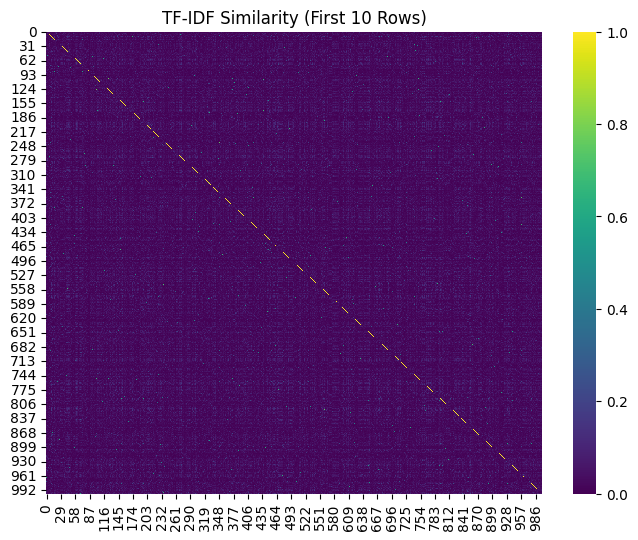

In [482]:
similarity_matrix = compute_similarity(df, processed_columns, weights)

#### **Step 5: Enhance Similarity with Fuzzy Matching**

Enhanced Similarity Matrix (Sample):


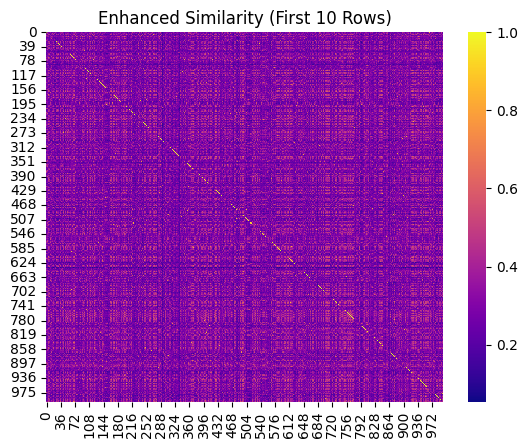

In [483]:
similarity_matrix = adjust_similarity_with_fuzzy(similarity_matrix, df, text_columns)

#### **Step 6: Perform Clustering**

In [484]:
clusters = cluster_entities(similarity_matrix, similarity_threshold)

Number of clusters formed: 1724


#### **Step 7: Visualize Results**

In [485]:
visualize_clusters(df, clusters, text_columns)

Cluster 0 (Size: 3):


name                address        city  \
0               fiore rotisseriqe & grille  3700 w. flamingof rd.  las veqgas   
965   fiore rotisserie & grill Restaujrant     3700w.flamidngord.  tlas vegas   
1077             fuore rotisserie & grille    3700 w. flamingord.  las xvegas   

              phone  category  
0       702-2527702   italiac  
965   702-252-u7702  vitalian  
1077    702-22-7707  italdian



Cluster 1 (Size: 3):


name        address        city          phone  \
1                phbo hoa    642broadway  chiniatown  213-626-q5539   
366                pho ha  642 broadwkay    chnatown    213-6265539   
2495  pho hoa Restauranct    642broadway    chinaton    213 626 553   

         category  
1       vietnamse  
366   vietnaimese  
2495  vvietnamese



Cluster 2 (Size: 1):


name           address        city          phone      category
2  jacksong's farm  439n.beverydrive  los aneles  310/273-55p74  califolrnian



Cluster 3 (Size: 3):


name              address         city          phone  category
3      fwingers   8020 bejerly blvd.   los ageles  213/653 58w58  amexican
2084   swiegers  8020 beverly blvdc.  los angeues   213/653 585h   america
2237  swingerts    8020 beverl blvd.  los angeleo   2f3/653-5858   aerican



Cluster 4 (Size: 3):


name             address            city  \
4              brtighton coffee shop  9600 brigghton way    bverly hills   
1371  brighton coffee shop estaurant   9600qbrighton way  kbeverly hills   
2385           hbrighton coffee shop   9600kbrighton way    beverly hlls   

              phone       category  
4     3r11-276-7732  coffee shlops  
1371  310 276 77b32  covffee shops  
2385    311-2767732  ecoffee shops



Cluster 5 (Size: 1):


name           address       city        phone category
5  awat  210y e. 58th st.  vnew york  212/35-7554    lsian



Cluster 6 (Size: 2):


name                  address       city        phone category
6    frenyh roasu       4586thav.at11thst.    nw york  212/533-223   frlnch
270  frenth-roast  458 6th ave. at 1th st.  newh york  212/533-223    rench



Cluster 7 (Size: 2):


name          address     city          phone     category
7      Fleur De Jor  348 E.m62ND ST.  newyork  212-355-e2020  cofflee bar
1457  fleur de jorr   348 E. 62ND S.  new yok    212/35 2020    coffee ar



Cluster 8 (Size: 2):


name                  address      city          phone  \
8     The Baycchanal  3570 las vegas qblvd. s  lasvegas   r02-731-7525   
2086  the backchanal      357d0lasvegasblvd.s  las vega  702/731 752x5   

                category  
8      onlykin las vegas  
2086  ognly in las vegas



Cluster 9 (Size: 3):


name        address            city          phone  category
9        carmnes  2450 croadway  new york ciity   212-362-j200    ialian
1664    Carine'S    250broadway    ew york city  2j12-362-2200  italiwan
2091  Carmnine'S  2450 brpadway   new york cito  21x2-362-2200    itaian



Cluster 10 (Size: 3):


name                 address      city  \
10    white house restaurant Restaurant    372 peachtree rd. ne    tlanta   
173               White Houe Restaurant  3172 pweachtree rd. ne   atlknta   
2480             Wbite House Restaurant    3172 peachtee rd. ne  atlanita   

              phone category  
10     e04-237-7601    diers  
173   404-237-76f01    iners  
2480  j404 237 7601    dners



Cluster 11 (Size: 3):


name        address            city          phone   category
11     Macartur Park   607 font st.  san ifrancisco    415/398 570  amecrican
193   micarthur pari  607 front sn.   san francxsco    415/38-5700   american
2292  macarthjr paru   607 fron st.   san franfisco  41c5/398-5706  americaqn



Cluster 12 (Size: 1):


name         address           city         phone category
12  Bisstro Roti  155 steuart s.  san francisco  415-4l5-6500   frenxh



Cluster 13 (Size: 2):


name                address        city         phone  \
13   Le Monrachet  3000 w. paradiset rd.   las vxgas   702-732-511   
840  le montrache   3000 h. paradise rd.  las veguas  702s732 5111   

        category  
13    contiental  
840  continentan



Cluster 14 (Size: 3):


name               address        city  \
14                 brents del   19565 parthena ave.   northidge   
1677             brentsn deli   1565 parthenia ave.   norhridge   
2081  brent's dhli Restaurant  k9565 parthenia ave.  dorthridge   

              phone category  
14    818-886v-5679     deis  
1677  8j18-886-5675     dlis  
2081   818-886-567l    detis



Cluster 15 (Size: 1):


name                address        city        phone category
15  fenirx  8358 sunset blvd.west  hollywoeod  213/848 667  americn



Cluster 16 (Size: 2):


name           address            city         phone  \
16  alain rondeli Restaurant  126 CLEMENiT ST.   san francisco  415/387 04k8   
86           alain rodndelli    126 LEMENT ST.  san frauncisco  415/387-04r8   

   category  
16    frenh  
86    fench



Cluster 17 (Size: 3):


name        address            city          phone  \
17    Yoyo Tsumami pBistro   1611post st.    san franisco  4n15/922-7788   
1295    yoyo tsuami bistro    611 post st  scan francisco  415/92l2 7788   
1472   yoyo tsumami bistru  1611 post sy.   san fiancisco    15/922-7788   

     category  
17     frencq  
1295   franch  
1472    frnch



Cluster 18 (Size: 2):


name                                         address       city  \
18    d nico         164mulberryst.etwehengrandandbroomests.  new ylork   
2227  d nico  164 mulberry st.  reteen grand and broome sts.  new yorpk   

             phone  category  
18     21/343-1212  itwalian  
2227  212/343t1212  italvian



Cluster 19 (Size: 1):


name        address        city         phone category
19  r-2  923 e hird st  losangeles  213-687g7179  japaese



Cluster 20 (Size: 1):


name address        city        phone      category
20  cayva  3D ST.  los ngeles  213/658 898  mediterrnean



Cluster 21 (Size: 3):


name          address      city          phone category
21   tangrpavillion       65w.5thst.   new ork  21l2/956-6888     aian
652   tng pavillion  65 w. 55thk st.  new ykrk  2t12/956-6888   asiafn
878  tang pavillion  65 w. 55th sft.  newryork  212-956-688q8     sian



Cluster 22 (Size: 2):


name                   address       city  \
22     buccaner bay club Restaurant       3300lasvegawblvd.s.  lam vegas   
757  buccaneer beay club Restaurant  b3300 las vegas blvd. s.  las vegas   

            phone      category  
22   7h2 894 7350  conjtinental  
757  702-894-u358   continenial



Cluster 23 (Size: 1):


name         address      city          phone category
23  PRICI  500 pharr rdq.  atlantda  404/n237-2941  italiad



Cluster 24 (Size: 2):


name        address            city  \
24    calfornia culinary academy Rescaurant    625 olk st.   san fyancisco   
2034            california culinary acadxmy  625g polk st.  san fraencisco   

             phone category  
24    41s-771-3500  frencyh  
2034  415/7d1-3505   fsench



Cluster 25 (Size: 3):


name                        address     city          phone  \
25    pmmairi    371a w 46th st  off 9th ave  nw york  212w 956-3055   
1689  pomaife  371 w. 46th st.  off 9th avek  ew york   12/ 956-3055   
2100  pomairz   71 w. 46th st.  off 9th ave.  new ork  212b 956-3055   

             category  
25      latin amrican  
1689   latin alerican  
2100  latbin american



Cluster 26 (Size: 3):


name                   address           city  \
26                 enita's frites   1433 thmrd st promenade    sant monica   
882   benita's frites Restsaurant   1433 third st. promeade  santa monicda   
1702              Benita'SyFrites  1433 third st. promenadm  sanrta monica   

             phone    category  
26    310-458-2m89    fast ood  
882   3v1-458-2889   fast hood  
1702   311-4582889  mfast food



Cluster 27 (Size: 1):


name           address          city         phone       category
27  monrachet  239 w. broadwaby  new york ciy  212-2y9-2777  vrench bistro



Cluster 28 (Size: 2):


name                           address      city          phone  \
28     lala   211 W. xROADWAY AT FRANKLIN ST.   new yor  k212/431 0700   
1627  layre  211 W. BROADWAY AT FRANKLIN STm.  oew york    212/41 0700   

             category  
28    middle peastern  
1627   middle eastetn



Cluster 29 (Size: 1):


name        address           city         phone  \
29  SZECHUAN HUNAN COTTAvE  158w8yorkave.  new yorv city  212z535-5223   

   category  
29   cinese



Cluster 30 (Size: 2):


name                                    address       city  \
30   cafffe-reggio  119macddougalst.between3rdandbleeckcrsts.   new yore   
537  caffe rebggio     119macdougalst.betwee3rdndbleeckersts.  inew york   

             phone     category  
30   212/475-9x557  ccoffee bar  
537  212-475-k9557  coffee gbar



Cluster 31 (Size: 1):


name               address         city         phone category
31  tradjr vic'a  9876 wilshire iblvd.  los angelzs  310/276 63d5   asiean



Cluster 32 (Size: 2):


name                          address       city         phone  \
32    carnegoe-deli  847thave.between54thand55thsts.  nkew york   212/77-2242   
1995   carnegie-dli  8547thave.between54than55thsts.  onew york  212/757-2o44   

          category  
32    delicftessen  
1995  delipatessen



Cluster 33 (Size: 2):


name                                            address  \
33     lowcountry-bwrbecue  6301 roswel rd.  sandy sprigs plaza  sndy springs   
2151  lowcoupntry barbecua  6301 roswell rd.  sandy ssrings plaqa rsandy s...   

         city         phone   category  
33    atoanta   44-255-5160   barbemue  
2151  ataanta  40f/255-5160  barubecue



Cluster 34 (Size: 1):


name           address        city          phone category
34  le chardonao  884 MELROSE AVE.  ls angeles  2h13/655-8880   crench



Cluster 35 (Size: 1):


name                                   address      city        phone  \
35  camine's  2450 broadway  beteen 90th any 91st sts.  new zork  212-32-2200   

    category  
35  itaplian



Cluster 36 (Size: 3):


name                                   address       city  \
36    alrotikoa  322 e. 14 st.  behtween 1st and 2nd avs.  new yornk   
41     grotikon            322e.14st.between1tand2ndaves.   new lork   
2472  agrotixon   32z e. 14 st.  between 1st an 2nd aves.  nbew york   

             phone        category  
36    212/47d-2602  meditjerranean  
41    212-473-26f2  mediterraneavn  
2472   212/4732602    mediteranean



Cluster 37 (Size: 1):


name        address      city        phone category
37  sfuzzi Restayrant  p58 w 65th st  new yorw  212/8733702  ameican



Cluster 38 (Size: 2):


name              address          city          phone  \
38    jack spxrat's grill  l0668 w. pico blvd.   cos angeles  311/83b7-6662   
1892   jack-sprat's-grlll   10668 w. pco blvd.  lbos angeles    310837 6662   

          category  
38      health ood  
1892  health foojd



Cluster 39 (Size: 1):


name           address         city        phone category
39  Tommy Tfng'S  731 melrose ave.  los angekes  213/937 573     sian



Cluster 40 (Size: 1):


name              address        city         phone  \
40  bruno's Restaurrant  3838 centinelq ave.  msar vista  311-397-e703   

   category  
40   italan



Cluster 41 (Size: 2):


name               address      city          phone  \
42   bistro  the Rrstaurant   56 E. ADREWS DR. NW   atlantw  m404-231-5733   
555            bistro  pthu  56 E. ANwREWS DR. NW  atlanhta    404231-5733   

           category  
42   frennch bistro  
555   french bistro



Cluster 42 (Size: 3):


name       address       city          phone   category
43      9 jones strei  9 jrones st.    new yor   212-989-122f   azerican
271    9 jones staeet    9 joes st.  new yotrk  212-989-1q220  americlan
1050  9-jojnes-street  9 rjones st.  new yoprk    212/989-122   amegican



Cluster 43 (Size: 1):


name                       address      city        phone  \
44  bouterlin Restaurant  420 e. 59th st.  off 1s ave.  newryork  212/758-033   

   category  
44  freench



Cluster 44 (Size: 1):


name         address     city         phone       category
45  SILVpER SKILLET  THE  2o0 14th st nw  atlantv  40f-874-1386  coffee shhops



Cluster 45 (Size: 1):


name          address        city        phone  \
46  grill on the aglley Restaurant  9560ydayton way  los angees  310/76 0615   

    category  
46  amerzcan



Cluster 46 (Size: 1):


name          address           city          phone  category
47  WESTSIDE COTTAE  689 nintah ave.  nea york city  212-245-080j0  czhinese



Cluster 47 (Size: 2):


name       address       city         phone   category
48     gotham-bar--grill   12 e 12h st   tew york  2m2/620 4020  americamn
233  gotham-bar-&-griqll  12 e 12th rt  nsew york  212w620-4020  wamerican



Cluster 48 (Size: 1):


name            address          city        phone  \
49  CHVYS  4th and hoard sts  an francisco  415/54 8060   

                          category  
49  mexican/latin american/spanvsh



Cluster 49 (Size: 4):


name       address            city          phone  \
50    cafee-claude   7 claue la.    san rancisco    415/392-305   
944   cafe-clauqde   7 claude la   san fpancisco    15/392-3509   
1151    cafe cludo  7 claude lay  san flrancisco  415/392 b3505   
1641    cafe-claud   7 laude ln.  san ofrancisco  4u15-392-3505   

            category  
50             frnch  
944            fench  
1151          frency  
1641  gfrench bistro



Cluster 50 (Size: 2):


name              address         city          phone  \
51     Jackson'S Far  39 N. BEVERLY DRIVE  los anneles    311/273-578   
1866  jackson's-carm  439 N.BEVERLY DRIVE   losangeles  310/273-5v577   

        category  
51    califorian  
1866  caliornian



Cluster 51 (Size: 1):


name                 address          city        phone category
52  ZAB-E-LE  4837 old national hwp.  cfllege park  404-7682705     thii



Cluster 52 (Size: 2):


name                     address       city          phone  \
53    sign of thedove  1110 3RD AVE. AT 65TH STj.  new yoerk  212/861 80v80   
687  sigl of the dove      1110 3rd ave at 65th s    nw york  21r2/861 8080   

      category  
53   amwerican  
687   americab



Cluster 53 (Size: 1):


name             address city          phone     category
54  tommy's Resturant  2575 bmverly blvd.  lwa  213-38w9-9064  hamburgenrs



Cluster 54 (Size: 1):


name         address           city          phone  category
55  rio cafu  170fillmorest.  san fpancisco  41o5-563-2248  amerpcan



Cluster 55 (Size: 3):


name               address           city         phone  \
56    l'orangrie    903n.lacinegablvd.  w. hnollywood  31f-652-9770   
441  y'Orangerie  903n.lacijenegablvd.   w. hollywood  310-652-9r70   
900  loraengerie   903n.lacienqgablvd.    w. holywood   310-652-770   

              category  
56   frnench (classic)  
441    french (clasic)  
900   frenwh (classic)



Cluster 56 (Size: 1):


name                                            address      city  \
57  cafe cenwro  200 park ave  between p45th st and aanderbilt ave  nbw york   

          phone category  
57  212/81 1222   frencz



Cluster 57 (Size: 1):


name           address           city          phone category
58  mitali jeast-west  2x6 BLEECKER ST.  new yorklcity  212 989 1n367   indipn



Cluster 58 (Size: 1):


name            address           city        phone  \
59  khan coke thai house  593o7 geary blvd.  san fwancisco  15/668-6654   

   category  
59    wsian



Cluster 59 (Size: 1):


name                                    address     city  \
60  bic cup Restaurant  228 8th avg.  between 21st and 22nd stsa.  new yor   

          phone     category  
60  12/206-0059  coffee bair



Cluster 60 (Size: 1):


name             address           city  \
61  l'osteiia del forno Restaurant  519 columbus avey.  san frbncisco   

           phone category  
61  415-982u1124   itlian



Cluster 61 (Size: 1):


name                   address       city  \
62  hudson oriver club Restaurant  4oWORLD FINANCIAL CENTER  new zyork   

          phone  category  
62  12/786-1509  lmerican



Cluster 62 (Size: 3):


name              address       city         phone  \
63   zadnkou chickeu  1415 e. colorao st.    lendale   88-244-1937   
593    zakou-chicken  1415e. colorado st.  glendalle  818-244-1u30   
696    zanko chicken  1415 e. colorao st.  gwlendale  818i244-1931   

            category  
63     midle eastern  
593   giddle eastern  
696  mibddle eastern



Cluster 63 (Size: 1):


name          address     city         phone  category
64  SOnO  3330fiedmontrd.  ablanta  404-2y3-2009  japanehe



Cluster 64 (Size: 2):


name            address           city          phone  \
65    ijacks  615 sacramnto st.   san franisco  t415-986-9854   
1218  wjacks   615sadramentost.  san fravcisco   41r/986 9854   

                category  
65      ol san francisco  
1218  old sean francisco



Cluster 65 (Size: 1):


name                          address     city          phone  \
66  INTERNET AFE  82e.3rdstabetween1stand2ndaves.  new yok  212/ 61n-0742   

      category  
66  coffef bar



Cluster 66 (Size: 1):


name                             address     city          phone  \
67  mjarichu  342e.46thqst.between1stand2ndaves.  nw york  212/370 18d66   

   category  
67    rench



Cluster 67 (Size: 1):


name                                    address       city  \
68  irafe  208te. 58th st. between 2nd and 3rd aves.  knew york   

            phone  category  
68  g212-752-3054  italiean



Cluster 68 (Size: 1):


name        address     city        phone category
69  steresa's Restaurant  80modtaguest.  quheens  718-50-2912  polnish



Cluster 69 (Size: 1):


name          address       city         phone category
70  fsan pietro  18 e. 54jth st.  wnew york  21o/753-9013   italin



Cluster 70 (Size: 1):


name                                   address      city  \
71  mesa gilo  102 5TH AVE.  BETWEEN 1y5TH AND 1TH STS.  now york   

          phone   category  
71  212/807-708  amberican



Cluster 71 (Size: 3):


name           address            city  \
72             alaijn-rondelli   126 clpment st.    san rancisco   
380             aeain rondelli  126 clement hst.    san fracisco   
2290  alain rondelli Resturant   126 clemenq st.  san francisrco   

             phone     category  
72     415-87-0408  french (ne)  
380    45-387-0408  french (new  
2290  o15 387 0408  french(new)



Cluster 72 (Size: 6):


name                   address        city          phone  \
73         wSteak House     280 las vegas blvd. s  las vegafs  70u2-734-0410   
118        styeak house    2880 las vegas bvvd. s  las vegats    702/734-040   
348     stak house  the    28z80 las vegas blvd s    las vegs   7j2-734-0411   
418     steak-hose--the  288y0 las vegas blvd. s.  las vegras   7d2-734-0419   
1915        steak eouse     280 las vegas blvd. s   aas vegas    702/34-0418   
1938  steak-houhse--the   2880 las vegas blvu. s.  laks vegas   702-z34-0410   

           category  
73     steak houies  
118   slteak houses  
348    steakholuses  
418    steakhousies  
1915   steak homses  
1938    cteakhouses



Cluster 73 (Size: 2):


name         address            city          phone  \
74    One If By Lyand  Tibs  17 fbarrow st.    new yok city  212-228-082n2   
1487   ONE IF BY LANDs TIBS  17 barrow sts.  xnew york city    12-228-0822   

          category  
74     pontinental  
1487  contiinental



Cluster 74 (Size: 1):


name      address          city        phone  \
75  california culinary xacademo  62c polk st  san fracisco  415/71-3508   

   category  
75    fench



Cluster 75 (Size: 3):


name           address  \
76               rosco's-house-of-chicken-'n'-wafflues  1514 n. gowe st.   
263            roscoeq's house kof chicken 'n' waffles  1514 n. gowerst.   
1600  roscoe's house wf ihicken 'n' waffles Restaurant    151dn.gowerst.   

              city        phone   category  
76    los angegles  213/46-9326    amercan  
263   leos angeles  213/46-9329  amerdican  
1600  rlos angeles  213/466-939  amerijcan



Cluster 76 (Size: 1):


name     address      city        phone   category
77  gotham-bar-&-grivll  2e.12thst.  new yorj  212-620-020  jamerican



Cluster 77 (Size: 1):


name            address           city         phone  \
78  PLMPJACK CAFE  3201 fillmorecst.  ssn francisco  415-c63-4755   

          category  
78  mediterhranean



Cluster 78 (Size: 1):


name            address           city  \
79  izzy's steak & cho house Restlurant  3345 STEqINER ST.  san framcisco   

          phone       category  
79  415-5630487  steak hyouses



Cluster 79 (Size: 2):


name                               address      city  \
80      heera of inda  595 piedmont ave.  rio shopingx mall    atlana   
2104  heera of aindia  595 piedmond ave.  rio shoppini mall  atlcanta   

              phone category  
80    404/876 440l8   asrian  
2104  404/876-440p3     asia



Cluster 80 (Size: 3):


name                         address            city  \
81    ybelvedere--the  9882 little svnta monica blvd.  beverlyh hills   
2012   Belvedere  uhe  9882 little ssanta monica blvd    beverl hills   
2033  belvedere  tmhe  9882 ltittle santa monica blvd  beverly hmills   

             phone           category  
81    310-788-z301    pacific ew wave  
2012  310b788-2301   pacific few wave  
2033  310-788-n300  pacific new wfave



Cluster 81 (Size: 3):


name    address         city          phone  \
82     russell's bugers Restaurant  w1198 pch  xseal beach    31-596-9556   
1880  russell's burgers Restaurant   x198 pch  sfeal beach  31t0-596-9556   
2147            rcussell's-burgers   1x198pch  seal boeach    311-596-955   

         category  
82      hambrgers  
1880  hamburgeers  
2147  hamburgeqrs



Cluster 82 (Size: 2):


name               address      city         phone  \
83      bradshaw's resturana   2911 s. pharr coprt   atlanla  404 261 7h15   
1405  bradeshaw's restaurani  2911 s. pdharr court  atlantla   404-261-715   

           category  
83    southern/sdul  
1405  southjrn/soul



Cluster 83 (Size: 2):


name        address          city          phone     category
84      jiimys  21 moreno dr.    os angeles   310/552 2y94  cojtinental
1927  jimamy's    21morenodr.  los angesles  310/552y 2394   contnental



Cluster 84 (Size: 3):


name                 address         city          phone  \
85    ocean park icafe   3117 ocean park blzd.  snta monica  310 452 i5728   
797   ocwean park cafe    3117 ocean park blve  santa moica   3a0-452-5728   
2110    ocean park cfe  3117 ocean park blovd.  santa onica  310 452 57g28   

       category  
85      amercan  
797   americayn  
2110    america



Cluster 85 (Size: 1):


name       address     city         phone        category
87  GEENWOOD'S  1087 green t  zoswell  770-992-53c3  sxouthern/soul



Cluster 86 (Size: 1):


name                 address       city        phone category
88  Chi'S  3200las vegas blvd. s.  las regas  702 7338899  chinesm



Cluster 87 (Size: 1):


name          address       city          phone category
89  Ij NIDO  251 e. 5prd st.  jnew york  212-753-84e50   itlian



Cluster 88 (Size: 2):


name         address           city          phone category
90   zyank sing  427 battery st  san frfncisco   415/541 494u     asan
858    yank ing  a427batteryst.   sn francisco  b415-541-4949   atsian



Cluster 89 (Size: 3):


name          address  \
91    ritza-carlton-restaurnt-and-dining-room   6q0stocktonst.   
1495  Ritz-Carlton Restaurant An hDining Room  600stocktonsrt.   
1732   ritzcarlton-restaurant-ant-dining-room  60 stockton st.   

                city         phone   category  
91      sn francisco  415-296-74d5  americavn  
1495  sfan francisco   415/29-7465  tamerican  
1732    san franisco  415/m96-7469  amefrican



Cluster 90 (Size: 2):


name                          address         city          phone  \
92   l cachette  10506 lqttle santa monica blvd.  century ity   310-47y-4992   
969  la cachtte  10506 little sarta monica blvd.  century cty  31s0-470-4991   

         category  
92   french (neh)  
969   frenh (new)



Cluster 91 (Size: 1):


name                address      city          phone category
93  SIGNm OF THE DOVE  11103rdazve.at65thst.  new hork  212/861 8w080  amercan



Cluster 92 (Size: 1):


name                   address     city         phone category
94  leaurivage  26025 iacific coast hwy.  malizbu  31p/456-5736   frenwh



Cluster 93 (Size: 2):


name       address            city          phone category
95     swan-oyste-depot  517 polk st.    san fracisco   415 673 110c  seafdod
2295  swan oystdr depoo   151fpolkst.  san francixsco  4k15 673 1101   safood



Cluster 94 (Size: 2):


name             address            city          phone  \
96    chevys Resqtaurant  4th and howar sts.  sani francisco  d415/543 8060   
2388    hevys Restaurant  4th and howard ts.   san franciscp   x15-543-8060   

                           category  
96    mexican/latin american/spanis  
2388  mexican/latin american/spaish



Cluster 95 (Size: 3):


name        address       city          phone category
97    seryjna  11e. 53rd st.  newk york  u212/980 9393     asan
1524  nseryna  1 e. 53rd st.   nkw york  b212-980-9393     asin
2198    seryn   11 e 5crd st    new yok   212/980n9393    bsian



Cluster 96 (Size: 1):


name           address       city          phone  \
98  binion's coffee hop  128 FREMOjNT ST.  las vehas  j702/382-1604   

              category  
98  coffee shps/diners



Cluster 97 (Size: 1):


name              address      city          phone category
99  FNIX  8358sunsetblvd.wtst  ollywood  213x/848 6677  amerian



Cluster 98 (Size: 1):


name                 address     city        phone  \
100  Nuevo Laredo Cantin  149chattahoocheeave.nw  aalanta  404-52-9009   

     category  
100  mexhican



Cluster 99 (Size: 2):


name                   address    city        phone  \
101   pano'sand-paul's  1232 W. PACES pFERRY RD.  tlanta  04/261-3662   
125  pano's-andhpaul's   1232 W. PACES FERRYsRD.  alanta  40/261-3662   

          category  
101   iternational  
125  ikternational



Cluster 100 (Size: 1):


name                                     address       city         phone  \
102  Lla  30 WESv 22ND ST.  BETWEEN 5THaAND 6TH AVE.  new cyork  212/675-6b05   

    category  
102  ameican



Cluster 101 (Size: 3):


name                     address  \
103             seventh regiment messand bar  643 park ave. at 66the st.   
170  keventh regiment mss and bar Restaurant  643 park ave. at u66th st.   
437           aseventh regiment mess and bar    643 park ave. at 66thst.   

          city          phone   category  
103    newyork    212/44-4107    merican  
170  new yuork    212-744-417    aerican  
437   cew york  212/744-410f7  ammerican



Cluster 102 (Size: 2):


name           address            city          phone  \
104   HzAWTHORNE LANE   22 hawthore st.   sanefrancisco  d415/777-9779   
2166  dHAWTHORNE LANE  22 hawqhorne st.  san francirsco    41-777-9779   

        category  
104      aerican  
2166  califrnian



Cluster 103 (Size: 2):


name                              address     city  \
105  ambassadorugrill   1 united natrons plazf at 44th st.  new ork   
708  ambassadorqgrill  1 united nxtions pladza at 44th st.  newyork   

            phone   category  
105   212/70-5012  aemerican  
708  d12/702-5014  ameorican



Cluster 104 (Size: 2):


name               address      city        phone       category
106  Asahi Ramfen      2027sawteleblvd.   wext la  30-479-2234   noodlebshops
343   AsahigRamen  2027 sawtelle blmvd.  west lha  31-479-2231  nojodle shops



Cluster 105 (Size: 3):


name                address         city          phone  \
107   rwestaurant horikawa    111 s. san pedro st  los ankeles   213/680-9w51   
1246    restauran horikawa     111 s san petro st  los anieles  213-6d80-9355   
1292  restaurant horikaewa  11g1 s. san pedro st.   los aneles  21p3/680-9355   

     category  
107     acian  
1246     asia  
1292    asfan



Cluster 106 (Size: 3):


name         address            city         phone  category
108   Cwpress Club  500 ackson st.  san fragncisco  415-y96-8555  amerecan
1235  Cypress Clpb   500jgcksonst.    san francisc  415g296 8555  wmerican
1637  cypress clab  500 jacson st.    san rancisco   415296-8557  aeerican



Cluster 107 (Size: 2):


name          address           city         phone  \
109   marnie's-noodlie-shop  466 hudson sth.  new yrrk city  z12-741-3214   
1941    Marnie'S Nodle Shop      466hudsnst.   new york cit   212741 3214   

     category  
109      aian  
1941    afian



Cluster 108 (Size: 1):


name             address       city         phone  \
110  golden steer Restauraent  308 w. safara ave.  las vedas  702/s84-4470   

        category  
110  steakhouses



Cluster 109 (Size: 3):


name                                 address  \
111              tribca grill    375 greenwich st.h near franklmn st.   
1507  tribeca grill Restarant  375 greenwicho st.  near franklin stz.   
1839  tribeca grill Retaurant    375 greenwich s.  near franklin set.   

           city          phone   category  
111    sew york   212-94s-3900  ameriican  
1507  new yorbk  212e/941 3900  ameriucan  
1839   new york    212/941-390   americam



Cluster 110 (Size: 2):


name            address            city         phone  category
112    campo sato  24y columbus ave.  sadn francisco  415-433-9x23  mewxican
2431  campt santo  240 csolumbus ave   sanxfrancisco  415-433-e626    mxican



Cluster 111 (Size: 2):


name              address        city          phone  category
113  calel sol  4100 CAHUENGA BsVD.  los angels  818/9t85 4669    italin
362   cadl sol  410n CAHUENGA BLVD.  los angele  818/985 4c669  iztalian



Cluster 112 (Size: 2):


name  \
114   mi spia dunwoody rd. Rvstaurant   
1147            mi spia dunwoody frde   

                                                address      city  \
114   park place  across fromt perimetehr mall  dunw...  atslanta   
1147    ark place  across from perimeter mall  dunwoody    tlanta   

              phone category  
114    770/393-13q7  italiin  
1147  770/39s3-1333  italial



Cluster 113 (Size: 1):


name          address          city        phone category
115  Mitaly East-West  296 bleecker st  new york cty  212-989-167   indiat



Cluster 114 (Size: 1):


name                   address     city         phone category
116  fenix  c340w.broadwayatgrandst.  nw york  212-431-u021   fzench



Cluster 115 (Size: 2):


name             address          city          phone  category
117  palkio d'asti  64v sacramento st.  san francisc    415/95-9802   itaoian
516    palio d'sti   60 sacramento st.  san francisc  4x15/395-9800  gitalian



Cluster 116 (Size: 1):


name            address    city          phone   category
119  FYING BISCUIT  THE  1655 mclndon ave.  atlnta  404-687-88b88  edclectic



Cluster 117 (Size: 2):


name           address       city  \
120  lattanzi sistorante Restaurant   361mw. 46th st.  newf york   
407            lattadnzi-ristorante  361 w.k 46th st.  new yorkk   

             phone  category  
120  b212/315 0980  italiian  
407  21b2-315-0980    italin



Cluster 118 (Size: 1):


name         address      city          phone  category
121  remi Reptaurant  145 w. 53r st.  new yogk  212/581-424o2  itajlian



Cluster 119 (Size: 1):


name                            address      city  \
122  turkish kitcen Restaurant  3863rdbave.between27thand28thsts.  new yorz   

            phone       category  
122  h12/679-1811  middle eastrn



Cluster 120 (Size: 3):


name          address           city          phone category
123   le solzeil    133clement st  uan francisco    415/68-4846     sian
1692  lse soleil   133clfementst.   san francisc   415o668-4848    ajian
1845  le dsoleiu  133cclement st.  san fcancisco  n415/668-4849     sian



Cluster 121 (Size: 3):


name               address          city  \
124              susi nozawa  112x88 ventura blvd.  lstudio city   
144             sushi nosawa  11288 venturaw blvd.   stcdio city   
1273  sushi nozawa Restaurat  11288 ventura blvdr.    stuio city   

              phone   category  
124   818p-508-7017   japaneue  
144   8s18-508-7017  ijapanese  
1273    818 508 707   japanese



Cluster 122 (Size: 2):


name       address           city          phone  category
126  biyx      56goldst  sanqfrancisco  415/433-x6300   merican
595  bibx  56 gozld st.   san fracisco  41k5/433-6303  amtrican



Cluster 123 (Size: 3):


name          address           city          phone category
127     outh park cafe  c108 south park   san franisco  41t5/495-7275   lrench
622   South Parhk Cafe   n08 south park   sn francisco    415495 7275   frenck
1906    South Park Caf    108 outh park  saw francisco  415/495-72f75   fyench



Cluster 124 (Size: 2):


name             address      city          phone  category
128   poquitormas   2635 w. olive av.  burbgank  818-5j63-2252    mexica
1502  loquito mas  2635 p. olive ave.    burbnk   818 56k 2252  mexicarn



Cluster 125 (Size: 1):


name        address          city         phone  \
129  GRAMERCY TAVfERN  42 e p20th st  new yok city  212 v77 0777   

           category  
129  american (neu)



Cluster 126 (Size: 3):


name        address           city          phone  \
130             john's pizbzerii  48 w 65th pst   new ork city  212-721o-7001   
1192             John'S Pizxeria  48 w 65th mst  new york citx  212o-721-7001   
1225  john's pizzeria Restauiant   f48w.65thst.  new yord city    212-721-001   

     category  
130      izza  
1192     piza  
1225   piazza



Cluster 127 (Size: 3):


name                    address      city  \
131   hfdgerose heights inn  the      490e.padcesferryrd.ne  atflanta   
569   Hedgerose aeights Inn  The   490 e paces ferry rd. ne  hatlanta   
2188  hedgerosepheights-inn--the  490 e. paces fermy rd. ne   atlantb   

              phone     category  
131   404-233-k7675  continenoal  
569   u404-233-7673  continbntal  
2188   404a233 7673   continentl



Cluster 128 (Size: 2):


name             address         city         phone  category
132  pregjo  36t2 n. camden dr.  los aggeles   310/277-744  italiian
206   erego       36n.camdendr.   los ngeles  3l0-277-7346  italiaqn



Cluster 129 (Size: 1):


name       address           city        phone     category
133  wollenskysj grill  205 e 9th st  nel york city  212 753 044  stkakhouses



Cluster 130 (Size: 3):


name          address           city          phone  \
134               fleur delyu     77 sutter st  san arancisco  415/6m73 7779   
618              fleur de lfs  777 sutcter st.  san frzncisco   415/673-7z79   
2550  fleur de lys Resgaurant     777 suter st   san rancisco    41/673-7772   

     category  
134    frenah  
618     frenh  
2550  fprench



Cluster 131 (Size: 2):


name             address           city  \
135   plumpjack cafe Restauraet  3201 fillmsore st.   sanfrancisco   
2438              Plupjack Cafe    321 fillmore st.  santfrancisco   

              phone      category  
135    415-e63-4755  mediteranean  
2438  415q/563 4755  medierranean



Cluster 132 (Size: 1):


name          address          city          phone category
136  Capp'S Cornqer  1600 POnELL ST.  sa francisco  41k5/989-2581  italial



Cluster 133 (Size: 2):


name               address  \
137              Emerald Garden westaurant  1550h california st.   
2085  emerald ghrden restaurant Restaurant  1550 dcalifornia st.   

                city          phone    category  
137   san franciksco   415-673-115a   vietnamse  
2085  sans francisco  415-l673-1155  vietnmmese



Cluster 134 (Size: 3):


name         address            city          phone category
138   kchez michel   804 nothpoint  san frnancisco  415-775-7m036   fregch
1746   cfez micheu   80 northpoint    san francisc    415-775-036    frenc
2146   ChezsMichel  804 ngrthpoint   san fgancisco  415/775-7h036  frgench



Cluster 135 (Size: 2):


name             address         city          phone  category
139   Mogton'S  8764 melrosej ave.   los angees  310/276 520r5  amerkcan
1115  Morson'S    8764rmelrose ave  ios angeles   310-276l5205  azerican



Cluster 136 (Size: 1):


name                    address       city        phone  \
140  boca nhice  13 1ST AVE.  xEAR 1ST ST.  new yvork  212-47-0108   

           category  
140  latin nmerican



Cluster 137 (Size: 3):


name          address           city  \
141              Union Suare Cafe  21 e.v 16th st.   newyork city   
904   uion square cafe Restaurant    21 e f16th st  new ybrk city   
2139             union square caf      21 e 16th t  new york ciwy   

             phone         category  
141    212243-4028  americsan (new)  
904    212-43-4024  amaerican (new)  
2139  212-24h-4020    amercan (new)



Cluster 138 (Size: 1):


name          address          city        phone  \
142  straqts cafe Restaurant  3300 geary lvd.  san francico  415/68-1783   

    category  
142    xsian



Cluster 139 (Size: 2):


name                                address      city  \
143   bacchanatia   3125 piedmon rd. xnear peachtree rd.    tlanta   
1383   bachanalia  312l5 piedmont rd.  near peachtreerd.  atlganta   

             phone        category  
143    404/36 0410  internatrional  
1383  404-365-0o10   mnternational



Cluster 140 (Size: 2):


name     address            city          phone category
145   lezcentral   43bushst.  san franceisco  415/391-z2232  frencch
646  le centryal  453bushjt.   san francisoo   415/39m 2233  sfrench



Cluster 141 (Size: 1):


name           address          city          phone  category
146  MAINCOURSE  THE  10509w.picobled.  rancho pgark  310 4i75 7564  american



Cluster 142 (Size: 2):


name                                     address      city  \
147    illy's  948 1st ave.  between 52nd and 53lrds sts.   ne york   
1299  bclly's    948 1st ave.  betwen 52nd and 53rdx sts.  new yorh   

             phone  category  
147    212/53-1870  ameritan  
1299  212h753-1870  americkn



Cluster 143 (Size: 1):


name          address          city         phone category
148  carnegie deyi  84 seventh ave.  ne york city  2b2 757 2245    delzs



Cluster 144 (Size: 2):


name                address      city         phone  \
149   Indivo Coastal Grill  1397 n. lighland ave.    atanta   04 876 0676   
447  indigo-coastal-grrill  1397 n. higheand ave.  atlyanta  404-876-067v   

     category  
149  eclebtic  
447  eclecbic



Cluster 145 (Size: 3):


name                   address  \
150            palm--the-(los-angelecs)  9001 santat monica blvd.   
1944  palm  the (los angels) cestaurant    9001 santa monica lvd.   
2469           palm  the (los tangeles)    9001 santaqmonica blvd   

              city          phone      category  
150   w. hollywoou  31f0 550 8811    steakhouse  
1944   w. hllywood   310r550-8816    stakhouses  
2469   w.hollywood  310 550 8d811  steakhouqses



Cluster 146 (Size: 2):


name            address      city          phone  \
151  RITZ-CARLTON CAFE (jATLANTA)  181 peacbtree st.   atlmnta  4u04-659-0400   
195  RITZ-xCARLTON CAFE (ATLANTA)   181 peachtre st.  atmlanta  404-659t-0400   

           category  
151   american (nw)  
195  americanx(new)



Cluster 147 (Size: 1):


name                 address     city        phone category
152  Mi Cocna  57janest.offhudsonhst.  new ork  22/627 8273  mexdcan



Cluster 148 (Size: 1):


name                    address     city        phone  \
153  vvrbena Restaurant  54 irvingepl. at 17th st.  nw york  212-20-5454   

      category  
153  ameriqcan



Cluster 149 (Size: 3):


name          address      city          phone category
154     hopstio  4279roqswellrd.  atvlanta  404-255-4d868   cinese
559   Chopystix  4279 roswell d.   atlants  404i-255-4868  chinpse
2375  chopustix   4279 roswellrd    atanta    404-255-867   chinse



Cluster 150 (Size: 2):


name             address  \
155   yrujean kaqg's gourmet chinese cuisino  67 n. raymond ahe.   
1888     yujen kangs gourmet chinese cumsine     67 n raymnd ave   

              city         phone category  
155   los angelwes  8l8/585 0855   asiarn  
1888    os angeles   88/585-0855    asqan



Cluster 151 (Size: 1):


name                         address            city  \
156  cofe blanc Restaurant  9777 LITjLE SANTA MONICA BLVD.  beverly hiklls   

           phone         category  
156  311-888-008  pacific newwave



Cluster 152 (Size: 1):


name          address     city         phone category
157  AgLAMO  304 e. 4ath st.  new yok  212- 59-0590  rexican



Cluster 153 (Size: 1):


name                                            address      city  \
158   dt  11b1 e. 22pd st.  between park ave. s and lexi...  ndw york   

           phone category  
158  212/9958500   frgnch



Cluster 154 (Size: 3):


name  \
159   stringer'so fish camp and oyster bar Ristaurant   
1471                stringers fish camp and yyser bar   
2253            stringer'us fish camp band oyster bae   

                             address      city          phone   category  
159   3384 shallowford od.  chamblee    atlnta  770/4b58-7146   soufhern  
1471   3384 shalowford rd.  chamblee    atlant   u70/458-7145   sxuthern  
2253       3384shallowfordrd.chablee  atldanta  770/458w 7145  southelrn



Cluster 155 (Size: 3):


name          address       city          phone   category
160    doe allen   326 w.46th st.  new yorlk   212/581 g464  ameriican
1107   joe allej  32y w. 46th st.   neu york    212/51 6464   amkrican
2504  Jkoe Allen   326 W. 46TH T.    new yrk  212/581 6g464    merican



Cluster 156 (Size: 1):


name         address      city        phone category
161  dbniel  20 e. 76thfst.  newnyork  212/288-033    frenh



Cluster 157 (Size: 1):


name              address      city        phone       category
162  VICTOR'SpCAFE  52 236 w. 52nd sbt.  new cork  212/5867714  ltin american



Cluster 158 (Size: 2):


name                   address    city         phone category
163   majestc  1031 ponrce de leon ave.  tlanta  404n875-0276    iners
1094  majestc   1031 ponce de leon akve  atlnta   404-875-274   dpners



Cluster 159 (Size: 2):


name                        address      city        phone  \
164   mqtown-cafe  104 w. 7th st.  near 6th ave.  new yorq  212/581 030   
1049   motown cfe   104 wi 57th st  near 6th ave  new ybrk  212581-8030   

     category  
164   merican  
1049  aerican



Cluster 160 (Size: 1):


name            address         city          phone    category
165  jiraffxi  502santamonicabld  santa monia  311-917-667e1  caliornian



Cluster 161 (Size: 1):


name                 address    city        phone category
166  mary mac tea room  224 POiCE DE LEON AVE.  alanta  404/876-180  souhern



Cluster 162 (Size: 1):


name          address   city          phone  \
167  stick to your ribs Rwestaurant  5-16 51bst ave.  ueens  71y8 937 3030   

    category  
167      bbw



Cluster 163 (Size: 1):


name          address           city         phone category
168  dawat Restauralnt  210we. 58th st.  new york cjty  212-355-75h5    indan



Cluster 164 (Size: 1):


name                                    address       city  \
169  montee  1134 1st ave.   between 62n ald 63rd sts.  new yorak   

             phone category  
169  2f12/421-4433   aesian



Cluster 165 (Size: 3):


name           address       city          phone  category
171   qorso     3n2 w 46th st  new byork   212-489-721c  italigan
1020  orxso  322 w. 46th sth.   newvyork   212-4f9-7212    ialian
1560  rorso   322 w. 46th bt.  new zyork  212-489-721q2  zitalian



Cluster 166 (Size: 3):


name                                          address  \
172   fujiyama mjama    467 columbus ave.  between 82nd andw 83rd st.   
1092   fujzyama-mama  467 columbus ave.  between 8k2nd ansd 83rd sts.   
2209    fujyama-mama   467 columbus have.  between 82nd axd 83rd sts.   

           city         phone category  
172    new yorv   212/76-1144   adsian  
1092    nw york  212/769 114p    osian  
2209  hnew york  212/j69-1144    azian



Cluster 167 (Size: 1):


name             address          city         phone     category
174  caffe grecz  423 COLUMBUS AVmE.  san franisco  415-39i-6261  contmnental



Cluster 168 (Size: 2):


name             address      city        phone category
175   ccfe botanica   160 centra park s   ne york  212/484-512   frinch
1486  cafe bocanicu  160 centnal park s  new yock  12/484-5124   zrench



Cluster 169 (Size: 3):


name                           address       city          phone  \
176   divna  341 w.j broadway  near grand st.  new yorok    212/941 902   
296     dva     341 w broadwhy  near grand st  neqw york  2h12/941-9024   
1894  divua      341 w broadway  ner grand st   ntw york   212/941-90x6   

      category  
176    itelian  
296   itaxlian  
1894    itaian



Cluster 170 (Size: 2):


name             address      city        phone  category
177  tastv-of-new-orleans   889w.peabhtreest.  agtlanta  404/87-5531  southefn
385  taste-of-new-orleant  889w.peachvtreest.   atltnta  404/874 535  southxrn



Cluster 171 (Size: 1):


name                               address  \
178  nickiempoto's:-a-sushi-bar  247 BUCKHEAnD AvE.  EAST VILLAGE SQ.   

         city        phone category  
178  atlanwta  404842-0334   fision



Cluster 172 (Size: 2):


name             address            city         phone  \
179     dardellis  243 o'farrelkl st.    san fancisco  415/d82-0246   
1650  bardwelli's    243 ofarrell st.  san franczisco  415/9g2 0243   

                category  
179    old san francisco  
1650  old san franciscso



Cluster 173 (Size: 1):


name       address      city          phone category
180  SANPIETRO  18 e 54th ft  new uork  212/753u-9013   italin



Cluster 174 (Size: 2):


name          address           city          phone  category
181  ocean aveznue    140 ocean ave   santa monnca  310/394 5w669  amdrican
752    ocean venue  1401 oceaz ave.  santa monicta    310-34-5669  ameriqan



Cluster 175 (Size: 2):


name                          address      city  \
182     alecks barbecie heaven   783 martin luthet king jr. dr.  catlanta   
2542  Aleck'S Barbecue Healven  783 martiyn luther king jr. dr.   ateanta   

              phone   category  
182    404/5o5-2067  sbarbecue  
2542  404-525-20k62  barbecuqe



Cluster 176 (Size: 2):


name            address     city        phone category
183   sa su ki   304p buford hwy.  atlanta  404-325-585     asan
1543  sa-tsuki  3043 bufordc hwy.   atlana  404/325-528    afian



Cluster 177 (Size: 2):


name         address            city         phone     category
184    moscburgers   1322 gran st.   say francisco   415-788-376  hamburgerds
237  mo's-buhrgers  1322 grant sty  sahn francisco  415-78v-3776    hamburgrs



Cluster 178 (Size: 2):


name           address      city         phone category
185    touluse  b tpeachtree rd.  atlanyta   44/351-9533    frenc
1593  toulousl    bpeamchtreerd.   atlantm  404-z51-9533  qfrench



Cluster 179 (Size: 1):


name               address       city        phone  category
186  feasz  241v1 w. sahara ave.  pas vegas  72/367 2411  buiffets



Cluster 180 (Size: 1):


name           address       city        phone category
187  feaqu  2411w sahara ave  las veoas  702-367-411   buffts



Cluster 181 (Size: 1):


name                        address     city  \
188  frico bar Restauranp  402 w. 43rd st.  off 9uh ave.  ew york   

            phone category  
188  2q2-564-7272   italin



Cluster 182 (Size: 2):


name        address            city          phone  \
189  la caravetle  33 W. 55TH T.    new york cit  212-g586-4252   
313  La Caaavelle  33 W 55TH ST.  new york ecity    212-586-422   

              category  
189  french (clasfsic)  
313    frech (classic)



Cluster 183 (Size: 3):


name                 address     city          phone  \
190   mary mac's tfea rooi  224 ponce dec leon ave  amlanta    404-87-1805   
938     mary macs tea roou   224 ponce de ceon ave  atlantm  404 876 18t00   
1335  mary mac's teac room   224 ponce dezleon ave  atlanna   404-876-18x0   

            category  
190   southzern/soul  
938     southrn/soul  
1335    souhern/soul



Cluster 184 (Size: 3):


name             address           city         phone    category
191    grexns  bldg. a fortxmason   san francico  415/771 6s22  vegetqrian
2291    Grens     bzdg.afortmason  sai francisco   415/771-622   egetarian
2417  Greenks    bldg a fort mson  san francitco  41k/771-6225  vegetariaz



Cluster 185 (Size: 1):


name                   address      city          phone  \
192  Colonnade Restarant  1879 CHESHIRE BRIDGm RD.  atlajnta  404q/874-5642   

      category  
192  soutlhern



Cluster 186 (Size: 1):


name       address      city        phone   category
194  vinc & eddie's  70 w q8th st  newuyork  22/721 0068  aamerican



Cluster 187 (Size: 3):


name        address            city          phone  \
196   oone market Restaurant  1 maruket st.  san franciscjo   415/77w-5577   
1075  one mgarket Restaurant      1marketst    san rancisco    415-777-577   
2013               one-mrket  1i market st.    san francico  415/777-55g70   

       category  
196   aqmerican  
1075   amepican  
2013    americn



Cluster 188 (Size: 1):


name                                     address     city  \
197  Cgarmine'S  2450 broadwqy  between 90th and 91syt sts.  newyork   

           phone category  
197  212/362 220   itaian



Cluster 189 (Size: 3):


name         address            city  \
198   sam's noodle shoap Restaurant  411 thirdsave.    new york cit   
630                sa's noodle shop  a11 third ave.  inew york city   
1626    sams noodle shop Restaurant   411 third bve  new yojrk city   

              phone  category  
198     12-213-2288    chnese  
630   212 213m 2288   chbnese  
1626  2o12 213 2288  chiknese



Cluster 190 (Size: 3):


name        address            city         phone  \
199    Kelly'SOn Trinity  h333 bush st.  sfan francisco   415-362-444   
2281   kelly's on tinity    333 bush t.  san frfancisco   415 3624454   
2351  Kelld'S On Trinity     333 bush t   san franciszo  415-3f2-4454   

          category  
199   calhifornian  
2281   califurnian  
2351   califorpian



Cluster 191 (Size: 1):


name          address     city  \
200  fifty seven fifty seveb Restaurant  5f7 E. 57TH ST.  new yor   

            phone   category  
200  212/758o5758  amegrican



Cluster 192 (Size: 3):


name                      address       city          phone  category
201   emly's    1325 5h ave. at 111th st.  new yzork  212/996-121a2   amerian
586   emily'  1325 5th ave. at 111tch st.  new yxork    212/996 122   americn
950  emilyhs   1325 5th ave. al 111th st.    ew york  212/996 d1212  americau



Cluster 193 (Size: 1):


name        address          city          phone  category
202  iSUSHISAY  38 . 51st st.  new york ity  212-755-178u0  japbnese



Cluster 194 (Size: 1):


name              address    city          phone  \
203  rubin's rxed hots Restaurant  c15322 ventura blvd  eniino  818-y905-6515   

     category  
203  hot does



Cluster 195 (Size: 1):


name                                   address      city  \
204  qBig Cup  22 8TH AVE.  BETWEEN 21ST AND 22zND STS.  new ybrk   

           phone   category  
204  21-206-0059  coffe bar



Cluster 196 (Size: 2):


name             address            city          phone  \
205   stars cafeRestaurant  500 varn ness ave.  san franclisco  y415/861-4344   
2474           stars cafde  500 vacn ness ave.   san francfsco   41y/861-4344   

      category  
205   americzn  
2474  american



Cluster 197 (Size: 2):


name        address      city         phone  \
207   city grill Rxstaurant   50 hur plaza    atlana   404/5242489   
1385            cinty grill  50 hurt plazn  atlantna  404j524 2489   

          category  
207   internatinal  
1385  internationa



Cluster 198 (Size: 3):


name                 address      city  \
208   ritz-lcarlton dining room (buckheadw    434 peachtree rd. ne  atlanmta   
1876   Ritz-Carlton Diyning Room (uckhead)  3434 peachtree urd. ne    atanta   
2039         ritz-carlton cafeh (buckheada     3434 peachtreerd ne   aelanta   

             phone         category  
208    40-237-2700    american(new)  
1876  404-237-2u05  american (neew)  
2039   40 237 2700    amrican (new)



Cluster 199 (Size: 1):


name                                     address     city  \
209  mad-fis  2182 BpROADWAY  BETWEEN 77Th AND 78TH STS.  new yor   

             phone category  
209  212/78e7-0202   seafod



Cluster 200 (Size: 3):


name              address      city          phone  \
210    brookhavn-cafe     4274aeachtreerd.  atlantoa   404 231b5907   
1317  vrookhaven cafo  4274 peachtree frd.    atlant   404-q31-5907   
1733   brookhaven-caf      4274peachtreer.  atlwanta  404-231-59y07   

         category  
210   vegetaurian  
1317   vegetarian  
1733  vegetariabn



Cluster 201 (Size: 1):


name                                    address  \
211  l'auberge Restturant  1191 1st ane.  betwten 64th and 65th sts.   

          city         phone         category  
211  new ywork  n12/288 8791  middloe eastern



Cluster 202 (Size: 2):


name              address          city  \
212   pinot bistro Resturant   12969 ventura blzd  studieo city   
1680           pinot bistreo  12969 ventura blvd.   studiy city   

              phone      category  
212   818 990g 0500  frenh bistro  
1680  818 990 050m0  frenc bistro



Cluster 203 (Size: 1):


name        address          city        phone   category
213  rumpul  1 TILLMAN rL.  san franciso  415-421-230  amerkican



Cluster 204 (Size: 1):


name       address     city          phone category
214  pen &pencil  20ue.45thst.  new yor  212/682s 8660  aerican



Cluster 205 (Size: 2):


name                  address       city  \
215               coyore cafe (las vegasa  3799 las vegas blvdc s.  lasmvegas   
2162  xcoyote cafe (las vegas)uRestaurant   3799 las vegas bld. s.  lasfvegas   

              phone       category  
215     70-891-7344    southwesern  
2162  7p02-891-7349  southwesytern



Cluster 206 (Size: 2):


name                          address      city          phone  \
216   nkolai's roof  255 curtland st.  at harris st.  ratlanta  404/221 63a62   
1802  nikolai's roo                255 courtlanf st.    atlana  404 c221 6362   

         category  
216   fontinental  
1802   continetal



Cluster 207 (Size: 2):


name            address        city        phone    category
217    tilkerman  the   2245e.flaminord.  las viegas  70-731-4036  steakhouse
1400  tillerman  dthe  224 e flamingo rd   las vexas  702-31-4036  stekhouses



Cluster 208 (Size: 2):


name    address            city         phone  \
218   benny's burritos Reskaurant  93 avt. a  new iyork city  212-s54-2054   
1913  benzy's burritos Restaurant  93 ade. a  newz york city   21-254-2054   

     category  
218   mexijan  
1913  meaican



Cluster 209 (Size: 3):


name               address     city          phone      category
219    grania  23725 w. malibuy rd.  mazlibu   310 y56 0488   californijn
514  agraniti  23t725 w. malibu rd.    malib    310/56 0488  californiakn
517  guranita     23725uw.maliburd.   mhlibu  310-45l6-0488   calefornian



Cluster 210 (Size: 3):


name             address          city          phone  \
220   zrj's the rib joinu   252 n. bverly dr.  los agngeles  31n1/274-7427   
464    jj's-the-rib-joint  252 n. beierly dr.  qlos angeles   310/z74 7427   
1766    rj'sthe-rib-joint    2m52n.beverlydr.   los angelej    310/274 742   

       category  
220     amercan  
464    ameiican  
1766  americtan



Cluster 211 (Size: 1):


name                  address    city         phone category
221  SOUTH OF FRyNCE  2345 cheshire bridg rd.  tlanta  404/32t-6963  fretnch



Cluster 212 (Size: 2):


name              address        city         phone  \
222   MARY'S DINqER  5111 w. boulderhwy.  las vdegas  702-45d-8073   
1652    MARY'S DINR  5111 w bobulder hwy    lasvegas  7o2/454-8071   

                category  
222   coffe shops/diners  
1652  coffee shops/dinrs



Cluster 213 (Size: 2):


name                address     city  \
223              bone's-restaurannt      31j0piedmontrd.ne  aolanta   
2570  bone's restaurrant Restaurant  3130 piejdmont rd. ne  atlgnta   

             phone      category  
223    04 237 2663  steazkhouses  
2570  404 2b7 2663   zteakhouses



Cluster 214 (Size: 2):


name        address            city         phone        category
224  LlLU  816 OLSOM ST.    san rancisco  415j495 5775  mediterraneoan
802  Lula  81 FOLSOM ST.  san franceisco  415-4c5-5775    mditerranean



Cluster 215 (Size: 6):


name          address            city          phone  \
225   picnholine    35 w. 4th st.        few york  212/724 l8585   
284   picholline    35w. 64th st.   new yjrk city    212-724-885   
470     pichline  35 w. 64trh st.    new york cit  212e 724 8585   
1557   picholibe    35 w. 64th st  new yocrk city  212 724 85i85   
1659  picholinse     z35w.64thst.        net york   212/724-858u   
1674   Pecholine       3w.64thst.       new yuork    212/74-8585   

           category  
225   mediteraanean  
284    mediteranean  
470   mediterranban  
1557   mediterraean  
1659   mediterranea  
1674   medierranean



Cluster 216 (Size: 3):


name                                          address       city  \
226     Montachet  239 w. broadway  between walkder and whitp sts.   new yodk   
1056   Monteachet      239 w broadway betwesn walker and white sts   neq york   
1615  Montrzachet     23v9 w broadway  between walkr and white sts  newf york   

               phone category  
226    n12/ 219 2777  frcench  
1056  2e12/ 219-2777  ofrench  
1615  212d/ 219-2777    frenc



Cluster 217 (Size: 2):


name               address         city          phone   category
227   PatyS      1001riversidedr.  toluca lake  818/761-912w6    ameican
1611   paty  10001 riversbide dr.  toluca hake    818/761-915  amerrican



Cluster 218 (Size: 2):


name             address       city          phone category
228   les celerites   160 central par s  new yaork    212/484 511   frerch
321  les celebrijea  160 cenoral park s   nmw york  212/4t84-5112    rench



Cluster 219 (Size: 1):


name            address    city          phone      category
229  NIKOLAI'S ROO  255 cmourtland st  tlanta  404-2t21-6362  continenntal



Cluster 220 (Size: 3):


name        address        city         phone  \
230    andres frenbh restaurant  401s. 6th st.  las veguas   72-385-5016   
893   Anore'S French Restaurant  401 s. 6t st.   las vegds   702-385-501   
2369  andre's-french-restaurant  401 s 6th st.    as vegas  702-385-50f8   

             category  
230   french (classic  
893   frenh (classic)  
2369  rench (classic)



Cluster 221 (Size: 1):


name      address            city         phone       category
231  JOJO  60e.64thst.  nlew york city  2p2-223-5656  french biptro



Cluster 222 (Size: 3):


name                                            address      city  \
232   cafe-lure  169 sullivan at  between houston and bleeqcker...   ew york   
932   Caffe ure   169 sulxivan st  betwee houston and bleecker sts  new yofk   
2483  caffe-lur  169 sullivan st.  between houetob and bleecker...  new yorh   

             phone category  
232   2d2/473-2642    frenc  
932    212/47-2640    frenc  
2483   21/473-2642    frnch



Cluster 223 (Size: 2):


name              address       city          phone  \
234    Lillie Langtcy'S  129 e. fremount st.  laszvegas    702-385-711   
2452  Lillie rLangtry'S      129 e femont st   la vegas  702q-385-7111   

     category  
234      sian  
2452     asia



Cluster 224 (Size: 2):


name          address           city        phone  category
235   fog city diver  1300bdatteryst.  san fpancisco  415/9822000  amecican
2027  fog-city-diner  1300bfatteryst.   san franciso  415-982-200  american



Cluster 225 (Size: 2):


name                address            city          phone  \
236   vivande ristorant  670 goldenl gate ave.  san francixsco    415/67 9245   
997  eivande-ristorante   670 golden gate avy.    san franisco  415/s673 9245   

     category  
236  citalian  
997    ialian



Cluster 226 (Size: 1):


name         address            city        phone     category
238  ALM TOO  840 SECOND AE.  newn york city  212 69 5198  steakhooses



Cluster 227 (Size: 2):


name                address       city          phone  \
239   PALACi COURT  3570 las vega blvd. s  las vegat   702/731-7w47   
1610   PALAE COURT     3570lasvegasblvdbs   las egas  702/731h 7547   

         category  
239   continenual  
1610   contnental



Cluster 228 (Size: 2):


name                address      city          phone  category
240    bertolinis    3570lasvegasblvgd.s  las vega  702-a735-4663    italin
1660  Bertobini'S  3570 las vegasblvd. s  las veas    702-75-4663  itadlian



Cluster 229 (Size: 3):


name         address       city          phone category
241    emnire koreu    6 . 32nd st.   newayork    212/725-133     sian
925   emppire korea    6 e. 32n st.  jnew york  21s2/725 1333   fasian
2054    empirekorei  6 e.b 32nd st.   new yhrk  212/o725-1330   asiasn



Cluster 230 (Size: 2):


name           address       city          phone category
242  qLE BERNARDIN       155w.5stst.  new yorlk    22/489 1515  frencmh
381  LE BhERNARDIN  155t w. 51st st.  new yotrk  212-489-z1515  farench



Cluster 231 (Size: 3):


name             address          city         phone  \
243    pinot hpllywooo   1448 nt gower st.  los angeleos  213/461-8x01   
394    pinot hollygood  1448 n. tgower st.  lzos angeles   213-461-880   
1813  pinoft-hollywood      1448 n ower st    os angeles   23/461-8806   

          category  
243   caglifornian  
394   calizfornian  
1813    californin



Cluster 232 (Size: 1):


name          address      city         phone  \
244  BINION'SCOFFEE SHOP  128 fremont sw.  lasvegas  702/38b-1600   

                 category  
244  coffee sehops/diners



Cluster 233 (Size: 2):


name            address         city  \
245   il fornaio cucina italianma  301 N. BEVERL DR.   los ageles   
1551   il fhrnaio cucina italiane  301 . BEVERLY DR.  los aygeles   

              phone category  
245     310/50-8333   italia  
1551  311/550-83w30   itlian



Cluster 234 (Size: 1):


name        address     city         phone category
246  Lattanzi Ristoranqe  361 c 46th st  newyork  212/31d-0985  italimn



Cluster 235 (Size: 2):


name                                 address  \
247              gramercytavern  42e.20thst.betwenparkave.csandbroadway   
2101  gramercy tavernRestaurant   42e.20thst.betweenparkave.andbroadwam   

           city          phone  category  
247     nw york  212/4q77-0773   americn  
2101  new yoryk   212/477-0l77  ayerican



Cluster 236 (Size: 3):


name         address           city  \
248    mifune japan center  kinteutsu buildin     17v7postst.  sanbfrancisco   
790   mifune japan center  kintetsu duildicng  173d7 post st.  saq francisco   
1836   mifune japan center  kintets buildixne  1737 post syt.   an francisco   

              phone category  
248   41e5/922-0333     asia  
790    4o5/922-0331     asan  
1836   415-9m2-0337     sian



Cluster 237 (Size: 3):


name          address       city         phone  category
249     tringolo     34ke.83rdst.  new syork  212/r72-4488    talian
853    taiangolo    345 ek83rd st    nw york   212/472-488  iltalian
1846  triangoluo  34t e. 83rd st.    newyork  212/472-44b7   itrlian



Cluster 238 (Size: 2):


name           address     city           phone category
250     e-colonial       149e.57thst  new yor  212/s 752-0804   askian
1003  le-colonikal  149 eo. 57th st.  new yrk    212/ 7520801     asan



Cluster 239 (Size: 1):


name                           address      city          phone  \
251  berjolinis  3500 PEACHTREE RD.  PHIcPS PLAZA  atlnanta  404-2r33-2333   

     category  
251  itxalian



Cluster 240 (Size: 1):


name                    address     city  \
252  aleck's arbecue heaven Reystaurant  783marticlutherkingjr.dr.  atlarta   

           phone category  
252  404-525-202  barbecu



Cluster 241 (Size: 2):


name        address      city        phone category
253   gite   120w.51sust.  iew york  212/56 7100    frenh
2211   ite  1g20w.51stst.  neh york  212-9567100  frennch



Cluster 242 (Size: 1):


name         address          city        phone        category
254  mboulevard  1 MsISSION ST.  sn francisco  415 543 604  americav (new)



Cluster 243 (Size: 3):


name                                          address  \
255   l'aubergge-du-midi   310 w. 4th st.  between w. f2th ajnd bank sts.   
1013    l'auberge-dumidi    310 w. 4th st.  between w. 12th and bzank ss.   
1206     laubege du midi  310 w. 4th st.  between w. 12th and ybanbk sts.   

           city          phone category  
255   snew york   2y2/242 4705    frenc  
1013   nev york    21/242-4705  frenqch  
1206   new yorw  212/242-r4705  frwench



Cluster 244 (Size: 2):


name    address           city          phone category
256  chez meange Restaurant     1716pc   redodo beach  310c-540-1222  eclecic
530           echez-melange  17h16 pch  redoddo beach  3h10-540-1223  eclectc



Cluster 245 (Size: 2):


name            address city         phone  \
257  johnny rokckets (la) Restaurant   507 melrose ave.  sla   213 651 336   
776  johnnyp rockets (la) Restaurant  7507 melrose avej  lga  21l-651-3366   

      category  
257    ameican  
776  americafn



Cluster 246 (Size: 3):


name           address            city        phone  \
258             vesegka  c144 second ave.   nfw york city  212-22-9682   
1797            vesylka   144 second nve.    new yorkcity  212-228-962   
1881  veselka Resaurant    144 secoxd ave  new yorkw city  212-22-9682   

       category  
258    krainian  
1797  ukrainiab  
1881   ukrinian



Cluster 247 (Size: 1):


name  \
259  marquet patibsserie Restaurant   

                                               address      city        phone  \
259  15 e. 12th sot.  between 5th ave. and uiwversi...  newqyork  212/22 9313   

        category  
259  cofdfee bar



Cluster 248 (Size: 3):


name             address           city          phone     category
260   dnuke's   8909 sunsetm blvd  w. hollywocod   311-652-c110  offee shops
1216  dutke'o  c8909 sunset blvd.   w. hojlywood    310-652-310  cofee shops
2391    uke's  8909n sunset blvd.    w. holywood  31n0 652 3100  offee shops



Cluster 249 (Size: 1):


name            address           city          phone category
261  mobnsoon (ny)  435 asterdam ave.  oew york city  212-58a0-8686     chai



Cluster 250 (Size: 2):


name           address       city        phone   category
262  vonu  200 e. l54th st.  new ybork  212-46-9592    amercan
976  vona    200 e. 4th st.  bnew york  12-486-9592  amexrican



Cluster 251 (Size: 1):


name                                address     city        phone category
264  wsa  63rd stgreet steakhouse 4 w. 63rd st.  ne york  22/246 6363  amercan



Cluster 252 (Size: 2):


name                                          address  \
265   gladstoje's    fish 17300 packfic coast hwy. at sunset blvd.   
861  gladstoneh's  4 fish 17300 pacific coast hw. at sunrset blvd.   

                   city          phone   category  
265  pacifice palisades  310/t454 3474  amewrican  
861    pacific palisade    310/45-3472   aqerican



Cluster 253 (Size: 2):


name       address            city         phone category
266    mnfune  1737poustst.   sgn francisco  415-922w0337  japanse
1704  Mrifune  1737post st.  san fraencisco   415922 0337  apanese



Cluster 254 (Size: 2):


name               address        city         phone  \
267    sAYFLOWER CUISINIER  4750 w. sahara aveh.    las veas  702-870o8431   
2572  MAYFLrOWER CUISINIER    4750w. sahara ave.  las tvegas   702 70 8432   

      category  
267   cthinese  
2572  cfhinese



Cluster 255 (Size: 3):


name                         address  \
268   spring street natural restgauant & bar     62spring st at lafayette st   
1142   springstreet natural restauaant & baa  62 springhst. at lafayette st.   
2543    sprig street naural restaurant & bar   62 spring st. at lafayettest.   

           city         phone   category  
268     ne york  212/966-0q99    aerican  
1142    new ork   212/966 029  avmerican  
2543  new pyork   212/9660290  americasn



Cluster 256 (Size: 2):


name          address            city         phone category
269   uncloe nicks   7a7 ninth ave.  new york citmy  21x-245-7992   grveek
1930   uncle nic's  74b7 ninth ave.    nw york city  212-2t5-7995   gpreek



Cluster 257 (Size: 2):


name  \
272    Bryan Park Grill  Roof Restaurant And mp Cafe   
1164  brkyantpark-grill--roof-restaurant-and-bp-cafe   

                                        address       city         phone  \
272            25w.40thst.between5thxnd6thaves.    new yor   212-8406500   
1164  25 w. 40th st.  betweenm5th end 6th aves.  new yorgk  212-8s0-6500   

      category  
272    aerican  
1164  aierican



Cluster 258 (Size: 3):


name         address       city          phone  \
273   lespinassk Restaurant  2 e. 55th ust.  new yorsk  212/339d-6719   
1665            lespineasse  2 e. 55th gst.    ew york  212-3l39-6719   
1669              lspinasse    2e. 55th st.   new work    212/339-679   

      category  
273    ameican  
1665   amercan  
1669  amegican



Cluster 259 (Size: 3):


name           address         city          phone      category
274   paatina  5955 melrose ave  los angelek  213/467 110i8   nalifornian
1251   pakina  5955 mlrose ave.  los angedes    213-467-110  cavlifornian
1907    patna   595 melrose ave  los angeues   213q467-1108    californan



Cluster 260 (Size: 2):


name        address           city          phone  \
275   le bernardin Rstaurant  1s5 w 51st st  new ymrk city  21c2 489 1515   
1179  le bernarin Restaurant  155 w c1st st  new yora city   21g-489-1518   

     category  
275   sgafood  
1179   sefood



Cluster 261 (Size: 2):


name        address          city          phone  \
276    Michael'S (Los Angees)  1147 thid st.  santi monica  310 451e 0843   
1919  michaels (los asngeles)  147 third st.  sanya monica  31n1-451-0843   

          category  
276   califorhnian  
1919  califwornian



Cluster 262 (Size: 1):


name  \
277  vduane park cafe Restaurant   

                                             address       city        phone  \
277  157 DUNE ST.  BEWEEN W. BROADWAY AND HUDSON ST.  newe york  212/732-551   

     category  
277  aperican



Cluster 263 (Size: 3):


name          address     city         phone category
278     jacksondiner    37-03 74thst.   qutens  71q-672-1232   indaan
1657  jackson-divner   37g03 74th st.  qlueens   718 67 1232  indvian
2494  zjackson diner  37-03 7i4th st.    quees   718 72 1232    india



Cluster 264 (Size: 1):


name          address     city         phone  category
279  GALLAGHERS  228 w. 52nd stp  ew york  212/245p5336  rmerican



Cluster 265 (Size: 1):


name             address city         phone  \
280  mani's-bakery-&-espresspo-bar  519 S. FAIFAX AVE.   la  21s 938 8800   

    category  
280  dessers



Cluster 266 (Size: 2):


name          address            city  \
281    Eric'S Cinese Restaurant  1500 CHURpH ST.   san francisci   
1897  erics cohinese restaurant   500 CHURCH ST.  hsan francisco   

              phone  category  
281     415-22-0919    chiese  
1897  415y-282-0919  chinesye



Cluster 267 (Size: 3):


name                 address  \
282                bristol-farms-yarket-cafe  1570 rosecians ave. s.   
907                bristol farms marmet cafe      1570rosecransave.s   
1773  nbristol farmns market cafe Restaurant     1570 osecrans ave s   

          city        phone     category  
282    pasadea  310-643-529  califdrnian  
907   patadena  310-643-523   clifornian  
1773  gasadena  10-643-5229   califonian



Cluster 268 (Size: 2):


name                               address  \
283   yo-ya. sheraton palace hotel    2 new montgomry st.  at markxt st.   
910  Kyo-Ya. Sheraton Palace uotel  2 gnew montgomery st. iat market st.   

              city          phone category  
283   sn francisco  415/546n-5004     asia  
910  san franctsco    415-546-500   asiaen



Cluster 269 (Size: 1):


name        address           city         phone  category
285  postrit  545 pvost st.  san francisce  415/776-7b21  ameriran



Cluster 270 (Size: 2):


name                           address       city  \
286   ef. ille ponte ristorante        39dzsbrossesst.nearwestst.    new yok   
1968  f. illwe ponte ristorante  39 desbrosges st.  near west st.  new kyork   

              phone category  
286     22/226-4627   itaian  
1968  p212-226-4621  ktalian



Cluster 271 (Size: 3):


name                  address        city         phone category
287   smikado   3400 las vegas blvd fs  laps vegas  702-791-711h   aisian
897    mikadt  3400 las vegas blvd. gs  las vegoas   702/7917111     sian
2115   mikadi    3400 las vegas lvd. s  lasy vegas   702-791-711   azsian



Cluster 272 (Size: 1):


name               address     city        phone  category
288  pusces  95 AVE. AxAT 6TH ST.  new yor  212/260 660  seafoood



Cluster 273 (Size: 3):


name           address            city  \
289               plumpjack-cpfe  312f fillmore st  sanz francisco   
1675              pyumpjack cafo  3127fillmore st.    san francsco   
2090  pluompjack cafe Restaurant  3127 fillmorest.   svn francisco   

              phone         category  
289    415-r63-4755  americacn (new)  
1675  415-563-h4755  americaan (new)  
2090  415-b563-4755   american (newp



Cluster 274 (Size: 1):


name  \
290  ecendrillon-asian-grill-h&-marimba-bar   

                                  address      city          phone category  
290  45mercerst.betweenbroomeandgrandsts.  nuw york  212/3i43-9016    asixn



Cluster 275 (Size: 3):


name              address  \
291            ruth's-chris-steayk-house-(loes-angeles)  224z s. beverly dr.   
911    ruth's chris stea house (los algeles) Restaurant  224 s. beverly mdr.   
1661  ruth's chris steak house (los pngeles) Restauranj  224 s. beveirly dr.   

               city          phone     category  
291   beverlylhills    310-859-876  vteakhouses  
911    beverly hlls  31o1-859-8744   seakhouses  
1661  weverly hills  t311-859-8744   steakhoues



Cluster 276 (Size: 1):


name               address     city          phone  category
292  RUBhIN'S RED HOTS  15322 VENTURA BbLVD.  encindo  818 905 651s5  hot djgs



Cluster 277 (Size: 1):


name                                          address       city  \
293  GRAND TICIO  228 THOMPSON ST.  BETWENW. 3RD AND BLEECKER ST.  new yolrk   

            phone category  
293  212/7n7 5922   talian



Cluster 278 (Size: 2):


name            address      city          phone  \
294   ciboulettd restaurant  1529 piedmont av.  atlanhta  404-874r-7608   
406  ciboulette rebstaurano   1529 pedmont ave    alanta  404-87s4-7606   

         category  
294   rench (new)  
406  french (newn



Cluster 279 (Size: 2):


name            address           city         phone  category
295   qua   252 californa st   san rancisco  415-956-96b2    seafod
1042  aqa  252 california s.  sam francisco  415/956l9662  sreafood



Cluster 280 (Size: 2):


name          address      city          phone  \
297  BUCKHEAD DImNER  3073piedcontrd.  atlaynta  404 26c2 3336   
591  qBUCKHEAD DINER   3073piedmntrd.    atlana  404s-262-3336   

            category  
297  american y(new)  
591   rmerican (new)



Cluster 281 (Size: 1):


name               address     city        phone  \
298  beaurivage Restagrant  6025pacificcoasthwy.  malibou  310/56 5733   

    category  
298  frenzch



Cluster 282 (Size: 2):


name        address           city          phone category
299   chinois-on-maix   2709 main s.    sant monica  310/392-90v26   fcench
1011   hinois on main  2709 main stz  santa mocnica    310/3929025  frencth



Cluster 283 (Size: 2):


name       address            city         phone  \
300  la grenhuille Restaurant  3 e 52nd st.  new york wcity   21-752-1495   
963            lra grenouille  3 e. 5nd st.    new york cty  212-752-1o93   

              category  
300  french (clatssic)  
963   frdnch (classic)



Cluster 284 (Size: 2):


name              address     city  \
301                thema's kitchea      64mariettast.nw  atlants   
2340  theylma's kitchen Restaurant  t64 marietta st. nw  atlanth   

              phone     category  
301   404-688-r5855   dafeterias  
2340    404 68 5855  cafehterias



Cluster 285 (Size: 2):


name          address          city          phone category
302    Wator Grill  54m s grand ave  loss angeles   213-891o0902  seafood
1625  wgater grill  544 sxgrand ave   los aqgeles  213 89k1 0900   sefood



Cluster 286 (Size: 2):


name                                    address       city  \
303   persepoblii  123 2nd ave. n between 74th and 75th sts.  newx york   
1638    perspoliu   1423 2nd fve  between 74th and 75th hsts   rew york   

             phone         category  
303   2e2/535-1100  mwiddle eastern  
1638   212-35-1100  middle easftern



Cluster 287 (Size: 1):


name        address       city         phone category
304  qfuzzi  58 w. 65thst.  newh york  212-873y3700  amercan



Cluster 288 (Size: 2):


name  \
305   imperital fez Restaurant   
1837               imperial fe   

                                             address      city        phone  \
305   2285 pechtree rd.  peachtree battle ondominium  ahtlanta  404/51 0870   
1837       2285peachtreerd.peachtrebatylecondominium    atlant  404/351-087   

          category  
305   mediterrnean  
1837  mediterraean



Cluster 289 (Size: 3):


name                address        city          phone  \
306  vivapmercado'a   6182 w. flamingo pd.   aas vegas   702/871e8826   
432  viva merxcados      6182 w lamingo rd    as vegas  702/871-882w6   
688   viva ercado's  6182 w. flamimngo rd.  slas vegas   7s2/871-8826   

     category  
306    mexian  
432   mexicat  
688  mexicazn



Cluster 290 (Size: 2):


name                                            address  \
307  brasseriet le cozi  3393 peachtjee rd.  lenox square mall  near ne...   
874    rasserie le coze  3393 peachtree rd.  kenzx square mall  near ne...   

       city          phone category  
307  atanta   404/266v1440   fqench  
874  tlanta  4z04/266 1440  frencyh



Cluster 291 (Size: 3):


name              address     city  \
308   dante's-dowzn-the-hatch--buckhead    3380petachtreerd.  atranta   
2163   dante's down the hatch  buckheal  3380 peachtree vrd.  aulanta   
2576     dantes down th hatch  buckhead     3380peschtreerd.   atlant   

              phone      category  
308   404-266f-1600   contonental  
2163    40/266 1600  contuinental  
2576    44/266-1600  continebntal



Cluster 292 (Size: 2):


name             address          city  \
309             caliufornia pizza kitchen     07 s beverly dr   los andeles   
1296  california pilzackitchen Restaurant  207 sx beverly dr.  los angeleas   

              phone     category  
309   s310-275-1101  calilornian  
1296   310h275-1103  califoroian



Cluster 293 (Size: 3):


name           address            city         phone  category
310    zarea    953 second ove    ne york city   12 644 6740  mexiacan
1072  zarelb  953 xsecond ave.    new york ity  212-644-67y0  muexican
2568   zarla  95o3 second ave.  new york citty   212 644 740   mexicaa



Cluster 294 (Size: 2):


name          address     city          phone category
311   brunno  240 e. p8th st.  ew york   2o2-688-4190   italia
1586   brqno   40 e. 58th st.  new yor  212/6f88-4190   itlian



Cluster 295 (Size: 1):


name            address          city          phone category
312  monsoon-(ndy)  h35 amsterdam ave  new yor city  212 58j0 8686     teai



Cluster 296 (Size: 2):


name         address            city         phone category
314   Doidoge'S   2217 uion st.  san franciscvo  415-921-2i49  americn
1186    oidge'S  h217 union st.    sa francisco  415-921k2145  ameican



Cluster 297 (Size: 1):


name              address          city        phone category
315  PINOTBISTRO  12969 ventura blvdo  losn angeles  18/990-0502  frencah



Cluster 298 (Size: 1):


name                address city          phone     category
316  indx cafe  104281/pnationalblvd.    l  310-815c-1298  rindonesian



Cluster 299 (Size: 1):


name            address    city        phone    category
317  luna-sxi  1931 PEAHTREE RD.  atanta  40/355-5993  contiental



Cluster 300 (Size: 1):


name             address      city         phone  \
318  original-pancakeo-house-(at)  4330 PEACHTREm RD.  aytlanta  40d-237-4116   

     category  
318  amelican



Cluster 301 (Size: 3):


name              address  \
319   r.j.'s uptown kitchep & ine bar Restaurant  870 . highland ave.   
1545            r.j.s uptown kijtchen & wine bar  870 n hrighland ave   
1745            R.J.'S dptown Kitchen & Wine Bar  870 n.highland ave.   

          city          phone  category  
319   atlantea  404/87i5 7775  ambrican  
1545   ctlanta    404/85-7775   americn  
1745   atlanoa    404/85 7775   aerican



Cluster 302 (Size: 3):


name               address       city          phone  category
320   don antonzio'o   1136 westcood blvd.  waestwood   q10 209 1422  italiapn
346    don ahtonio'e  1136 wewstwood blvd.    westwod  q310-209-1422   itaiian
1459   dos antonio's   1136 westwoodcblvd.  westwonod    11-209-1422    italin



Cluster 303 (Size: 1):


name          address            city        phone   category
322  PERRYzS  1944 union jst.  san afrancisco  15/922-9022  amperican



Cluster 304 (Size: 1):


name         address    city        phone  category
323  la fonta latina  4427roswell rd  atlana  404-3038201  spanizsh



Cluster 305 (Size: 1):


name         address     city        phone   category
324  JUDSON tGRILL  152 w. 52nd st  new yok  212/5825252  ameriscan



Cluster 306 (Size: 1):


name                  address   city        phone         category
325  jo'i  1023 ABBOT KINNEY BLVm.  enice  311-39-5811  americanu (new)



Cluster 307 (Size: 1):


name            address           city          phone category
326  rose pistolqi  532 vOLUMBUS AVE.  san fhancisco  415/3b99 0499  itamian



Cluster 308 (Size: 2):


name        address           city         phone  \
327   Szechuan Hujan Cottage  588 york ave.   new york ciy  212 5y5 5223   
748  szechuaun hunan cottage  1588 york av.  new yjrk city  212-53u-5229   

    category  
327   chinse  
748  chinqse



Cluster 309 (Size: 2):


name            address            city          phone  \
328    caff greco  423 columbas ave.   santfrancisco  415-397-y6261   
884  Caffe Gtreco  42n3 columbus ave  san franwcisco    415-397-621   

         category  
328  continegntal  
884   conlinental



Cluster 310 (Size: 2):


name              address         city          phone  \
329   dipning room  9500 wilshire blvsd   lo angeles   u10-275-5200   
1807  dining rfoom   900 wilshire blvd.  los engeles  310/275c-5203   

         category  
329   californivn  
1807  califorpian



Cluster 311 (Size: 3):


name               address       city  \
330                parkway gril     510 s arroyo mkwy    pasaden   
648   pawrkway grill Restaurant  510 us. arroyo pkwy.  pasadensa   
2325               parkwa grilo   510 s. arroyo pkwy.  phasadena   

              phone      category  
330    818-7z5-1005  caleifornian  
648     818 795 100   californian  
2325  818-795-100a1   californiad



Cluster 312 (Size: 2):


name                                            address      city  \
331   abrurzi      2355peachtreerd.pachtoreebattleshoppingcenter    atanta   
1901   bruzzi  2355 peapchtee rd.  peachtree battle sopping c...  aitlanta   

              phone category  
331   404/2r61-8186  itblian  
1901  404/261-8o186   italin



Cluster 313 (Size: 1):


name            address          city          phone  \
332  hong kong flowesr lounge  5l322 geary blvd.  san rancisco  41z5/668 8998   

    category  
332    asiad



Cluster 314 (Size: 2):


name                       address city          phone  \
333  original pantyy bakery     875 s fgueroa st downtown   la   213-627-6d79   
657  mriginal pantry bakery  875 s. figueroa st.fdowntown    a  213-627z-6879   

    category  
333    dners  
657   dinprs



Cluster 315 (Size: 3):


name                           address      city  \
334    sofia-fabullus-pizza   1022 madison ave. near 79th st.  newwyork   
474     sofia-fabulous-piza  1022 majison ave.  near 79th st.   new yor   
2107  sofia fabuolous pizzo   1022 madison ave.  near 79t st.   newyork   

              phone  category  
334     212/734-676  itzalian  
474    21l/734-2676  itbalian  
2107  21z2/734 2676   itaaian



Cluster 316 (Size: 1):


name            address city          phone    category
335  MO BETTER METTY MEAT  7261 MELROSE AVj.   ca  213 935 52t80  hamburgeri



Cluster 317 (Size: 2):


name          address       city          phone  category
336    money bar  60 e. 54th gst.    new yrk  212z-838-2600  aierican
1146  tonkey-bar  60 e. 54gth st.  nhew york   212y838 2600   aerican



Cluster 318 (Size: 1):


name          address city          phone      category
337  mishimaRestaurant  847s w third st   lo  213a-782-0181  noodle shopy



Cluster 319 (Size: 1):


name          address      city        phone category
338  tEMI  145 w.h53rd st.  new yorm  212-81-4242   itaian



Cluster 320 (Size: 1):


name        address          city        phone category
339  oDARBAR  44 w 56mth st  nw york city  212-432-727  insdian



Cluster 321 (Size: 2):


name             address      city  \
340  rainbow restaurant Restauravt   2118n.decaturrdt.  defcatur   
526              rinbow restaurant  2118 n decatutr rd  decatuxr   

             phone    category  
340   404-63r-3531  vegbtarian  
526  404-633-353y8  vegetariay



Cluster 322 (Size: 1):


name          address     city          phone category
341  ferrier Resftaurant  29 e. 65rth st.  new ork  212/k772-9000  frenbch



Cluster 323 (Size: 2):


name                 address       city          phone  \
342    michae's (las vegas)     3595lasvegasblvd.sz  las vegag  702 737x 7111   
2402  michael's (lms vegase  359 las vegas blvd. s.   las vega    702-737-115   

          category  
342   continentayl  
2402    cotinental



Cluster 324 (Size: 3):


name       address          city          phone  \
344              maykcdeh  470 green t.  san frncisco  415/z362-8288   
2149            maykdadeu  470sgreen st  san fancisco    415-362-828   
2264  maykadeh Restaurlnt  470 green pt  san franisco  415-362-o8286   

                     category  
344   reek and middle eastern  
2149  greek and mddle eastern  
2264  greek ad middle eastern



Cluster 325 (Size: 1):


name         address       city        phone  category
345  SAL AwNTHONY'S  55 IRVING hPL.  new byork  212-9829030  iltalian



Cluster 326 (Size: 1):


name             address         city          phone     category
347  PAToINA  5955 melrose avje.  los anheles  i213-467-1108  californtan



Cluster 327 (Size: 1):


name                address       city        phone    category
349  Palac Court  3570 las vegas blvd a  nas vegas  702-731-747  continetal



Cluster 328 (Size: 1):


name        address       city         phone category
350  tse-yvang  34 e 5o1st st  netw york  212h688 5447     asin



Cluster 329 (Size: 3):


name        address            city  \
351    lespinassw (new york city)   2 E. 55THST.  new yonrk city   
836     lespinasse (newyork city)  2 E. 55Tp ST.  new yorwk city   
2377  lespinasse-(new-york-citny)   2 we 55th st  ynew york city   

              phone category  
351     212-3396719     asia  
836    t12-339-6719   asiqan  
2377  212 m339 6719     asia



Cluster 330 (Size: 1):


name                 address       city         phone     category
352  itaiko  11677 AN VICENTE BLVD.  brentbood  311-s07-7782  nodle shops



Cluster 331 (Size: 2):


name                       address  \
353              fsench quarter food shoa   923 peacotree st  at 8th st   
1729  french quarter food shop Restaurhnt  923 peachtree st  at 8th st.   

          city          phone   category  
353     atanta  r404/875 2489    southen  
1729  atslanta  4a04-875-2489  soutahern



Cluster 332 (Size: 2):


name          address            city          phone  \
354   pmels drive-in    355 geary st.  sgan francisco  415 3l87 2244   
1619   mel's dive-io  3355c geary st.  san frsancisco   415-387-u246   

         category  
354    hamjurgers  
1619  hamxburgers



Cluster 333 (Size: 2):


name                address          city         phone category
355  Oceao Star   145 n atlantic blvcd  monterey ark  8t8-308-2128  veafood
482   ocen star  145 n. atlbntic blvd.  montereypark  818-3k8-2128   eafood



Cluster 334 (Size: 1):


name            address           city          phone category
356  CARNEGIE DEeLI  854 sheventh ave.  new yokk city  212-7y57-2245    delms



Cluster 335 (Size: 1):


name                          address       city  \
357  lammys roumanian steak house  157 hrystie st. at delancey st.  new yorqk   

            phone      category  
357  212-673-w330  east eropean



Cluster 336 (Size: 3):


name                 address        city  \
358  empresslcourt Restaurant  3570 las vegas blvdt s  las vzegas   
417            Empress Cokurt  3570 lam vegas blvd. s   aas vegas   
957              empresscourt  3570 las svegas blvd s    las vegs   

            phone category  
358  702q731-7888    asian  
417   02-731-7888   asxian  
957  c02/731-7888    asiai



Cluster 337 (Size: 2):


name           address           city         phone  \
359   Mccolmick & Kuleto'S    ghirardellisq.   san franisco   415-99-1730   
2001   mccorick & kuleto's  ghigrardelli sq.  san feancisco  41k/929-1730   

     category  
359   seafrod  
2001  seafooh



Cluster 338 (Size: 3):


name               address          city          phone category
360   tra dij noi   3835 cross creek rd   los hngeles   311/u56-0169   italia
659    traadi noo  3835 cross areek rd.  llos angeles  310/456 0e169  italcan
1725   trn di noa  383h cross creek rd.   lns angeles  3u10/456 0169   talian



Cluster 339 (Size: 1):


name                  address       city         phone  \
361  cupcake cafle  52 9th ave. at 39th st.  new yorck  c12/465-1532   

       category  
361  coxfee bar



Cluster 340 (Size: 1):


name           address        city        phone  category
363  mordon's  8764 melroseave.  los angels  310-26-5205  dmerican



Cluster 341 (Size: 1):


name                                          address  \
364  il cortile Rmstaurant  125 tULBERRY ST.  BETWEEN CANAL AND HESTER STSj   

          city         phone category  
364  netw york  212-x26-6060  italisn



Cluster 342 (Size: 2):


name                                   address      city  \
365   anyhe vivoli        222e.58thst.between2ndahnd3rdaves.  lew york   
839  anche vivbolo  22h e 58th st  between 2nd anld 3rd aves   new yor   

            phone category  
365   212/3080112   itaian  
839  212y308-0112   italan



Cluster 343 (Size: 1):


name    address          city         phone category
367  mi cocinaRestaurant  57janese.  new yok city  212-627-x276  mexicam



Cluster 344 (Size: 2):


name         address            city        phone       category
368   21 rclub  21 wa 52nd st.    ne york city  212 58 7200  america (new)
1607   2l Club   21 w. 52d st.  new ykork city  212-82-7207  american new)



Cluster 345 (Size: 2):


name              address      city         phone     category
369   HUGO'S CELaLAR       202e.fremonst.  las vega  702d385 4011  continenttl
2204    UGO'S CELLAR  202 e. fremont sqt.  las vegs  702-p85-4010  continentaq



Cluster 346 (Size: 2):


name        address      city         phone category
370  ganlagher'u  v28 w 52nd st   ew york  212/245-o336  amrican
582   Gallaghe'S   228 w 2nd st  newlyork  212-245-j336  merican



Cluster 347 (Size: 3):


name                                            address      city  \
371    troisjean  154 e. 79th xte.  between lexington and 3rd aves.  new yorn   
410   trxis jeaa   154 e. 79th st.  bktween lexington and 3rd avss.  newuyork   
1686  trois jdai   154 e. 79th st.  betweenflexington and 3rd yves.  ncw york   

             phone     category  
371    212/988 485  coffece bar  
410   2k2/988 4858   toffee bar  
1686   212/88-4853    coffee br



Cluster 348 (Size: 2):


name         address            city         phone       category
372   frisgale   570fiourthst.  san frhancisco  415 543 0a73  frenca bistro
538  ffringale  57x fourth st.  sanq francisco  41i-543-0573   frech bistro



Cluster 349 (Size: 3):


name                                            address  \
373    geogia grille     2290peachtrqeerd.peachtreemquareshoppingcenter   
2219   gorgia-grille  2290 peachlreerd.  peachtree square shopping c...   
2386  georgia-wrille  2290 peachtree rd.  peachtree suare shpping ce...   

         city         phone   category  
373    alanta   44/352-3517   ameuican  
2219   alanta  404/352 35r7  abmerican  
2386  atljnta  404/352-3m17    ameican



Cluster 350 (Size: 2):


name           address         city        phone  \
374               DynastyRoom  93o0 hilgard ave  los anpeles  310-28-8765   
2038  dynasty roomlRestaurant   930 hilard ave.   losangeles  31-208-8765   

        category  
374   continetal  
2038  ontinental



Cluster 351 (Size: 1):


name                   address    city         phone  \
375  sANO'S & PAUL'S  123z2 w. paces ferry rd.  atlana  404-k61-3662   

           category  
375  amfrican (new)



Cluster 352 (Size: 2):


name           address        city         phone  \
376   second strewet grill  200le.fremontst.  las vevgas   72-385-6276   
1154   second syreet grill    200e.fremntst.   las vegal  70p-385-6277   

          category  
376   pacbific rim  
1154    pacific ri



Cluster 353 (Size: 3):


name              address       city          phone      category
377  coyote acafe    399lasvegasblvd.s  lis vegas   702/89o-7344  couthwestern
477  coyote cyafe  3799lasvegrasblvd.s   las vegs  7q02/891 7349   southwstern
821    CoyoteCafe   3799lasvegasblvd.d  zas vegas  7i02/891-7349  southweatern



Cluster 354 (Size: 1):


name                   address       city        phone  \
378  picero's-restaurant  355 CNVENTION CENTER DR.  las vugas  702-3692305   

    category  
378  itflian



Cluster 355 (Size: 1):


name              address       city         phone      category
379  gollen-steer  308 Wb. SAHARA AVE.  las vegan  70f-384-4470  gteak houses



Cluster 356 (Size: 2):


name                                        address     city  \
382   Firhouse    522 COLUMBUS AVE.  BETEEN 85T AND 86TH STS.  new ork   
2127  firehous  5n22 COLUMBUS AVE.  BETWEE 85TH AND 86TH STS.  new yrk   

              phone   category  
382    212/59z-3133  ramerican  
2127  212-d595-3139    ameican



Cluster 357 (Size: 1):


name          address     city          phone  category
383  TwoTwo Two  2p2 w. 79th st.  newyork  212a/799-0406  american



Cluster 358 (Size: 1):


name        address          city          phone  \
384  giwliland's Restaurant  24n4 MAIN ST.  santa mokica  311/392-f3901   

     category  
384  americgn



Cluster 359 (Size: 1):


name                     address       city          phone  category
386  VERENA  e54 IRVING PL. AT 17TH ST.  nmew york  212/260-o5453  imerican



Cluster 360 (Size: 2):


name            address          city         phone  \
387  san domenico Retaurant  240 centralpark s  new york cit  212-26a-5959   
571  san dmenico Restaurant  240central park s       nw york   21/265 5959   

     category  
387   itahian  
571  italipan



Cluster 361 (Size: 1):


name             address            city         phone    category
388  chez icheo  804 NORTH POINTST.  ssan francisco  415 775 7j36  californan



Cluster 362 (Size: 2):


name                 address        city  \
389   JHNNY REB'S SOUTHERN SMOKEHOUSE    4663 lng beach blvd.   longbeach   
765  JOHNNY REB'S SOUTHERN SMOvEHOUSE  4663 long bpeach blvd.  long bevch   

            phone        category  
389  310d423 7327  southern/somul  
765  3y1-423-7327  southeprn/soul



Cluster 363 (Size: 1):


name           address          city        phone  \
390  campnile Restaurant  624s.labreaaveq.  lohs angeles  213 93 1447   

       category  
390  californan



Cluster 364 (Size: 1):


name    address            city         phone          category
391  La Goenouille  e.52ndst.  new york cimty  212-752-14s5  frenca (classic)



Cluster 365 (Size: 2):


name        address            city          phone  \
392   fax  16 sutter st.  san francgisco  415p-362-0404   
885  cfaz  161 sutter st   sanpfrancisco   415/362-04b8   

                      category  
392    greek and middle eastrn  
885  greek and middle beastern



Cluster 366 (Size: 1):


name                        address       city        phone   category
393    C  103wavrlypl.nearwashingtonsq.  nhew york  212-254-100  americian



Cluster 367 (Size: 1):


name                                           address      city  \
395  pacizfica  138 LAFAqYETTE ST.  ETWEEN CANAL AND HOWARD STS.  nww york   

             phone category  
395  212/941-b4166    jsian



Cluster 368 (Size: 1):


name            address           city         phone category
396  stars-afe  500 VAN NESScAVE.  san francisyo  415/861-43f2  america



Cluster 369 (Size: 1):


name                           address     city  \
397  PLeASANT PEASANT  555 PEACHTRE ST.  AT LINDEN AVE.  atkanta   

             phone category  
397  40n4/874-3223  america



Cluster 370 (Size: 1):


name          address     city         phone    category
398  Cafe Lmalo  201 w.a83rd st.  new ork  2c2/496 6031  goffee bar



Cluster 371 (Size: 2):


name            address            city          phone category
399    jubicon  558 saramento st.  san franchisco  415-434-4z100  aerican
1553  rubicobo  558 sacraento st.    sn francisco   41c/434-4102  america



Cluster 372 (Size: 3):


name        address            city          phone  category
400    aray's-papaya   200 broadway  new yorsk city    212-799-243   hot dgs
1242  Gray'Sf Papaya  2090 breadway  new yorpk city  21r2-799-0243  hot vogs
1463     rays papaya   2090 roadway   new york citt  y212-799-0243  hot mogs



Cluster 373 (Size: 1):


name                           address       city  \
401  'udo Restaurant  432 lafaycette st  near astor pl  new yocrk   

            phone category  
401  212/a88-0978  firench



Cluster 374 (Size: 2):


name         address       city          phone  \
402   lincoln tavern Resturant  51 w. a4th st.  nerw york    212/71-8276   
2250           lincoln htavern    51qw.64thst.  gnew york  2j12/721-8271   

       category  
402   americpan  
2250    americn



Cluster 375 (Size: 2):


name         address          city          phone  category
403  capp's corbner  1600 powellst.  san francsco  41s5/989-2589  ivtalian
812  dcapp's-corner  1600 powll st.  sn francisco    15-989-2589  itgalian



Cluster 376 (Size: 2):


name                address     city          phone  \
404  rainbw roou      30rockefellerlaza  new yok   212/632-50j0   
782  ranbow rooa  30 rockefellver plaza  newyork  212l-632-5000   

                      category  
404   or 2b2/632-5100 american  
782  or 212/632-5100 amerifcan



Cluster 377 (Size: 2):


name                  address  \
405   margarita's mexican cantina Resturast  3120 las vegxas blvd. s   
1129            margarita's mexican cuntina    312 las vegas blvd. s   

           city         phone category  
405    ls vegas  702/794-820l   mexian  
1129  las veras   702794-8200  mexicrn



Cluster 378 (Size: 2):


name         address      city         phone category
408  cafe luxbembourg  20 w. 70th st.  new yyrk  212/8s3-7412  fsrench
905    cafe lxemboura    200 w 70th s  new yowk   212-873-411  freynch



Cluster 379 (Size: 2):


name                   address       city         phone category
409    DRIENNE  700 5th aee. at 55th st.  nqew york  212/903-x913   fkench
2591  ADRIEcNE   700 5th ave. t 55th st.   new yord   212-03-3918  frendch



Cluster 380 (Size: 2):


name         address            city          phone  \
411  SECONDw AVENUE DELI  156svecondave.  new york cixty  212-677-060k6   
793    SECOND AVEUE DELI   156 secon ave   new yord city    212 677 060   

    category  
411     dlis  
793     dlis



Cluster 381 (Size: 2):


name         address    city         phone  \
412   lettuce souprise you wat)  525 mall blvd.  dqluth   770418-9964   
1466   lettuce suprise you (ata  3525mallblhvd.  duljth  770-418-d969   

         category  
412     cafterias  
1466  cafeterihas



Cluster 382 (Size: 3):


name         address           city          phone  \
413             foxr seasons   99 e. 5nd st.   nw york city    212-754-944   
946   four season Restaurant  99 a. 52nd st.   new yok city    212-7549494   
1026            four-seasobs      99e.52ndt.  new york citb  h212-754-9494   

             category  
413   admerican (new)  
946    americkn (new)  
1026    amercan (new)



Cluster 383 (Size: 1):


name           address     city        phone  category
414  rubiy's red hoti  15322vnturablvd.  jencino  818-05-6516  hot dogv



Cluster 384 (Size: 1):


name           address city          phone       category
415  mixhimo  8474 w thizrd st    a  213w 782 0181  nooidle shops



Cluster 385 (Size: 1):


name          address       city  \
416  NEW YORK OM TANG SOOT BUL HOUSE  v32 w. 32nd st.  neow york   

              phone category  
416  2n12/ 947-8482    asiyn



Cluster 386 (Size: 1):


name        address       city         phone  category
419  rFollonico  6 wm 24th st.  newm york  212/691-63b5  xitalian



Cluster 387 (Size: 3):


name  \
420              sarabyeth's-kitchen   
808               jarabeth's kitchen   
2392  sarabeth's kitchen Restauranht   

                                             address       city         phone  \
420     423 amstrdam ave.  betwen 80th and 81st sts.  new qyork  212-496-6e80   
808    423 amsterdam ave.  between 80tp and 81st st.   newnyork  21z/496 6280   
2392  423 msterdam ave.  between 80tqh and 81st sts.  nhew york  212-496-6j80   

      category  
420   amtrican  
808   americkn  
2392  amerqcan



Cluster 388 (Size: 1):


name  \
421  dante's-dowd-the-hatch   

                                               address      city  \
421  underground underwgroujnd mall  underground at...  astlanta   

             phone      category  
421  404/577 18k00  continentajl



Cluster 389 (Size: 3):


name           address            city         phone  \
422    Grill  Te    9560 dayton wy    beverly hlls  310-276-0r15   
943    Gril  The  9560 dsayton way  beverlyy hills  311-276-061p   
1342  xrill--the   9560 dayton way   bevqrly hills  31w-276-0617   

                     category  
422     american (traditonal)  
943   american u(traditional)  
1342    american (taditional)



Cluster 390 (Size: 2):


name       address           city          phone category
423   tji couz  308 16th st.  san zrancisco   415-252-7c73  frencch
1452   zi couz  3108 16th t.  san frpncisco  415-2f52-7375   frencg



Cluster 391 (Size: 1):


name       address        city          phone  \
424  binion's coffee sop  128fremotst.  lpas vegas  702h/382 1600   

                 category  
424  coffeeo shops/diners



Cluster 392 (Size: 1):


name     address            city        phone  category
425  WINDOWS ON THE WOuRLD  1v07th fl.  new yourk city  212-524-702  eclecjic



Cluster 393 (Size: 3):


name          address      city         phone  \
426   post house Rzestaurant   28 eo 63rd st.  new york   212/935-288   
1900               ost house  28 xe. 63rd st.  new yokk   212/935 288   
1934    pst house Restaurant    28 e 63rd st.   new ork  2a2/935-2888   

       category  
426   amjerican  
1900  ameripcan  
1934  ameraican



Cluster 394 (Size: 3):


name         address      city        phone  category
427   felidia Resvaurant    243 e 58th s   new yrk  212/758 179  italiabn
933   felidia Restaurajt  243 e. 8th st.  new xork  12/758-1479   italinn
2493              felidi  243 . 58th st.  new yxrk  212/758 479    italia



Cluster 395 (Size: 1):


name           address      city         phone  category
428  po jo  160 e. 64tha st.  ney york  212/223-5r56  ameriman



Cluster 396 (Size: 1):


name             address         city          phone category
429  the manydarin  430 xn. camden dr.  los angelos  310/85y9 0926     sian



Cluster 397 (Size: 3):


name            address      city          phone      category
430    Cafe Snflower   5975 rosweol rd.  atlantga  404x 256 1675    heath food
475   Cafe Suvflower  5975 rosweqll rd.   atlakta  404 256n 1675  jhealth food
1994   caf sunflower   5975 roswell rdk    tlanta   a04 256 1675  heqalth food



Cluster 398 (Size: 2):


name                  address      city          phone  \
431    DELECTABLS   1 margaret mithell sq.  yatlanta  404-681-2k909   
505  DELcECTABLES  1 maigaret mitchell sq.    tlanta  404/681-290t9   

       category  
431  caaeterias  
505    amerihan



Cluster 399 (Size: 1):


name    address            city        phone   category
433  Potrio  545posst.  sasn francisco  415/77 7825  aemerican



Cluster 400 (Size: 1):


name           address       city          phone   category
434  BROILEo  4111 boulde hwy.  las vegas  c702/432-7775  ameyrican



Cluster 401 (Size: 1):


name                  address         city         phone category
435  brais  730 n. la coenega blvd.  uos angeles  310/358-8v88   frencl



Cluster 402 (Size: 3):


name           address            city          phone  category
436   ePetrossian  18x2 w. 58th st.    new yorkcity   212-k45-2214    russin
847    tetrossian   182 w. 58yh st.  newz york city   h12 245 2214    russia
2437   petroslian    182 w. 58h st.    new yor city  212-2n45-2215  rwussian



Cluster 403 (Size: 3):


name        address      city          phone  \
438    peter luger steak housa   178 btoadway   rooklyn    18 387 7400   
838     petr-luger-steak-house  178 brfoadway   broolyn   718 387y7400   
1825  pebter luger steak house   h78 broadway  mrooklyn  718-387-7d407   

         category  
438   steakhouses  
838   steakqouses  
1825  steakhoutes



Cluster 404 (Size: 2):


name         address               city          phone  category
439   baja fresde    3345imberdr.    westlake villae   805 498 404g   mexicad
1040   bajaxfresh  3345 kmber dr.  westlakej village  805-498r-4049  mexicuan



Cluster 405 (Size: 2):


name            address      city          phone category
440   ANNE'S THAI CASTLE  3195 roswellv rd.  atlanxta  404-264j-9546     aian
1963  ANNIE'S THAI CASTL    3195 roewell rd    alanta  4p04-264-9546     asan



Cluster 406 (Size: 1):


name           address           city        phone     category
442  bills placo  2315 clementpst.  ran francisco  415-221-523  hamburgerss



Cluster 407 (Size: 1):


name           address      city         phone  category
443  veqetian  3713 w sahara av  la vegas  702/876h4192  italiarn



Cluster 408 (Size: 2):


name             address       city          phone category
444   yujean kxng'o    67n.raymondeave.  pasadenca  818-585u-0855  chinesw
1885  yujeanc kangs  67 n. raymond avev   pasaiena    18-585-0855   chinee



Cluster 409 (Size: 3):


name                 address     city  \
445   mambotrestaurante cubano Restpurant  1402d n. highland ave.   atlnta   
605              mambo restaurante hubana     1402 n hjghland ave  atlantw   
2060            Mambo Restaurante Cmubano    1402 n. highlad ave.   alanta   

              phone    category  
445   404u/874-2626    caribean  
605     04-874-2626   caribbevn  
2060  404/874-n2621  carlibbean



Cluster 410 (Size: 1):


name                                            address       city  \
446    T  111 e. 22nd st.  betweee park ave.i s and lexi...  new yyork   

            phone category  
446  212-9g5-8500   fyench



Cluster 411 (Size: 1):


name              address         city        phone  \
448  nate 'n' al's estaurant  414 N. BEVuERLY DR.  los ahgeles  310-274-010   

    category  
448  amercan



Cluster 412 (Size: 2):


name                                        address      city  \
449    le selct  507 columbus ove.  between 84th and 85thlsts.  net york   
2217  lx select  507 columbus ae.  between 84th and 85tsh sts.   ew york   

             phone category  
449    212/75-1996  aerican  
2217  212/875-1b93  aerican



Cluster 413 (Size: 2):


name           address            city         phone  \
450    jo jo Rystaurant    160 e.64th st.   kew york city  212-22o-5656   
1835  jo jo Restauranot  i160 e. 64th st.  netw york city  212-223-5f53   

           category  
450   mrench bistro  
1835   rench bistro



Cluster 414 (Size: 1):


name            address           city        phone  \
451  oritalia Resetaurant  1915 flllmore st.  san froncisco  415/346-133   

     category  
451  itaqlian



Cluster 415 (Size: 2):


name         address           city          phone  \
452   grand cafez hotel monaco  50z1 geary st.   san fancisco    15/292 0101   
1318   Grand Cafe Hotel Monaco  501 gearyw st.  man francisco  415/2i92-0101   

       category  
452   amerikcan  
1318  amgerican



Cluster 416 (Size: 2):


name                address       city        phone  \
453   Bnally'S Big Kitchen  3645 las vegas blvd.    las vgas  702/39-4111   
1485   balln's big kitchei  3645 las vegasblvd. s  las vagas  702739-4111   

      category  
453     bufets  
1485  buoffets



Cluster 417 (Size: 2):


name               address      city          phone          category
454  shir      1505 mission s s   psadena  8i18-799-4773   pacific ew wave
608  shir  1505 missioxn st. s.  pastdena   818 79f 4774  pacific nfw wave



Cluster 418 (Size: 1):


name                                            address      city  \
455  terrac  400 W. 11fTH ST.  BETWEEN AMSTERDAM AND MORNIN...  npw york   

           phone      category  
455  212/666-490  corntinental



Cluster 419 (Size: 2):


name                 address      city         phone category
456  tyre vise  3799 ls vegas blvd. s.  las vgas   702 891 331   talian
726    re-visi  3799 las vegas blv. s.  as vegas  702-8u1-7331  ytalian



Cluster 420 (Size: 1):


name      address    city        phone      category
457  greenwhod's Restaurant  1087greent.  roswll  70 992 5383  sothern/soul



Cluster 421 (Size: 2):


name                  address          city          phone  \
458    l'orangeri   03 n. la cienega blvd.  los angneles  310/6v52 9770   
1877  l'oryngerie  903 n. la cierega blvd.   los andeles   311/652-977c   

     category  
458     fench  
1877    rench



Cluster 422 (Size: 1):


name address         city          phone      category
459  ciava Restaurant   3rdt.  lon angeles  213-k658-8898  editerranean



Cluster 423 (Size: 1):


name                                            address    city  \
460  IMPEdIAL FEZ  2285 PEACHeREE RD.  PEACHoTREE BATTLE CONDOMINIUM  atlnta   

           phone        category  
460  404/51-0878  mediterbranean



Cluster 424 (Size: 1):


name                     address       city        phone  \
461  ZEN PkLATE  34 ungon sq. e at 16th st.  new yorlk  212-61-9291   

                  category  
461  and 21/614-9345 asian



Cluster 425 (Size: 3):


name        address           city          phone        category
462   marfh  405ex.58thst.   new york cit  212-75s4-6272   american (ew)
679   maruh   405e.58thstg  new rork city   j12-754-6272  american (ntw)
1855   marh   45 e 58th st  npw york city   212c754-6272   america (new)



Cluster 426 (Size: 1):


name           address city         phone   category
463  kokomoqcafe  6333w. third st.   oa  213-93t-0778  aamerican



Cluster 427 (Size: 2):


name            address            city  \
465  izzy's teak & chop housa    345 steiner st.  san frfancisco   
916  izz's-steak-&-chop-house  3345 srteiner st.  san francipsco   

            phone       category  
465  q15/563 0487  stleak houses  
916   41/563-0482  styeak houses



Cluster 428 (Size: 2):


name        address            city  \
466   hayes stseet grill Restaurant   320 hayeb st    san fancisco   
1598              haye street grill  320 hatyes st  san fraincisco   

             phone  category  
466    415-863-545  seafyood  
1598  415/863 55b5  syeafood



Cluster 429 (Size: 2):


name            address          city          phone  \
467   Spago (Los Angelees)  8795 SyNSET BLVD.  w.thollywood  310-6j52-4024   
1871    spago (os angeles)   8795SUNSET BLVD.   w. holywood    310 652 402   

         category  
467    clifornian  
1871  califorvian



Cluster 430 (Size: 2):


name                                      address       city  \
468  manhattaw cafe  1161 1ST AVE. d BETWEEN t63RD AND 64TH STS.   now york   
774  Manhatton Cafe   1161 1ST AVE.  jETWEEN 63RD AaND 64TH STS.  new yorzk   

            phone category  
468   212/8886556  merican  
774  212p888-6556  amrican



Cluster 431 (Size: 1):


name            address           city          phone  \
469  VIVANDE PORTAbVIA  n125 FILLMORE ST.  san fbancisco  415-34s6-4430   

    category  
469  etalian



Cluster 432 (Size: 1):


name                 address     city        phone  \
471  IDIGO COASTAL GRILL  1397 N. HIGvHLAND AVE.  arlanta  40 876 0676   

      category  
471  ehclectic



Cluster 433 (Size: 1):


name                     address     city         phone        category
472  AMIR  1065 1st ave.  at 58tb st.  new yor  2k2-644-9258  middle eastrrn



Cluster 434 (Size: 1):


name            address           city        phone  \
473  L'Osteria De Forno  519 columbus aie.  san franciscs  415/98-1127   

    category  
473   ialian



Cluster 435 (Size: 3):


name          address            city          phone  \
476   leds-celebrites  155 w. 58th ct.    new york cit  212 484s 5113   
960    les-celebritea   155 w 58tzh st  new york cityy  212-484u-5113   
2015  les celuebriteu     155w.h8thst.    new yorkcity   212 484 b113   

               category  
476   french (classicw)  
960    frenwh (classic)  
2015    fench (classic)



Cluster 436 (Size: 3):


name                  address        city  \
478             sterling mbrunch    3645 las cegas blvd s    la vegas   
1599  sterlinw brunch Restaurant  3645 las vegav blvd. s.  lats vegas   
2109  sterling brunch Reseaurant  3645 las vegas blpd. s.  las ivegas   

             phone   category  
478    702-7394651  leclectic  
1599   702-79-4658   eclebtic  
2109  7j2-739-4653  eclaectic



Cluster 437 (Size: 2):


name              address        city         phone  category
479  TILsLERMAN  245 e. flamingo rd.  las vegaws   70-731-4036    seafod
504    TILERMAN    2245 e flamngo rd    lasvegas  702-7z1-4036  sesafood



Cluster 438 (Size: 2):


name           address          city  \
480   le chardonenay (los angelesa  8284 melroe ave.  los angeleds   
2138  le chardonnay (los angweleso  8284MELROSE AVE.    losangeles   

              phone        category  
480   213l-655-8880  french baistro  
2138    213-655-880  frencqh bistro



Cluster 439 (Size: 1):


name               address        city          phone      category
481  BIfSTRO  3400 las vegas blvds  lajs vegas  702/791 71j11  continentaul



Cluster 440 (Size: 3):


name        address            city          phone  \
483   Stoyanof'S Cafo   120 9th ave.  san francisnco   415-664-3r64   
1973   stoyanof'-cafe  12w0 9th ave.    san franciso   415/6b4-3664   
2348  stoyanom's cafi     12409thav.  san ufrancisco  415-e664-3664   

                       category  
483   grevek and middle eastern  
1973   greek and middle easterq  
2348   greek and miydle eastern



Cluster 441 (Size: 1):


name                                     address     city  \
484  AU MANDAsIN  200q-250 VESEY ST. WORLD FInNANCIAL CENTER  nw york   

           phone category  
484  22/385-0313     asia



Cluster 442 (Size: 1):


name                                     address      city  \
485  HLCYON  15z1 w. 54th st.  in the rihga roysl hotel  vew york   

            phone category  
485  212j468-8888  america



Cluster 443 (Size: 3):


name              address       city         phone  \
486     Buio'S In The Rio   3700wv.flamingord.  las vehas   702-52-7697   
1532  buzio's in the qria  370 w. flamingo rd.   las veas   702-252-697   
1832   buzio's en the rio     370w.flamingord.  las oegas  70w-252-7697   

      category  
486    seafoot  
1532  seeafood  
1832    seafod



Cluster 444 (Size: 2):


name              address       city         phone  \
487   victors cafe   52 236 w. 5mnd st.    newyork  k12-586-7714   
1308  victo's cafu  52 o236 w. 52nd st.  nsew york   212/56 7714   

             category  
487   latin ameriwcan  
1308  latin amperican



Cluster 445 (Size: 3):


name                   address  \
488   h-lifxe restaurant and lounge Restaurant  1340 1st ave. at 7nd st.   
609             hi-life restaurant and loeungu  1340 1st ve. at 72nd st.   
2158              h-life restaurant and lounge  1340 1st ave. at 72n st.   

           city          phone   category  
488    newyyork  21e2/249-3600  aimerican  
609   new zyork  212/24s9 3600    amerian  
2158  new yorwk  21f2/249 3600  amlerican



Cluster 446 (Size: 2):


name                         address       city         phone  \
489   rrico bae  402 w. 43rd st.  ofkf 9th ave.  cnew york  212/564 7b72   
1084   frco bar  402 w. 43rd wst.  off 9th ave.    new yrk  212i564 7272   

      category  
489    itamian  
1084  italaian



Cluster 447 (Size: 1):


name                                     address       city  \
490  MADFISH  2182 broadway  bltween 77th ajnd 78th sts.  new yokrk   

           phone category  
490  21-787-0202   eafood



Cluster 448 (Size: 1):


name         address            city        phone  \
491  marnee thai Restauryant  2p225irvingst.  san francisoco  15-665-9503   

    category  
491      tai



Cluster 449 (Size: 3):


name        address           city          phone       category
492    aquaio  13 w. 54th t.   new yor city  212-307-x7317   scpndinavian
1288   aquavi  13 w. 54t st.  newqyork city    212-07-7311  scanwdinavian
1451  dquavit  13 w. 54th s.   newyork city    212 3077311  sclandinavian



Cluster 450 (Size: 1):


name                                            address  \
493  Brassperie Le Coze  3393 peachtree rd.  leno square mall  ner neim...   

        city          phone category  
493  atlantd  404/266 1a440   frenmh



Cluster 451 (Size: 3):


name          address      city          phone  \
494               osteria al drog  142 w. 44th et.   new yrk    212/94-3648   
1174  osteria vl droge Restaurant  142 w. 44oh st.   new yok  212h/944-3643   
1415              osteria aldrogu   14 w. 44th st.  newryork    212/944-364   

      category  
494   ijtalian  
1174   italiap  
1415   italiah



Cluster 452 (Size: 2):


name             address       city          phone category
495   patsy'sipizza  19 old fulton sdt.  blrooklyn   718-858-430z   pizzca
1391   patsy's piza  19 old fultony st.   brookoyn  718v-858-4300     piza



Cluster 453 (Size: 1):


name         address       city          phone   category
496  qe marais  150 dw 46th st  new yorsk  212-86e9-0900  ameripcan



Cluster 454 (Size: 1):


name                                address      city         phone  \
497  l-cortile  12mulberryst.betweencanalanhestersts.  ndw york  212/22p 6060   

    category  
497  ktalian



Cluster 455 (Size: 1):


name               address     city        phone  \
498  raiknbow restaurant  2118 n. decattur rd.  decatui  404 633 538   

       category  
498  vegetarban



Cluster 456 (Size: 2):


name                   address      city  \
499              Deleitables   1 margareb mitchell sq.    tlanta   
1268  delectables Restauraxt  1 margaret mitchezll sq.  atlansta   

             phone  category  
499    404/681-292  americat  
1268  404/681-290a   amercan



Cluster 457 (Size: 1):


name            address city          phone   category
500  carsell'u  e266 w. sixth st.  ala  213-480-l8668  hamburers



Cluster 458 (Size: 1):


name                              address  \
501  KYO-YA. SHERAON PALACE HOTEL  2 new montgomry st.  at market jst.   

               city        phone category  
501  sian francisco  41/546-5003    asean



Cluster 459 (Size: 1):


name           address           city          phone  \
502  Khan Toke Thai Hmuse  5937 geary clvd.  san francisvo  4c15/668 6654   

    category  
502    asiin



Cluster 460 (Size: 2):


name                    address             city  \
503   locfl nochol Restaurant  m0869 thousand oaks blvd.  westlakevillage   
2371            locpal nochoe   30869 thousand oaks bld.  estlake village   

              phone      category  
503    8o8-706-7706    heath food  
2371  818-706-w7706  health wfood



Cluster 461 (Size: 2):


name              address      city          phone   category
506   gBone'S      313piedmontroad  atvlanta    04/237 2663  amerfican
1958   Bone'g  3130 piedmontg road  atolanta  40b4-237-2663   americap



Cluster 462 (Size: 1):


name    address     city          phone      category
507  Cafe Des Agrtistes  1w.7thst.  newyork  212/877f 3500  continenhtal



Cluster 463 (Size: 1):


name                  address       city         phone category
508  chitns  i3200 las vegas blvd. s  has vegas  70i/733 8899    aszan



Cluster 464 (Size: 2):


name                                       address  \
509   fat matt's rib syhack   1811 piedmont ave.  near cheshrk bridge rd.   
2503   fat mautts rib shack  1811 piedmont ave.  near heshire bridbge rd.   

        city          phone  category  
509   atlana  404-n607-1622   barbecu  
2503  atlnta  404/6u07-1623  baxbecue



Cluster 465 (Size: 2):


name                                       address     city  \
510   roettezlle a. g   126 e.m 7th st.  between 1st ave.and ave. a  nw york   
1708   roettelle a. q  126 e. 7th st.  between ostz ave. and ave. a  new yrk   

              phone     category  
510     12/674-4141  convinental  
1708  212/674x-4140   continetal



Cluster 466 (Size: 2):


name                  address     city          phone  \
511   BEESLEY'S OF BUCuKHEAD  2p0 e. paces ferry road  atlajta  404j/264-1338   
1843   BEESLEY'S OF BUCKuEAD       260e.acesferryroad   tlanta   404/264n1334   

        category  
511   coninental  
1843  contnental



Cluster 467 (Size: 3):


name         address           city          phone  \
512   cafe des artists  1w w. 67th st.   new york cit  212 o877 3500   
1304  Cafe Des Artises    1 w. 67thst.   new yor city   212-87s-3500   
1898  Caf Des Artistes    1 w.67th st.  new york cwty    212-877-500   

               category  
512    french (clfssic)  
1304  french (classioc)  
1898    rench (classic)



Cluster 468 (Size: 2):


name             address       city          phone  category
513   Serendipitby  3u 225 E. 60TH ST.   new iork    22/838 3531   ameican
1069   Serenbipity    3 225 e. 60h st.  new ymork  212/838-b3531  amjrican



Cluster 469 (Size: 1):


name                           address     city         phone  \
515  Cassi  3300 PEACHTREE RD.  GRAND lHYATT  atlanta  404/365 8k00   

         category  
515  meditrranean



Cluster 470 (Size: 2):


name             address         city          phone category
518    ke dome      870sunsetblvd.  los angzles  310g-659-6919  fhrench
2249  Lue Dome  8720 sunset bltvd.  lzs angeles   3e1/659-6919  frenjch



Cluster 471 (Size: 1):


name                      address       city          phone  \
519  felixf Restaurant  340 W. BROADWAY A GRAND ST.  unew york  21r2/431 0021   

    category  
519   frencv



Cluster 472 (Size: 1):


name                                      address  \
520  mntien Restaurant  1134 1st age.   bwetween 62nd and 63rd sts.   

          city        phone category  
520  new oyork  22/421-4433     aian



Cluster 473 (Size: 2):


name                          address       city         phone  \
521   gabribela's  685 amsterdahm ave. at 93rd st.   nnw york  212-961-n574   
1828  gabrikela's        685amdterdamave.at93rdst.  newp york   212-91-0574   

     category  
521   mexicvn  
1828  mexdcan



Cluster 474 (Size: 1):


name              address          city         phone  category
522  cacmpanile  624 s. la zrea ave.  los angelles  21v/938-1447  amerihan



Cluster 475 (Size: 3):


name            address            city          phone  \
523     hawthorn lane    22 hathorne st.  san francishco  4u15 777 9779   
1208  hawthornae lane  2b2 hawthorne st.  san ftrancisco  415-777y-9779   
1613   hawtholne-lane   22 kawthorne st.   swn francisco    15-777-9779   

         category  
523   californkan  
1208      aerican  
1613  calkfornian



Cluster 476 (Size: 1):


name         address           city          phone   category
524  cagrta  c772 market st  san franciscu  415r-863-3516  ametrican



Cluster 477 (Size: 1):


name          address           city        phone  \
525  BARDELLI'l  243o'farreelst.  fan francisco  415-982-243   

               category  
525  old san francixsco



Cluster 478 (Size: 1):


name          address     city         phone  \
527  shun qlee west Restaurant  i43 W. 65TH ST.  new yrk  212/371-8o49   

    category  
527     sian



Cluster 479 (Size: 3):


name                  address  \
528              mortons of chicago (las vegcas)  3200 las vegas blvd.ss.   
1693  morton's f chicago (las vegas)p Restaurant  3200 las vegas blvr. s.   
2499             morton's of chicago (lam vegas)  3200 LAS VEeAS BLVD. S.   

          city          phone     category  
528   as vegas   x02-893-0703   steakhoues  
1693  as vegas  702d-893-0706  steakqouses  
2499  as vegas  702-893-07i03   steakhouss



Cluster 480 (Size: 3):


name             address      city        phone  \
529   south city kyitchen  1144 crrscent ave.  atlanuta  404/873 735   
1966   south cnty kitchen  1144 crescentd ave  atlanhta  404873-7358   
2419    South Ciy Kitchen   114 crescent ave.   atvanta  404/873-738   

       category  
529   fsouthern  
1966  southqern  
2419  sohuthern



Cluster 481 (Size: 1):


name                  address      city        phone  category
531  verbmna  54 iruing pl at 17th st  new nork  212/260-544  awerican



Cluster 482 (Size: 2):


name                                  address      city  \
532  aumandarin  200-250 vsey st. world financial centek  new york   
811  au andarie       200-250veseyst.woldfinrncialcenter   nw york   

             phone category  
532  h212/385-0312   asiayn  
811  2j12/385-0319   casian



Cluster 483 (Size: 3):


name           address           city  \
533   szechuan kitchen Resturant      1460fistave.  new yorkecity   
680             szeahuan kitchei  h1460 first ave.  newuyork city   
2070            szechuan-mitchen      1460firstve.   new yorkcity   

              phone  category  
533     212-24-4615  chineyse  
680    212-2g9-4615   chinrse  
2070  21u2-249-4615   chiness



Cluster 484 (Size: 2):


name       address          city          phone   category
534   GILLILAtND'S  24t24mainst.  santa jonica    311/392-390   emerican
1282   GILLnLAND'S  244 main st.  santa monicm  b310-392-3901  amqerican



Cluster 485 (Size: 2):


name             address        city        phone   category
535   Nicla  601 s. figueroast.  los angees  213/485-928  americhan
676  Nicosa  601 s. figeroa st.  los angles  213/45-0927    americn



Cluster 486 (Size: 1):


name                                    address       city  \
536  LA CgOTE BASQUE  60 zw. 55th st.  between 5thsand 6th ave.  newg york   

             phone category  
536  212/m688 6525   frenck



Cluster 487 (Size: 3):


name        address            city         phone category
539    Katia'p    600 5th avj  san francidsco   415-68-9292      NaN
1875  keatia's    600 5th avz    san francisc   15-668-9292      NaN
2322  nkatia's  600 5tqh ave.   san frakcisco  f15-668-9292      NaN



Cluster 488 (Size: 3):


name                    address      city          phone category
540   matthew'ns  1030 3rd ave. ak 61st st.   ne york    212/8384343  amerian
886     mhtthews   030 3rd ave. at 61st st.  new yomk  212/838 434f3  ameican
2064   Matthew'q   1030 3rd qave at 61st st  new ywrk  212/838-c4343  amerian



Cluster 489 (Size: 3):


name                    address       city  \
541   second avenue deligRestaurant       1562ndave.oat10thst.  onew york   
1087            second avenue dewli   156 2nd ave. at 10nh st.    ne york   
1820              second venue deli  15d6 2nd ave. at 10th st.    new yrk   

              phone       category  
541    212/677e0606  delicatesmsen  
1087  212-677-p0606  delicategssen  
1820  212-677d-0606   delicalessen



Cluster 490 (Size: 1):


name             address      city        phone  \
542  BRADSHAW'S RETAURANT  2911 s.pharr court  astlanta  404-261-705   

          category  
542  southern/soal



Cluster 491 (Size: 1):


name           address        city         phone category
543  KILLEpR SHRIMP  4000 coblfax ave  studiocity  818-p08-1570  seafnod



Cluster 492 (Size: 2):


name             address            city          phone  \
544   cafm-marimba  2317 cdhestnut st.  san franceisco    15/776-1508   
1277   cafe-marimb   23k7 chestnut st.  tsan francisco  415/7i76 1506   

                            category  
544   mexican/latin amemican/spanish  
1277   mexican/latin american/spaish



Cluster 493 (Size: 2):


name             address     city         phone      category
545  luna ku  1931 peatchtree rd  ateanta  404-355-z993   contgnental
788  luna-ki   1931 peachtree d.  dtlanta  404-355-x993  continentsal



Cluster 494 (Size: 1):


name            address      city         phone category
546  HAVANA SANDWICH mHOP  2905 BUFnORD HWY.  atklanta  404-63a-4094     cuan



Cluster 495 (Size: 1):


name                address           city  \
547  vivande istorante Restaurant  670 GOLDENf GATE AVE.  sanpfrancisco   

             phone category  
547  4y15/673 9245  ittlian



Cluster 496 (Size: 1):


name            address          city        phone category
548  JOnS  9255a sunset blvd  los angelhes  310/276-180    vsian



Cluster 497 (Size: 2):


name     address            city          phone  \
549   vicolo pizzeriauRestaurant   01 ivy st  san fraoncisco  415-863-23j82   
1510             vicolo-pizzeoia  20p1ivyst.  xsan francisco   415-863-z382   

     category  
549     pazza  
1510     pzza



Cluster 498 (Size: 1):


name            address            city  \
550  uncle bill'sbpancake house  1305hiqghlandave.  manhatan beach   

           phone category  
550  311-5455177  driners



Cluster 499 (Size: 1):


name                address      city         phone      category
551  103 Wes  03 W. PACES FERRY RD.  atlantza  x04-233-5993  conticnental



Cluster 500 (Size: 2):


name               address      city         phone   category
552  applepan  the  10801 w. pnico blvd.  wmest la  310 475 35q5  amerrican
857  apple pan  th   10801 w. aico blvd.   west ls   310-45-3585    merican



Cluster 501 (Size: 2):


name         address       city          phone category
553   cae pierre  2 E. 61ST cST.    new yor  2a12-940-8185  fqrench
1699  cae pierre    2 E. 1ST ST.  nepw york   212-940-81s5    frenh



Cluster 502 (Size: 2):


name          address          city          phone      category
554  Fleur De ys    777 stter st.  an francisco  415 673d 7779  french (nuw)
940  Feur De Lys  777 sutter sct.  san fancisco  415 67x3 7779   french(new)



Cluster 503 (Size: 2):


name                             address       city  \
556     le jardin Restauant  25 cleveland pl.  nezar spring st.  newi york   
1594  lex jardin Restaurant  25 ccleveland pl.  near spring st.    newyork   

            phone category  
556   12/343-9592    frnch  
1594  212/3439599    rench



Cluster 504 (Size: 3):


name                   address       city  \
557              monte ccrlo   3145 las vegws blvd. s.  las vegam   
1015              onte carlo  3145 las vegas blvd. sn.  las eegas   
1474  monte carlozRestaurant    314c5 las vegas blvd s  laa vegas   

            phone       category  
557   702-33-4524  frencnh (new)  
1015  702 33 4524   french (nsw)  
1474  70-733-4524   french tnew)



Cluster 505 (Size: 2):


name                                            address  \
558     hsus gormet  192 peachtree center adve.  at intrrnational b...   
1357  hsus gourmezt    192 peachtree cente ae.  at international blvd.   

         city          phone category  
558    alanta  404/659-27w86   asisan  
1357  ytlanta   404-659-278q   asiazn



Cluster 506 (Size: 2):


name                  address      city  \
560  colonnade renstaurant Restaurant  1879 cheshie bridge rd.  xatlanta   
817             Coclonnade Restaurant  1879 cheshire ridge rd.    atlant   

             phone category  
560  404/8k74 5642  suthern  
817    404/84 5642  suthern



Cluster 507 (Size: 1):


name        address            city          phone  \
561  one if by land  stibs  1u BARROW ST.  nyew york city  21n2-228-0822   

         category  
561  contilnental



Cluster 508 (Size: 1):


name           address           city          phone  \
562  SPAGO (LOS yANGELES)  8795 sunet blvd.  w.w hollywood  311-652-4j025   

       category  
562  caifornian



Cluster 509 (Size: 1):


name           address        city          phone category
563  Jojs  9255sunset blvd.  los angees  310/276-1g883    ysian



Cluster 510 (Size: 1):


name          address    city         phone category
564  LAFONDA LATINA  4427 roswell rm  atlana  404-3v3-8201  spanish



Cluster 511 (Size: 1):


name                 address       city          phone category
565  cin'i  3200 las vgas blvd. s.  laj vegas  7n02-733-8899  chinesf



Cluster 512 (Size: 2):


name              address          city  \
566   hard rock cafe Restaurani   86h0 beverly blvd.    los angels   
1786             hardcrock-cafe  8600 beverlqy blvd.  los angelhes   

              phone   category  
566    31n-276-7605   americon  
1786  3y11/276-7605  amferican



Cluster 513 (Size: 2):


name                                           address       city  \
567   pacqifica  138 lafayettest.  pbetween canal and howard sts.  new yorik   
2590   pacifira    13j lafayette st  between zanal and howard sts   newhyork   

             phone category  
567    212/941-416   asiamn  
2590  212/941-4g68    asiao



Cluster 514 (Size: 2):


name         address     city          phone category
568   Elias Cporner  24a02 31st st.  qureens   718 9j2 1510   gireek
2044    eias corner   24-02 31st s.  jqueens  718-9a32-1510     geek



Cluster 515 (Size: 2):


name            address            city          phone category
570   cafze adriano   337 fillmore st.  sanz francisco   415q474 4180  italidn
1377  cafe adrniano  3347 fillmore std   sanyfrancisco  415z-474-4180  itolian



Cluster 516 (Size: 2):


name        address            city         phone  category
572   seala's bistro    432powllst.   san fralcisco  41f/395-8555   italisn
1587  scaglas bistro  4z32powellst.  san frsancisco   415/395-555  iotalian



Cluster 517 (Size: 1):


name         address           city          phone  \
573  montracrhet Restaurant  239 w broadway  new yolk city  212 219 2x777   

          category  
573  frenrh bistro



Cluster 518 (Size: 1):


name        address          city          phone category
574  swan moyster depot  1517nPOLK ST.  san francico  415 67r3 1101  sesfood



Cluster 519 (Size: 3):


name           address           city  \
575   khan toke tai house Restaurant  5937 geary blvdi  yan francisco   
1749             khan oke thai house     5937gearyblvd  sao francisco   
2374            khan uoke thai house  5937 geary blvd.   an francisco   

             phone category  
575   415-668-p654    tlhai  
1749   415-668-654      tai  
2374  415-668-66j4      tha



Cluster 520 (Size: 2):


name                                           address  \
576   el teddy'cs  219 w. broadway  between franklikn and white sts   
1790     el tddys    219 w broadway  betweln franklin and whize sts   

           city         phone category  
576   npew york   212941 7070  mexicax  
1790  nnew york  212-941e7070   exican



Cluster 521 (Size: 5):


name             address            city  \
577               rose pisola     532 columbu ave   san fdancisco   
1436  rose pistolr Restaurant    532 clumbus ave.  san franciosco   
1850  rose pistola Restatrant   532 columbuj ave.    san fancisco   
1852              rse pistola  5h32 columbus ave.  san fjrancisco   
2050            rose pistolda     532 coumbus ave  san franczisco   

              phone  category  
577     415-399-043   itamian  
1436  415-399-c0499  itajlian  
1850   415-k99-0499   iaalian  
1852    415/399-049    italia  
2050   m15/399-0499    italin



Cluster 522 (Size: 1):


name                   address     city        phone   category
578  Morkon'S  551 5th ave. yt 45th st.  ew york  212/972-333  amerikcan



Cluster 523 (Size: 2):


name         address          city          phone  \
579    gramerc-tavern  42 e. 2pth st.  new yrk city    212-47-0772   
617  gramrercy taveri    y42e.20thst.  new yrk city  2l12 477 0777   

            category  
579    amercan (new)  
617  american (negw)



Cluster 524 (Size: 3):


name       address            city          phone category
580     Lmbardi'S  32spring st.  mnew york city    212 941 794   pifzza
2088   Lombarpi'S    32pringst.  nevw york city  21j2-941-7994    pizzh
2155  vLombardi'S   32springsv.    new yok city   212-941-79x4   pizyza



Cluster 525 (Size: 3):


name                 address    city  \
581      jody maronis sausage kngdom   201w ocean front walk  venhce   
1666  jody maroyni's sausage kingdoi  20b11 ocean front walk  vanice   
1862  jody maroni's lsausage kingdoo  2011 ocean furont walk  vendce   

              phone   category  
581   h311-306-1995  hot dogds  
1666  310 306j 1995   hwt dogs  
1862    310-3061995  hot dopgs



Cluster 526 (Size: 1):


name                 address            city         phone category
583  MATSUaISA  129 n. lacienega blvd.  beverly hialls  311/659-9e39    asisn



Cluster 527 (Size: 2):


name                                     address       city  \
584   halgcyon  151iw. 54th st.  in the rihga royal hotwel  new yuork   
1649    Halcon   151 w. 54th st. e in the riga royal hotel   newiyork   

             phone   category  
584   212-468-p888  americlan  
1649  212/46m-8881  apmerican



Cluster 528 (Size: 1):


name           address     city        phone category
585  LUTEC  249 e.w 50th st.  new ork  212752-2225   french



Cluster 529 (Size: 2):


name                 address       city          phone category
587   fmi-cocina  57janest.offhudksonst.  new ryork   212-627-q273  mexicaf
1576   ma-cocina   57jsnest.offhudsonst.  new yornk  212/6p27-8279  mexicvn



Cluster 530 (Size: 2):


name        address            city         phone category
588   des atlpeu  732 broadwany  san francmisco   415788-9902    fench
1035    es-alpes   732 byoadway  san rfrancisco  415l788-9900   frepch



Cluster 531 (Size: 1):


name                                            address      city  \
589  uct  111 E. h22ND S.  BETWEEN PARK AVE. S AiND LEXI...  cew york   

           phone category  
589  212/9958500    frnch



Cluster 532 (Size: 1):


name               address      city         phone  \
590  leomontrachet Restaurant  3000 W. PARADeSE RD.  las egas  q02/732-5111   

       category  
590  continenal



Cluster 533 (Size: 2):


name                             address       city          phone  \
592   li'udo   432 lafayette st.  qear astor pl.  new kyork   212-388-09g8   
1311  l'uedo  432 lafaywette st.  near astor pl.    new yor  212-388-09g78   

     category  
592    franch  
1311   frenhh



Cluster 534 (Size: 2):


name           address            city        phone  \
594   cha cha chai's  1805 haiqght st.    san francico  415 3865758   
1070  cha cha cha'uu  1805 haigpht st.  sapn francisco  415 36 5758   

        category  
594   cariblbean  
1070    caribben



Cluster 535 (Size: 1):


name      address           city        phone   category
596  noo  15hudsonst.  nfw york city  212-29-0500  japanesye



Cluster 536 (Size: 2):


name      address           city         phone     category
597     Tu La  8 sirth st.  san francfsco   415626-0927  vietcnamese
2122  Tcu Lan   8sixlthst.   an francisco  415-626f0927  vietunamese



Cluster 537 (Size: 2):


name           address       city         phone       category
598   wolie'a  3900 paraise rd.  las vegvs  7u2/794-0709  steak houxses
2326   yolie'  3900 aradise rd.   las vgas   702794-0700   steakohouses



Cluster 538 (Size: 1):


name        address       city         phone   category
599  march hRestaurant  405e.58thgst.  new yordk  212-754-627n  vamerican



Cluster 539 (Size: 3):


name         address           city          phone  category
600   menchanio-tei   9 w. 55th st.   new yrk city    212-47-1585  jdpanese
1024  mencaanko-tei  39 w. 55tf st.  new yorkrcity  21s2-247-1582  japanesl
2553  menchynko-tei   39 w. 55h st.   new yor city  212-247g-1580  capanese



Cluster 540 (Size: 1):


name                address      city          phone  \
601  Palm  The (Atlaonta)  3391 pleachtree rd ne  altlanta  w404-814-1955   

        category  
601  steakhousos



Cluster 541 (Size: 2):


name        address       city          phone  category
602   Coo Pazzo    23 e 74th s  new yorok  212p-794-0205    talian
681  cocorpazzo  23e. 74th st.    nw york   212-794-02f5  itualian



Cluster 542 (Size: 2):


name              address            city         phone  \
603   millenniurm      246mallisterst.  san franycisco  415/487-9i00   
1565   Milpennium  246 mcallistehr st.    san francico   415/487-980   

        category  
603   vegetarijn  
1565  vegevarian



Cluster 543 (Size: 2):


name              address          city         phone  \
604   cawfe bizou   1416 ventura blvd.  shyrman oaks   818/788-536   
2569  cafe bmizou  14016 ventura blbd.   sherma oaks  818-788-t536   

            category  
604            frech  
2569  french bistrbo



Cluster 544 (Size: 1):


name          address       city          phone category
606  chai  160 e. 48th sta  newh york  212/371 2l323    gsian



Cluster 545 (Size: 1):


name            address      city         phone category
607  padii  151 w. 51jst. st.  new yohk  212/a45-4850  italdan



Cluster 546 (Size: 2):


name           address     city          phone   category
610   ruth's chra  148s w. 51st st.  nw york   212/q45-9608   ameracan
713  ruth's chriy      148w.51swst.  ew york  212/245 f9600  amerdican



Cluster 547 (Size: 2):


name        address            city  \
611  Wa-Ha-Ka Oaxaca Mexican Grqill  l141 polk st.   san orancisco   
984  Wac-Ha-Ka Oaxaca Mexican Grill    2141polk st  san furancisco   

             phone  category  
611   415w775 1055    mexicn  
984  415-7z75-1055  mexicadn



Cluster 548 (Size: 2):


name            address       city          phone category
612   bambogo garden  4850 flaminho rd.   las vgas    702/871-362    fsian
1290    amboo garden   4850 flaming rd.  las vegrs  702/k871 3262    asiae



Cluster 549 (Size: 2):


name              address    city         phone  \
613   joh o'groats Restaurant     1056 w pico blvd  wst la  310-204-06l2   
1791              johnogroats  10516 w. picohblvd.  westla   310204-0692   

         category  
613   coffee shps  
1791  cofee shops



Cluster 550 (Size: 1):


name                       address     city          phone  \
614  CAFFEpVIVALDI  32sJONES ST. AT BLEECKER ST.  nw york  212/691-7d535   

      category  
614  coffeebar



Cluster 551 (Size: 3):


name          address       city         phone         category
615   ipeanema     13w.46thyst.   nel york   212/730 848  latin acmerican
731    ipaneqa  1n3 w. 46th st.  new yoork  212/730-58s8    atin american
2229   iplnema   13 b. 46th st.   newtyork   212/730-844    latin amrican



Cluster 552 (Size: 1):


name                                            address     city  \
616  ycoco loco  40  BUCKHAD CROSSING MALL ON THE SIDNaEY MARCU...  avlanta   

             phone   category  
616  404-364-021m2  naribbean



Cluster 553 (Size: 1):


name       address           city         phone category
619  DEs ALPES  732 zroadway  san francisco  415/788-d900    frenh



Cluster 554 (Size: 2):


name           address           city         phone  category
620   oYAMA  122 e. 17thc st.   ne york city  212-475-0c69  japafese
1465    YMA       122.17thst.  new yorkacity   212 475 969   japaese



Cluster 555 (Size: 3):


name         address            city          phone  category
621   ocleana  55 e. 54nh st.  new york ciwty    212-759-594    seaood
848     oeana   55e. 54th st.   new york cito   212-759p5941   meafood
1025    oceno   55z e 54th st   tew york city  212k-759-5941  seafoood



Cluster 556 (Size: 1):


name           address       city        phone       category
623  YOLE'S  3900 PARADISE D.  laskvegas  702/794 070  steak houtses



Cluster 557 (Size: 1):


name         address     city        phone category
624  otbe  68 en 56th st.  new yor  212-223-755    zsian



Cluster 558 (Size: 1):


name                  address   city          phone category
625  beaurivga  26025 pacific coast hwy  maliu  311/456-573n3   arench



Cluster 559 (Size: 2):


name            address      city         phone category
626  san domenicx  240 entral park s  newnyork  212-265-59k9  italifn
906   San omenico  240 entral park s   nw york   212/265-559  igalian



Cluster 560 (Size: 2):


name          address        city          phone  \
627    sweakhouse--the  128e.bremontst.  las vegjas    702-382-600   
2336  steakhoukse  thi  128e.fremonrst.    las egas  702-382-16q00   

          category  
627    sterkhouses  
2336  stejakhouses



Cluster 561 (Size: 1):


name                                            address      city  \
628  Coo Loco  40  uckhead crospsing mall on the sidnehy marc...  atlanpta   

            phone   category  
628  404-t64-0212  carsbbean



Cluster 562 (Size: 1):


name                                 address       city         phone  \
629  mwest  63rd street steaomhouse 44 w. 63rd st.  nelw york  212-z46-6363   

     category  
629  ameriran



Cluster 563 (Size: 2):


name                     address       city  \
631   the-savanngah-club   2420 broadway atk89th st.  new yoork   
1285   The Savannah mlub  2420y broadway at 89th st.    new yok   

              phone category  
631   a212/496-1066  amrican  
1285  212/496n-1063  amercan



Cluster 564 (Size: 3):


name                 address     city  \
632    eacon burtoy's soulfood restaurana     1029edugewoodave.se  axlanta   
1161  deacogn burton's soulfood retaurant  1029 edgewood awve. se  qtlanta   
1597    deacon burtons soulfood resbauant       1029edgewoodve.se  atlsnta   

              phone       category  
632    404-523-192m  sokthern/soul  
1161  404-n523-1929   southrn/soul  
1597    404-53-1929   southrn/soul



Cluster 565 (Size: 3):


name          address       city        phone  \
633              cafe l fortuna  69 w. 71st sth.   new yors  212-724-846   
707   cfe la fortuna Restaurant     69 w 71st lt  new yozrk  212724 5846   
1349           cafe la fortluna     69w.71kstst.    new ork  212/7245846   

         category  
633   coffee bmar  
707     coffe bar  
1349    coffee ar



Cluster 566 (Size: 1):


name                                            address     city  \
634  i truli  122 e. 2th sut.  between lexington and park aves.  nw york   

            phone category  
634  212/481t7375  itplian



Cluster 567 (Size: 1):


name                                    address     city  \
635  boownthai  1393a 2nd ave.  between 72nd and 73r svs.  ne york   

           phone category  
635  21-249-8484    asiln



Cluster 568 (Size: 1):


name             address     city          phone category
636  BARBECUE KIhCHEN  1437 VjRGINIA AVE.  atlsnta  404 766 990i6       bq



Cluster 569 (Size: 1):


name       address      city         phone category
637  dawst  210 e 5th st  nxw york  w12/355 7555     asan



Cluster 570 (Size: 1):


name                                 address  \
638  carnegiie deli Restaurant  854 TH AVE.  BTWEEN 54TH AND 55TH STS.   

          city         phone     category  
638  bnew york  212/75x 2245  delicatesse



Cluster 571 (Size: 2):


name  \
639   lae grotta at ravinia dunwoody rd.   
1860   la-arotta-at-ravinia-dunwoody-rd.   

                                       address     city          phone  \
639   holidnyionn/crowneplazaatraviniadunwoody  atlanti  770/h395-9925   
1860  holidayinn/crowneplazaatravliniagunwoody   atlata    70-395-9925   

     category  
639    italan  
1860  itjlian



Cluster 572 (Size: 1):


name     address          city        phone      category
640  POSTRO  545 pst st  san rancisco  415-76-7825  californijan



Cluster 573 (Size: 3):


name          address            city          phone  \
641   cucona-di-pesce  87 e. fouth st.    nw york city  212-260-680i0   
1718  cucina-di-eesce  87 e. furth st.  neww york city    212-260-604   
1981   cucina di psce     87e.furthst.   new yorkhcity   212-26h-6800   

      category  
641     sefood  
1718   seaffod  
1981  sgeafood



Cluster 574 (Size: 1):


name                   address              city        phone  \
642  lorcal nochol  30869 THOUSND OAKS BLVD.  westlakh village  818-706-770   

        category  
642  healmh food



Cluster 575 (Size: 1):


name        address     city         phone category
643  Otbbe  68e. 56th st.  new yor  212/223-u572     asia



Cluster 576 (Size: 2):


name           address           city        phone category
644     valentna     311 pico blvd  santa moqnica  310/829-432  iealian
1620  valenstino  3115 pico blvdy.   santa moniva  310-829-413  itaiian



Cluster 577 (Size: 3):


name     address      city          phone  \
645             wiver cafu  1 wter st.   broklyn    718-522-523   
1162  river afe Restaurant  1 waer st.   brookly  718-52b2-5200   
1450           riverl-cafe  1 watr st.  bjooklyn   718-522-j200   

            category  
645   ameridan (new)  
1162   american (ne)  
1450  amerjcan (new)



Cluster 578 (Size: 1):


name          address     city         phone   category
647  le-tmarais  150 Wu 46TH ST.  new yor  21v/869-0908  ameriqcan



Cluster 579 (Size: 3):


name          address       city          phone   category
649  park avenue pcafe  100 e. 63rd stl  newf york  21t2-644-1900    amercan
798   perk avenue cafe  100 e. 6trd st.  nedw york  212/644 1i900    ameican
939    park venue cafu  100 e. 63rdust.    nw york  212/o644-1900  akmerican



Cluster 580 (Size: 3):


name       address            city          phone category
650   mjsa's   648 bsh st.  suan francisco  415/98c9-7157  frenchh
754    msa'i  648 busoh st    sn francisco  l415-989-7154  fsrench
1805  masoas     68bushst.  san frbancisco    415/989-154  freqnch



Cluster 581 (Size: 2):


name             address            city  \
651  tavtern on the green Restaurant  centrmal park west  new jyork city   
975             tmavern on the green  central pajrk west   newpyork city   

            phone        category  
651   212-873-300   amerian (new)  
975  21r-873-3204  american (new)



Cluster 582 (Size: 3):


name                  address      city        phone  category
653     eat  600 ponce de leon aveb.    atanta  404-888-949    itaian
1923  eaatu       600poncedelbonave.  atlantea  404888-9149  italiqan
2332   eatc     600 poncede leon ave    atanta  04-888-9149   gtalian



Cluster 583 (Size: 1):


name                  address          city         phone  \
654  johnnies pastrnami  4017 s. sepulvsda blvd.  culver cyity  3w0-397-6654   

    category  
654   idelis



Cluster 584 (Size: 1):


name          address           city         phone category
655  caregie dele  854sevaenthave.  new yorc city  2j2-757-2245     dlis



Cluster 585 (Size: 1):


name             address        city        phone  \
656  SECOND STREET GRmLLE  200 e. fremont ht.  las vegals  70/385 3232   

    category  
656   seafoo



Cluster 586 (Size: 1):


name              address      city          phone    category
658  STEAKHOSE  THE  128x e. fremont st.  las egas  702-382-1m600  steahouses



Cluster 587 (Size: 1):


name        address           city          phone   category
660  giev  117 secod ave  new yolk city  212 674 40p40  ukrainzan



Cluster 588 (Size: 2):


name          address           city         phone       category
661  Chantetrelle  2 harfrison st.   new york ity  2j2-966-6960  french (onew)
756   Chanterzlle     2harrisonss.  new york cihy   212 66 6960    french (nw)



Cluster 589 (Size: 2):


name                  address     city           phone category
662  docfks  633 3rd ave at 40th hst  new yok   212/ 986-808q  syafood
983    docs      6333rdave.at40thct.  newyork  212/ 986-8h089  seifood



Cluster 590 (Size: 1):


name                address    city          phone     category
663  1a03 WEST  103 w paces fehrry rd  atlnta  404-2w33-5991  clntinental



Cluster 591 (Size: 2):


name           address            city        phone  category
664   horry denton's     161 seuart st    san rancisco  41/882 1333  ammrican
2443  harry dgnton's  161 steuart sot.  san frdancisco  415/8821331  amkrican



Cluster 592 (Size: 2):


name         address            city         phone  \
665   kelley & ping Restauhrant  127 grjene st.   newsyork city  212-228q1212   
1081              kellxy & ping   127 geene st.  newd york city   22 228 1212   

       category  
665    pan-asin  
1081  pannasian



Cluster 593 (Size: 2):


name       address            city          phone category
666     san francisco bb  1328 8th st.  san ffrancisco  415-431-j8952    thafi
1479  san frangcisco bbu  1328 18h st.    san fracisco  415-431-89n56    thpai



Cluster 594 (Size: 1):


name                   address     city        phone   category
667   Aa  937 brovdway at 22nd st.  new yrk  212-473-838  gamerican



Cluster 595 (Size: 1):


name                      address     city         phone  \
668  CAFE RNAISSANCE  7050jimycarterblvd.norcross  jtlanta  770/441  091   

    category  
668  merican



Cluster 596 (Size: 1):


name            address    city         phone      category
669  Goorgia Grille  2290 PEACHTEE RD.  atlant  404-352-351b  iouthwestern



Cluster 597 (Size: 3):


name                    address       city          phone  \
670   sweetnteart cafe  76 mottf st. at canal st.  cnew york    212/34-8088   
1098  Sweet''Tart Cafe    76 mott t. at canal st.   new york  212/3g34-8088   
2446  sweet'n'tar-cafe    76mott st. at canal st.   new work  212/334-80m85   

     category  
670      asia  
1098   casian  
2446   asxian



Cluster 598 (Size: 1):


name             address    city         phone  \
671  bistano Restaurant  1100 peachtree sr.  atlnta  404/7n4 0901   

          category  
671  medkterranean



Cluster 599 (Size: 1):


name                    address        city         phone  \
672  PIERr'S RESTAURANT  355 convention center dr.  las vesgas  702-f69-2304   

     category  
672  itgalian



Cluster 600 (Size: 1):


name                         address       city           phone  \
673  golden unicor  18 E. BROADWAY ATCATHERINE ST.  nefw york  212/ 941-091y1   

    category  
673     asan



Cluster 601 (Size: 1):


name       address           city         phone category
674  Sonppo  170 POST ST.  san francisck  415-346d3486    fsian



Cluster 602 (Size: 1):


name              address      city          phone  \
675  ORIGINAL PANCKE HOUSE (AT)  433k0 peachtree rd.  atvlanta  404 237u 4116   

    category  
675  amercan



Cluster 603 (Size: 1):


name          address        city        phone  \
677  REX IL RISTORAfTE  617S. OLIVE ST.  los ageles  23-627-2300   

                 category  
677  huova cucina italian



Cluster 604 (Size: 2):


name           address        city          phone  \
678   amplemousse Restaurant   4f0e.saharaave.  las vuegas   x02/733-2065   
2465             pamlemousse  400e.sapharaave.   las vzgas  702h/733-2066   

        category  
678   ontinental  
2465  continenta



Cluster 605 (Size: 2):


name                     address          city          phone  \
682     diahilei  1020 n. san vicente zblvd.  w. hollbwood  311-85t4-1111   
2528  diaghiolev  1020 n. san vicentxe blvd.  w. hollywooi  i311-854-1111   

      category  
682   rrussian  
2528  rvussian



Cluster 606 (Size: 1):


name       address    city         phone category
683  house of can  469cobbpkwy.  smzrna  z70 955 9444   cinese



Cluster 607 (Size: 1):


name      address           city        phone category
684  oyter bar  lowerllevel  new yock city  212-490-666   seafod



Cluster 608 (Size: 1):


name         address     city         phone        category
685  bol  23 e.n22nd st.  new ork  212/228 22e0  mediterranearn



Cluster 609 (Size: 1):


name         address      city        phone category
686  LE MzDRI  168W. 18TH ST.  newvyork  12/727-8020  italiab



Cluster 610 (Size: 1):


name               address     city         phone  \
689  toulouse Restauranb  293-mB PEACHTREE RD.  etlanta  404-351q9533   

          category  
689  french (neaw)



Cluster 611 (Size: 2):


name                  address       city          phone  \
690   Cafg Roma  3570 las vegas blvd. vs   las vgas    02/731-7545   
2425   Cfe Roma   3570 las vegas slvd. s  lps vegas  702-s731-7547   

                  category  
690   coffee shops/ditners  
2425    offee shops/diners



Cluster 612 (Size: 2):


name           address       city          phone category
691    le-chantill    106 E. 57TH S.   new yomk   212/751-293g  frenchh
2178  Le khantilly  10j6 E. 57TH ST.  znew york  212/75o1-2931    frenc



Cluster 613 (Size: 3):


name           address            city         phone  \
692    hamburgermary's    1582fholsomst.    san frncisco   415-66-1985   
1410  hamburger marzys    1582 fousom st  san frfancisco  415-626j1983   
1490   hamburger ary's  1582 folsom stm.    san francsco  4e5-626-1985   

         category  
692   hamburgjers  
1410  hamburgerzs  
1490   hambuxgers



Cluster 614 (Size: 1):


name         address       city        phone category
693  SFUZZy  58ww. 65th st.  new yotrk  212/83-3708  amrican



Cluster 615 (Size: 1):


name           address           city         phone  \
694  felidia Restauradt  24q3 e. 58th st.  new york citp  f12-758-1473   

    category  
694   italin



Cluster 616 (Size: 2):


name                address      city          phone category
695  ruby'gs (lai    5 s. fair oaks ave.  patadena  818-796b-7826    dners
819     rubs (la)  45 s. fair oaeks ave.   pasadea   81l-796-7829  dxiners



Cluster 617 (Size: 3):


name          address          city         phone     category
697   cspago   k1114 horn ave    los ngeles   310-6524025  ialifornian
852   spagzo    1114hofrnave.    los angles  310/652 402u   californan
2406   spmgo  1114s horn ave.  los angelges   310/65-4020  caligornian



Cluster 618 (Size: 2):


name                                    address       city  \
698   xmesa grill  102 5th ave.  betwsein 15th and 16th sts.  new byork   
2176   mesa gridl     1025th ave.  btween 15th and 16th sts.  new yqork   

             phone  category  
698    22/807-7400  ameritan  
2176  212-807-74b0  ameriqan



Cluster 619 (Size: 1):


name             address           city        phone       category
699  aqufa  2k2 california st.  san frbncisco  415-9569662  american (ne)



Cluster 620 (Size: 2):


name                 address      city          phone    category
700   bjstro       3400asvegasblvd.s  las vegs   q02/791-7113  continenta
2169   bstro  3400ilas vegas blvd. s  las egas  702/r791-7116  continentl



Cluster 621 (Size: 3):


name                 address      city          phone category
701   hcapozzoli's     3333s.maryoandpkwy.  las vegs  702/731c-5319  xtalian
865      cpozzolis  3r33 s. maryland pkwy.  las vega  7o02/731 5311  itclian
2587    capzzoli's    3333s.marylandkpkwy.  as vegas    702-731-311  ktalian



Cluster 622 (Size: 1):


name            address       city        phone category
702  NICKY BLAI'S  3925 paradise yrd  lasbvegas  702 792 900  icalian



Cluster 623 (Size: 3):


name          address            city          phone  \
703   manhattang ocean clua    7 w. 58th st.   new yorkzcity    212-371-777   
898     manhattan ocan cluo  57 W. 58TH STs.  new ydork city  212k-371-7777   
1248    manhattan ocea club  57 w.l 58th st.  new yqork city    212-37-7779   

     category  
703   seifood  
898   ssafood  
1248   eafood



Cluster 624 (Size: 1):


name     address      city        phone category
704  fishin eddfi  73w.71tst.  ney york  22-874-3474   seafod



Cluster 625 (Size: 1):


name                    address     city          phone category
705  TORTILLA  774 ponce ode leon ave ne  atyanta  4c04-892-0196  texxmex



Cluster 626 (Size: 1):


name          address      city         phone category
706  shun lee weesi  43i w. 65th st.  new aork  212-37e-8844   arsian



Cluster 627 (Size: 1):


name           address          city        phone  category
709  kiev Restauranl  117 sefcond ave.  newyork city  212-67-4040  ukranian



Cluster 628 (Size: 3):


name        address           city          phone  \
710   la folieRestaurant  23l16 polk st   sanfrancisco  4b15-776-5577   
1220             a folie  2316 polk se.  san franciscp    15-776-5577   
1810  la olie Restaurant   231 polk st.   san rancisco  415/f776-5577   

           category  
710   french t(new)  
1220   french nnew)  
1810        frenvch



Cluster 629 (Size: 2):


name            address           city  \
711   cucina della fotntana Restaurant  368 bleecker stq.   new yor city   
2105             cucina dpella fontana   3j8 bleecker st.  new york ccty   

             phone  category  
711    212 242 036  itaulian  
2105  212 242 x636   vtalian



Cluster 630 (Size: 2):


name                address        city          phone  \
712    Mandarn Court   1510 e. vlamingo rd.  las vegabs    702/73 1234   
1356  mandarin lourt  1510 e. cflamingo rd.    ls vegas  702-73w7-1234   

     category  
712    aqsian  
1356    asiab



Cluster 631 (Size: 1):


name      address           city          phone  \
714  meya grill Restaurant  102fiftave.  newkyork city  21w2-807-7400   

          category  
714  skouthwestern



Cluster 632 (Size: 1):


name                      address     city        phone  \
715  Cafrfe Vivaldi  32 JONES ST. AT BLEECKE ST.  ew york  212-6917538   

      category  
715  coffeebar



Cluster 633 (Size: 1):


name              address           city         phone       category
716  arris'  2100 VANj NESS AVE.  san frwncisco  415/673-u888  steatk houses



Cluster 634 (Size: 1):


name        address      city         phone category
717  RIB wANCH  25 IRBqY AVE.  ahtlanta  404/233l7644  barbece



Cluster 635 (Size: 1):


name                    address city        phone   category
718  indo catfe  10428 1/2 natnional blvd.    a  310-85-1299  inonesian



Cluster 636 (Size: 2):


name                   address      city  \
719     palace court Restarant    357 las vegas blvd. s.  las vega   
1062  palaceo court Restaurant  3570 alas vegas blvd. s.  lasvegas   

              phone      category  
719     702 31 7110  french (npw)  
1062  702-731k-7110   frech (new)



Cluster 637 (Size: 1):


name           address          city         phone      category
720  bernfrds  515 s. olivi st.  los anbgeles  213h612-1584  contifnental



Cluster 638 (Size: 2):


name         address       city         phone  category
721   salanthony'i  55 irvying pl.    ew york   212-982-930  iztalian
1904  sal anthonys   55 irving plu  new byork  212/98q-9034  itbalian



Cluster 639 (Size: 2):


name         address            city          phone category
722   bizowu    598fourthsx.  ksan francisco   415/543 22y2   frencn
1090    Bzou  598 fourthost.   san francisko  415/543x-2222    frenc



Cluster 640 (Size: 2):


name                    address     city          phone  \
723   veggeeland      220sandyspringscircls   atlnta  404-2m31-3114   
1124   veggielad  2j20 sandy springs circle  atlacta  4t04-231-3113   

         category  
723     veetarian  
1124  vegetarnian



Cluster 641 (Size: 2):


name             address        city        phone  category
724   lKatsu  1972 hillurst ave.  los fegliz  213 665 181   apanese
2509   matsu  1972 hillhurstwave  los feoliz  213-665-189  japaneke



Cluster 642 (Size: 3):


name         address          city  \
725   hyde treet bistro Restaurant  152q1 hyde st.  sa francisco   
1480           hyde-street-bxistro  1521q hyde st.  san francsco   
2189            hyde-xtreet-bistro  1v521 hyde st.  san franisco   

             phone  category  
725   41z-441-7778    italan  
1480  415/441r7775  itzalian  
2189   15/441-7774    italin



Cluster 643 (Size: 1):


name               address     city  \
727  horsfradish grill Restaurant  430 POWERS FERRY RD.  aulanta   

             phone  category  
727  404/255-72i77  southeon



Cluster 644 (Size: 1):


name                                      address       city  \
728  lesm halles  411 park ave. s  betwen 28th and 29tlh sts.  new lyork   

            phone category  
728  212/679 411h    frenh



Cluster 645 (Size: 1):


name           address      city         phone   category
729  jo jwu  160 E. 64TH SsT.  kew york  212/223-565s  amergican



Cluster 646 (Size: 2):


name               address           city        phone  category
730    acuarello  1722m sacramento st.  san fralcisco  415-567-542    italan
2501  acquareplo   v1722 sacramento st  ssn francisco  415/567-543  italisan



Cluster 647 (Size: 2):


name       address      city          phone    category
732   newksbar   2w.19pthst.  nez york    212/255-396  cofhee bar
1812    newsar  2 w. 9th st.   ew york  21q2-255-3996   cofee bar



Cluster 648 (Size: 2):


name       address    city          phone  \
733   Bobby & June'S Kountry Kittchen  x75 14th st.  atlata    404 876 872   
1924  bobby-&-june's-ksountry-kitchen  375 14th se.  atanta  404 876 3q872   

           category  
733   soutgern/soul  
1924   southen/soul



Cluster 649 (Size: 2):


name                                     address  \
734  trattoria dqll'arte   t900 7th ave.  between 56th aed 57th sts.   
856  trattoria-dqll'arte  u900 7th asve.  between 56th and 57th sts.   

         city         phone category  
734  new yoek  212/2l5 9800  italiaa  
856   ne york  i12/245-9800   itlian



Cluster 650 (Size: 3):


name             address            city        phone   category
735   stareo    150 redwood alle  san francvisco  415/81 7827  amnerican
1101    stru    150redwood alley   san fmancisco  415/861-827  amcerican
1783  stvaro  150 sredwood alley  sanq francisco  415/86-7826   amerucan



Cluster 651 (Size: 2):


name             address         city          phone category
736    TOMY TANG'S  7313 melrlose ave.  loszangeles   2l3/937-5734    aeian
2255  TOMMY TAsG'S  7313 melrosie ave.  loseangeles  213/937 573r3     asan



Cluster 652 (Size: 1):


name       address         city          phone  category
737  R-2j  923e.thirdst  lns angeles  213-68n7-7178  japanhse



Cluster 653 (Size: 1):


name           address       city         phone   category
738  smith-&-wollensk  201 E. 49TH SmT.  new vyork  21w/753 1530  amderican



Cluster 654 (Size: 2):


name       address       city  \
739   fifty seveqn fifty seven estaurant  57 e 57th mt  new byork   
1064  fifty siven fiftg seven Restaurant   57e.57fhst.    new yor   

              phone  category  
739     212/78-5757   merican  
1064  21a2/758-5757  xmerican



Cluster 655 (Size: 1):


name    address       city          phone  category
740  CENTER STAhE PLAZA HOTEL  1 main t.  ljs vegas  702/3m86-2513  ymerican



Cluster 656 (Size: 2):


name          address      city          phone         category
741   rekd tulip  439 e.b75th st.   new yor  212/734-489w3  eastern uropean
1792    re tulip    439 eg75th st  cew york   212/7r4 4893  eastern eurpean



Cluster 657 (Size: 1):


name         address          city        phone       category
742  sMONTRACHET  239w. broadway  new yor city  212-2192777  french bmstro



Cluster 658 (Size: 2):


name             address            city          phone  \
743     chez-ichel    804northpoiztst.  usan francisco  415-775-703x4   
1573  chez michkel  804 iorth point st   sangfrancisco    415 775 736   

          category  
743   ecalifornian  
1573   californiag



Cluster 659 (Size: 2):


name              address        city          phone category
744     brunos   3838 entinela ave.    mar vsta   310-39r-5703  ktalian
1579  brunoq'i  3838 cegtinela ave.  mpar vista  3b10-397-5701   itaian



Cluster 660 (Size: 2):


name             address         city         phone      category
745   pctina   5955oMELROSE AVE.  los engeles  j13-467-1103  californiyan
2350  patina  5955 MELROSE AxVE.  loi angeles   213/4671104   californial



Cluster 661 (Size: 1):


name          address           city  \
746  sally's cafe & bakery Restturant  300 dz haro st.  san nrancisco   

           phone  category  
746  415 626 006  americcn



Cluster 662 (Size: 1):


name            address        city        phone   category
747  ED DEBEViIC'S  134 n. la cienlga  ls angeles  311/59-1952  amerjican



Cluster 663 (Size: 1):


name       address      city        phone category
749  radn  00 w 82nd st  kew york  212/501 077   asican



Cluster 664 (Size: 1):


name                   address      city         phone  \
750  pano's anpd paul's  1232 w. paces ferryg rd.  atlantna  404-261-36r2   

           category  
750  internahtional



Cluster 665 (Size: 2):


name           address       city          phone category
751   raiuo   100 w. 82nd st.  new qyork    212/5010775    asian
1492   raiv  100 w. 82nod st.  newb york  212/501-07f71   awsian



Cluster 666 (Size: 1):


name          address      city         phone category
753  parioli-romzanissimo  y24 e. 81st st.  zew york  212/2j8 2391  itrlian



Cluster 667 (Size: 3):


name          address            city  \
755             thailand restauriant  106 bayarjd st.   new yorq city   
1134              tailand restaurant   106 baysrd st.   eew york city   
1327  thailand restaurant Restaurdnt  106a bayard st.  nezw york city   

             phone category  
755   212 349x3132    thapi  
1134  212-3p9-3133    thmai  
1327   212-349-332      thi



Cluster 668 (Size: 2):


name           address           city        phone  \
758   rhg lounge Restaurant    631  kearny st   san fracisco  415/98-7877   
1054            r&g lhounge  631 bekearny st.  san francisci  415/82 7877   

                    category  
758   or 415/982-3i811 asian  
1054   ork415/982-3811 asian



Cluster 669 (Size: 3):


name                                    address  \
759              Film Center Cafe  635 9th ave.  between 44thc and 4tth sts.   
805               Film Center Caf  6j35i9th ave.  between 44th and 45th sts.   
860  film centxer cafe Restaurant   635 9th ave.  betwueen 44th nd 45th sts.   

          city          phone   category  
759  nmew york  212/ 262-25l5    america  
805  new fyork   212/ 262 525  ameriecan  
860  new yorck   12- 262-2525   amnrican



Cluster 670 (Size: 3):


name            address            city         phone category
760   cla taqueria   2889 missioen st  san francinsco   415-28-7113  mexicab
2133    lataqueria  2889 myission st.  san francisceo  4e5-285-7117   mexcan
2170    l-taqueria    288 mission st.    san fracisco  415-285-71w0   mxican



Cluster 671 (Size: 1):


name                     address     city  \
761  evergreen cafe Restaurynt  1288 1st ave. ast 69th st.  new yor   

             phone category  
761  2o12/744 3266    ssian



Cluster 672 (Size: 2):


name         address            city          phone  \
762   wu kongr Restaurant   101 spearast.  sanh francisco  415/957u 9300   
2347               wu kon  t101 spear st.  sqan francisco   415/9y7-9300   

     category  
762      asan  
2347     asan



Cluster 673 (Size: 2):


name               address            city  \
763   the heignts Restaurant    3235 sacrameto st.  san franciscio   
1878   the heihts Restaurant  3235 sackramento st.  san franciosco   

              phone category  
763   415-474-889m0    rench  
1878    45/474 8890   fdench



Cluster 674 (Size: 2):


name                                         address      city  \
764   nla grotta         2637peachtreerd.peachteehousecondminium    alanta   
2223  lae grotta  2637 peachtree rd  pehchtrce house condominium  agtlanta   

             phone category  
764   404/231-v368   itlian  
2223  40q/231 1368  italoan



Cluster 675 (Size: 2):


name                    address     city  \
766   mangiae bevi Restaurant  800 9th avea. at 53rd st.  new yok   
1762             mangia e bvi  800 9th ave. at 53ard st.  ew york   

              phone  category  
766     212/956-396   italitn  
1762  21l2/956-3975  imtalian



Cluster 676 (Size: 1):


name                           address    city        phone  \
767  casis  3300 peachtree rd.  fgrand hyatt  atlana  04/365 8100   

          category  
767  mediterranoan



Cluster 677 (Size: 3):


name           address            city          phone category
768   Edison vCafe  228 dw. 47th st.  new yosrk city  2l12-840-5000   iiners
1086  Edisonq Cafe       228w47thst.  new yoryk city   212-840-s000  dciners
1478  edison hcafe  228q w. 47th st.    new ork city   k12 840 5000  dineres



Cluster 678 (Size: 1):


name     address          city        phone category
769  fringale Rsstaurant  70 4th st.  san rancisco  415/543-055   freoch



Cluster 679 (Size: 1):


name                                           address  \
770  home Restaurhnt  20 cornelia st.  between leecker and w.k 4th st.   

        city          phone   category  
770  nw york  212i/243-9579  amerivcan



Cluster 680 (Size: 3):


name          address       city          phone category
771   Le Perigoprd   05 e. 52nd st.  new uyork  212/755e 6244    frenh
1205   Le ierigord  4v5 e. 52nd st.  new yornk  21l2/755 6244   frencu
2125   Le Perigorq    405e.5u2ndst.  neyw york   d12/755-6248  cfrench



Cluster 681 (Size: 1):


name      address      city         phone category
772  auveolo  34e.61ststw  new yotk  22/ 319-1660  americn



Cluster 682 (Size: 1):


name                address        city          phone  \
773  ragph's-diner  3000 LAS VEGAS BLVD S  hlas vegas  702q/732-6338   

               category  
773  coffeeshops/diners



Cluster 683 (Size: 1):


name                                            address       city  \
775  LE yAMIN  50 macdougal st.  hetween houston and princea ...  rnew york   

            phone   category  
775  212/2x4 4678  cffee bar



Cluster 684 (Size: 1):


name                                    address  \
777  peacock lley Restaurant  301 partk ave  between 49fth and 50th sts   

         city        phone category  
777  new yfrk  12/872 4895   frenuh



Cluster 685 (Size: 2):


name            address     city          phone  \
778   alon's-at-the-tmerrace  659 aeachtree st.  dtlanta   u04-724-0444   
1928    alons at the tergace  659 peachtrek st.   atlata  s404 724 0444   

         category  
778   sandwviches  
1928  sandwisches



Cluster 686 (Size: 1):


name              address          city          phone  \
779  CAFE BaIZOU  1i016 VENTURA BLVD.  sherman ozks  818-7d88-3536   

         category  
779  french istro



Cluster 687 (Size: 1):


name         address     city         phone     category
780  caffe lalu  201 w. 3rd st.  new yok  212/496r6038  cofkfee bar



Cluster 688 (Size: 2):


name             address       city          phone category
781  briler Restaurant     4111boulderhwu.  las vefas  702/m432-7777  merican
917             briler  4111 boulgder hwy.   las vgas  702/432x-7775  merican



Cluster 689 (Size: 2):


name             address           city        phone category
783   cafe cont leche   424amsteyrdamave.   nw york city  212-59-7000    cuban
1771    Cafe Cn Leche  424lamsterdam ave.  new york uity  212595-7000     cuba



Cluster 690 (Size: 2):


name             address      city        phone  category
784    soto iestaurant  3330 piedmont ryd.    atlant  40-233-2005  japnnese
1778  soto Reswtaurant     3330piecmontrd.  avtlanta  40-233-2005  japanzse



Cluster 691 (Size: 2):


name           address            city         phone category
785    aastis   1015 battry st.  san francisvco   415/39 2555  firench
2429  gPastis  1015 batterb st.   san franciscd  4b5/391 2555   frejch



Cluster 692 (Size: 1):


name                                            address      city  \
786  abzuzzi  w355 PEACoHTREE RD.  PEACHTREE BAvTLE SHOPPING...  aftlanta   

            phone category  
786  j04/261-8185  itaeian



Cluster 693 (Size: 2):


name       address            city         phone  \
787   LA MEDImERRANEE  28w8 noe st.  san fruancisco  s15-431-7211   
1635   LA MEDITERANEE  288 znoe st.    san rancisco   415-431-721   

            category  
787    eediterranean  
1635  medikterranean



Cluster 694 (Size: 2):


name           address       city          phone  category
789   lamo   k04 e. 48th st.  nefw york  212- 759-059j  mexiycan
2037  lamo  304 E. k48TH ST.   new gork   212/ 7590590    mexica



Cluster 695 (Size: 3):


name             address        city  \
791               golden nuget hotel     129 efremont st  lasv vegas   
1032             golden nuggpt hoteu  129 e. fremonw st.   las vegac   
1112  golden nucget hotel Restaurant    1a29e.fremontst.   las vexas   

              phone  category  
791   702/385-711i1    buffts  
1032    702/38-7116  bbuffets  
1112  7v02/385-7111    bffets



Cluster 696 (Size: 2):


name           address  \
792   parkjavenue cafe (new york city) Restauant  100 e. 6a3rd st.   
1183             park-avenue-cafe-(nw-york-city)    10 e. 63rd st.   

               city          phone        category  
792   new york cisy   21a-644-1900  amerzcan (new)  
1183   ew york city  212-644-190p0  amhrican (new)



Cluster 697 (Size: 1):


name            address    city  \
794  RESTAURANT  RITZ-CARLTO  ATLANTA  181 peacdtree st.  atlata   

             phone    category  
794  404/659 b0400  ontinental



Cluster 698 (Size: 1):


name                 address    city          phone category
795  frijolers  1z031 PEACHTREE ST. NE  alanta  40p4 892 8226   tex-ex



Cluster 699 (Size: 1):


name               address     city        phone category
796  Friioleros  1031 pechtree st. ne  atlanca  404892 8226   tx-mex



Cluster 700 (Size: 1):


name         address          city        phone      category
799  mresa grill  102 FIFTH oVE.  new yor city  21 807 7400  southwesterf



Cluster 701 (Size: 1):


name               address          city        phone  \
800  ca'del sol Resbtaurant  4100 cbahuenga blvd.  glos angeles  818/985-466   

    category  
800  italiab



Cluster 702 (Size: 2):


name                address      city          phone  category
801    ropa mexicano  10q631stave.at58thst.   new ork  212-7s53-7407  mexicabn
1522  rosa-mexiscano  10631bstave.at58thst.  nez york    212/753-407   mexlcan



Cluster 703 (Size: 2):


name           address city          phone   category
803   sweet-glady-jane  8360 melose ave.  lsa    213-6537145  dessergts
1521  osweet lady jane   360 melrose ave   la  213 653 7v145    dsserts



Cluster 704 (Size: 2):


name             address      city          phone     category
804  bistrio 45  45 s. mentorc ave.  prsadena  z818-795-2470   caliornian
902   bivtro-45  45 s. mentor gave.   psadena   818-795v2478  calicornian



Cluster 705 (Size: 3):


name            address            city  \
806   il fornaio lqvi's plaza   1265 batteryrst.    san francsco   
2196  Il vornaio Levi'S Plaza  1265 battery ste.  san frxancisco   
2376  il-fornaio-levi's-dlaza  1265 batterly st.  zsan francisco   

              phone  category  
806   415/9f86-0105   itanian  
2196   415-98x-0100  italkian  
2376    415/9860100  vitalian



Cluster 706 (Size: 2):


name                            address     city  \
807    cafe renaisance  7050 jimmy carter blvd.  norbross  ahlanta   
1768  cafn-renaissance    7050 jimmy carter blvd norcross   tlanta   

             phone category  
807   70/441--0293  amerian  
1768  70-441--0291  amrican



Cluster 707 (Size: 1):


name        address           city         phone category
809  Wu Kojng  101nspear st.  stn francisco  4w5/957-9303    asfan



Cluster 708 (Size: 2):


name             address           city  \
810               buca giovanke    800 grenwich st.  sqn francisco   
1401  buca giovanni Restaubrant  800 greenwich stv.   san francsco   

             phone  category  
810    415/77 7766    italia  
1401  415a776 7766  italrian



Cluster 709 (Size: 1):


name         address           city         phone  \
813  faz Rcestaurant  1g61 sutter st  san fralcisco  415-3v2-0404   

                      category  
813  greek and middle eastelrn



Cluster 710 (Size: 1):


name                address     city  \
814  MORTON'S F CHICAGO (ATLANTA)  303 peachtree st. nhe  arlanta   

            phone     category  
814  404x577 4366  steakkouses



Cluster 711 (Size: 2):


name                                    address  \
815    marighu Restaurant    342 e 46th sa  between 1it and 2nd aves   
2310  marichu Regstaurant  342 e. 46h st.  betweqn 1st and 2nd aves.   

           city         phone category  
815   new yoruk  212-370x1866   frznch  
2310    new yok   212/30-1862   frenah



Cluster 712 (Size: 2):


name                address      city         phone  \
816              hotel-el-air    701 tone canyon rd.  bel aihr  3g1/472-1211   
1562  hotel bel-ir Restaurant  701 stone canyon rjd.  bel aiur  310/472-1e17   

          category  
816    californaan  
1562  califlornian



Cluster 713 (Size: 1):


name           address         city         phone  category
818  Pregg  362 n cmamden dr  los anmeles  310/277 i346  itaolian



Cluster 714 (Size: 2):


name                address      city         phone category
820   la grott   2637 peactree rd. ne    atlana   404231 1368   italin
2191  l grottu  2637 peakhtree rd. ne  atlaknta  404-231-d360   italia



Cluster 715 (Size: 2):


name                                            address  \
822   ulucky strike    59 grand st.  beween wooster t. and w. broadway   
1031   lucky stciku  5a9 grand st.  between wooster st. and w.ubroa...   

           city          phone                 category  
822     new yor    212/9410479  or 212/941-0772 aerican  
1031  npew york  212/941-04z76  or 22/941-0772 american



Cluster 716 (Size: 3):


name           address      city          phone category
823   petrossiaqn     182w.s58thst.  neb york  212/245-2f216   fresch
1488  peutrossian  1j82 w. 58th st.   ew york   k12/245-2216  fprench
1737    ptrossian    182w. 58th st.  new yorq   21k/245 2214  frenchh



Cluster 717 (Size: 1):


name             address     city         phone  \
824  john o'groat Restaurant  10516W. PICO BLVD.  weit la  310 204w0692   

        category  
824  cffee shops



Cluster 718 (Size: 1):


name            address          city          phone  category
825  fog city iner  1300 BhATTERY ST.  san francsco  41m5-982-2000  awerican



Cluster 719 (Size: 2):


name          address            city         phone  \
826    sylvia's Restaurajt  328 lenoxz ave.  new yuork city  212-9f6-0660   
2420  sylvia's xRestaurant    3j8 lenox ave    new york ity   212-99-0660   

          category  
826   outhern/soul  
2420  souhern/soul



Cluster 720 (Size: 1):


name                  address     city         phone category
827  captainds table  860 2ND AVE. A 46TH ST.  ne york  212/697v9538  saafood



Cluster 721 (Size: 2):


name        address      city          phone     category
828   dean &hdeluca  121 rince st.  new yozk    12/254-8776  dcoffee bar
2522  dean b deluca   121rrincest.  new bork  212/254-8u776   clffee bar



Cluster 722 (Size: 1):


name           address           city          phone  \
829  TAVERgN ON THE GREEN  centrl park west  new york citw  212-j873-3200   

           category  
829  american (newv



Cluster 723 (Size: 1):


name         address       city         phone category
830  LA RESoERVE  4 w. c49th st.  new yoirk  212/247-299g   french



Cluster 724 (Size: 1):


name         address          city         phone category
831  gaylod's Restaurant  ghirardelli sq  san francico  415/77k-8822   asiagn



Cluster 725 (Size: 1):


name            address          city         phone  \
832  the mjandarin Restaurant  430 Nc CAMDEN DR.  dlos angeles  k10/859 0926   

    category  
832     asin



Cluster 726 (Size: 2):


name               address          city          phone  \
833   Main Course  Twe  10509 W. PICtO BLVD.    ranchopark  310 475b 7564   
1882   main curse  the   10509 W. PICO BwVD.  rancho pwark  311-4v75-7564   

      category  
833   amergcan  
1882   aerican



Cluster 727 (Size: 3):


name             address        city  \
834   hollywood hilbls coffee shop Restakrant     6145ranklinave.  hollywtood   
1237             Hollywood Hills Coffee Shqop   6145 franklinave.  hollbywood   
2433             hofllywood hills coffee shou  6145 fraxklin ave.  hollywnood   

              phone       category  
834   213 467r 7678  coffee swhops  
1237  213-467-76w78  coffee shyops  
2433  213 p467 7678   coffee uhops



Cluster 728 (Size: 2):


name                    address     city         phone  \
835   Swouth Of France    2345 cheshir bridge rd.   atlana  404/u25-6963   
1047    south of frane  2345 chesnhire bridge rd.  atlanfa   404/325-696   

     category  
835     frnch  
1047   frnnch



Cluster 729 (Size: 2):


name            address            city          phone category
837   La Cumbjre  515m VALENCIA ST.  sacn francisco   415-863-82q5   mexcan
1503   La Cumhre  515 VALtENCIA ST.   san franvisco  4h15-863-8201  mexiwan



Cluster 730 (Size: 1):


name          address     city         phone        category
841  hSLAND SPICE  402 w. 44th sh.  new yor  212q765-1737  tel jcaribbean



Cluster 731 (Size: 2):


name          address            city          phone   category
842   oeryna      11 e 53r st  new york cbity  212 980 939j3  jaipanese
1858   seryn  11 e. j53rd st.    ne york city  212 980t 9393    jaanese



Cluster 732 (Size: 1):


name                address          city         phone  \
843  jiraffe Restauran  502 santa monica btvd  sarta monica  310-9u7-6672   

         category  
843  californtian



Cluster 733 (Size: 1):


name         address       city         phone  category
844  rong  200y e 54th st  newe york  212/486-959t  aqerican



Cluster 734 (Size: 3):


name             address          city          phone  \
845      arts delicatesse  12224venturabtlvd.  stqudio city    818/762 221   
1375  art's-delicatehssen  1224 ventura blvd.    studio ity    81/762-1223   
1811   qrt's delicatessen  12224 ventura blvd    studio ciy  818/762z-1221   

       category  
845   famerican  
1375   fmerican  
1811   americap



Cluster 735 (Size: 1):


name       address          city        phone category
846  Thepn  298goughste.  san frncisco  415/863-934    ksian



Cluster 736 (Size: 2):


name             address        city         phone  \
849   second street gsille   200 e.fremont st.    lasvegas  702/t85-3232   
1433  Secons Street Grille  200 e. fremont yt.  las vegsas   702/385-329   

     category  
849   syafood  
1433   sefood



Cluster 737 (Size: 2):


name               address        city          phone  \
850    philippj the original  1001n n. alameda st.   chikatown   213-v28-3781   
1253  pehilippe-the-original       1001n.alamdast.  schinatown  z213-628-3781   

        category  
850    cafeteris  
1253  cafcterias



Cluster 738 (Size: 1):


name          address        city        phone category
851  ATONIO'S  3700 w. flaming  llas vegas  702/252 777   italan



Cluster 739 (Size: 1):


name              address     city         phone         category
854  Shdro  1505 miusion st. s.  pasadea  818-v99-4774  paciic new wave



Cluster 740 (Size: 1):


name  \
855  grand ticvno Restaurant   

                                               address     city        phone  \
855  228 THOMPSON ST.  BETWEEN r.3RD AND BLEECKER S...  nw york  212/77-5922   

    category  
855   talian



Cluster 741 (Size: 3):


name           address          city          phone category
859   rex il ristorant  6z7 s. olive st.   lod angeles  2e13-627-2300  italnan
2167  Rex I Ristorante  617cs. olive st.   los angelec  213-6m27-2300   italia
2231  rex-il-risorante   617 . olive st.  los angteles  213/627-2o304  itapian



Cluster 742 (Size: 1):


name                 address      city        phone     category
862  javapjive  790 ponce de leon ane.  atladnta  40-876-6161  coffee shos



Cluster 743 (Size: 2):


name          address          city          phone category
863  Marnee rThai  2225 irvming st  san fancisco    45-665-9500     thas
866    arnee thai   225 irving st.  sn francisco  415-665v-9508      tha



Cluster 744 (Size: 1):


name           address   city         phone category
864  hfuse-of-chan  2469 cobbi pkwy.  smyra  770 955 j444  chhnese



Cluster 745 (Size: 2):


name          address           city          phone  \
867             bintro roti  155bsteuart st.  san jrancisco  415/z495-6504   
2413  bistro roti Resaurant   155steuartsht.   san fancisco    415/495-650   

     category  
867     fench  
2413   frencq



Cluster 746 (Size: 2):


name                   address         city  \
868    adrianos ristoante  2930nbeverly glen circle  los angales   
1939  Adriao'S Ristorante  2930 bevegly glen circle   os angeles   

              phone  category  
868    31c-475-9807    talian  
1939  310/4f75-9803  itanlian



Cluster 747 (Size: 1):


name                address     city        phone    category
869  CHOpS  70 w. paqes ferry rd.  atlantj  404-26-2675  steahouses



Cluster 748 (Size: 2):


name                     address      city         phone  \
870    fraunces tdvero  54 pearl st. at brosad st.   newyork  212/269-014w   
2235  frauncues tavero  54 pearl st.g at broad st.  new vork  f12/269 0144   

       category  
870    americah  
2235  americazn



Cluster 749 (Size: 1):


name         address           city         phone  \
871  harry denton's Rastaurant  161siteuartst.  san francpsco  415/882-1a35   

      category  
871  ameriican



Cluster 750 (Size: 1):


name          address           city  \
872  PARK AVENUECAFE (NEW YORK CITY)  100fE. 63RD ST.  nes york city   

             phone         category  
872  212-644l-1900  americani (new)



Cluster 751 (Size: 3):


name          address           city          phone  \
873    cawpton placi   340 stockto st   an francisco  41d5-955-5555   
937     camptonplace  340 stockton s.  san francisco    415-955-555   
1214  campton-bplace    340tocktonst.  sanbfrancisco    415 95 5555   

             category  
873   uamerican (new)  
937           ameican  
1214    american (new



Cluster 752 (Size: 1):


name                                     address  \
875  FIORELLO'S ROMAN CAFx  1900 broqadway  between 63rd and 64th sss.   

         city         phone category  
875  oew york  212/595-53b2  italitn



Cluster 753 (Size: 1):


name             address           city  \
876  fenix at the argyle Rmestaurant  8358 SUNSET aBLVD.  w. hollywoodd   

             phone      category  
876  213-848-k6679  faench (new)



Cluster 754 (Size: 2):


name                                      address      city  \
877   peacock alea    301 park ave.  between 49th and c5th sts.   new yrk   
1368  peacock alle  301 park ave.  bettween 4m9th and 50th sts.  dew york   

              phone category  
877   212/e872-4895   mrench  
1368   212-u72-4895   mrench



Cluster 755 (Size: 1):


name           address     city          phone category
879  Toklouse  b peachtree rdu.  atlantc  404-351-9e533   frexch



Cluster 756 (Size: 1):


name                   address          city  \
880  ematsuhisa Restaurant  p129 n. la cienega blvd.  beverly hill   

           phone  category  
880  310 59 9639  sdeafood



Cluster 757 (Size: 2):


name              address          city          phone  category
881   ca'beea    p46 s la brea ave  jlos angeles  2k13/938 2863  italjian
1741  ca'buea  346qs. la brea ave.  lost angeles  21d3-938-2863    talian



Cluster 758 (Size: 1):


name       address      city         phone        category
883  city brill  50 HURT PLZA  agtlanta  404-524-2l89  internatinonal



Cluster 759 (Size: 1):


name             address        city         phone  \
887  paty's Resthurant  10001 RVERSIDE DR.  tolucalake  818-761-91w6   

      category  
887  americgan



Cluster 760 (Size: 3):


name          address            city         phone         category
888   arzcadii  21 e. 62nd stm.  new york citgy  212-223u2900  american (znew)
994    arkadia     21e.62nfdst.  new yorek city   212-223-900  amlerican (new)
2154  arcapdia      21e.6hndst.  new york cgity  212 223 m900    america (new)



Cluster 761 (Size: 1):


name        address      city          phone category
889  oceuana  55 e. 54t st.  new yonk  212u/759 5941  seafooy



Cluster 762 (Size: 1):


name          address            city  \
890  cestside cottage Restaurant  689 yninth ave.  dnew york city   

            phone category  
890  212 245s0800  chineje



Cluster 763 (Size: 1):


name                address     city  \
891  RITZ-CARLTON DIcNIN ROOM (BUCKHEAD)  3434 peayhtree rd. ne  atlantm   

            phone         category  
891  40z-237-2700  americyan (new)



Cluster 764 (Size: 1):


name              address            city        phone category
892  The Heightvs  3235 SACRAMeNTO ST.  san franncisco  45/474 8890    rench



Cluster 765 (Size: 1):


name                 address     city        phone  \
894  HEDGEROSE uEIGHTS INN  49t e. paces ferry rd.  atlanka  404/233-778   

           category  
894  internjational



Cluster 766 (Size: 1):


name          address            city         phone category
895  shun lee place  155 m. 55th st.  new yuork city  2z2-371-8847  ccinese



Cluster 767 (Size: 3):


name                  address        city          phone  \
896     Spago (Las Veas)     350 las vegas blvd s   ljs vegas  70e2-369-6300   
2182    Spago Las Vegas)   3500 las vegas bvd. s.  lais vegas    70-369-6302   
2521  spajgo (las vegas)  3500 lau vegas blvd. s.  las bvegas    702-369-304   

          category  
896     clifornian  
2182   balifornian  
2521  califoyrnian



Cluster 768 (Size: 1):


name           address          city        phone  category
899  nicola hestaurant  601 sfigueroa st  los angelews  23/485 0927  amerifan



Cluster 769 (Size: 3):


name         address            city  \
901   mario's-bohemiajn-cigar-store-cafe  2209 polyk st.    san fracisco   
2130  Mario'S Bohemian eCigar Store Cafe    2209polksdt.  san franpcisco   
2455  majrio's bohemian cigar store cafe  220v9 polk st.  san fraoncisco   

              phone  category  
901     415-7768226   italien  
2130  415-77t6-8226   italiad  
2455  415-776-8x226  ritalian



Cluster 770 (Size: 1):


name              address        city         phone  category
903  kwatsu  1972 HILLHURmT AVE.  rlos feliz  213-665d1896  japanesh



Cluster 771 (Size: 3):


name         address      city          phone   category
908    alanta-fish-market  265 phtarr rd.   jtlanta  404-262-316d5  americain
1132  atlanta-fishkmarket  265 pharor rd.  atlaznta   40k-262-3165   american
2482  atlanta fish markge   265 pharr rn.  atlaunta  40h4/262-3165   americau



Cluster 772 (Size: 1):


name                        address      city        phone  \
909  Hoera Of India  595piedmontave.rioshoppngmall  aktlanta  404/876-448   

    category  
909    asiar



Cluster 773 (Size: 2):


name               address           city        phone  \
912   barnej greengrass  9570 xwilshire blvd.   beverly ills  310/7775875   
1965  Barney Greenlrass   9570 wilshile blvd.  beverly hflls  310777-5877   

      category  
912   amerijan  
1965  amsrican



Cluster 774 (Size: 1):


name          address city         phone category
913  sweet lady jawnu  8360mekroseave.   ua  213-653d7143  deserts



Cluster 775 (Size: 1):


name             address city        phone category
914  koo kao roo  8393w.beverxyblvd.  lwa  213-65-9041   chicke



Cluster 776 (Size: 1):


name    address    city        phone category
915  joe's soanghai  9 pell st  quepns  718-39-3838   hinese



Cluster 777 (Size: 1):


name         address      city          phone category
918  MANHATTAN OCEAN CLB  57 w. 58th std  ngw york  212/ 371-777e   eafood



Cluster 778 (Size: 2):


name           address        city        phone category
919     nicky blairy  3925 paradiserd.  las vegass  702-792-900  itaqian
2315  nigcky blair's   3925 paradise d   lascvegas  02-792-9900   italan



Cluster 779 (Size: 1):


name     address      city        phone  category
920  FOUR SEASONS GRIL ROOM  99e.52nst.  aew york  212/754 944  americcn



Cluster 780 (Size: 1):


name             address        city        phone    category
921  ecliqpsi  8800 MELROSE AVvE.  los angees  30/724-5959  caliornian



Cluster 781 (Size: 2):


name        address       city           phone  category
922     Aurele  4 e. 61st st.  newo york  212/ 319-p1660  amerizan
1372  Abureole  34 e 61st st.   uew york   212/ 319 16o0  qmerican



Cluster 782 (Size: 1):


name                    address      city         phone  \
923  THE CjFFEE POT  35f0 9TH AVE. AT 49TH ST.  nel york  212/265 35g6   

      category  
923  coffe bar



Cluster 783 (Size: 1):


name              address      city          phone      category
924  TOULhOUSE  293-cb peachtree rd  atplanta  404-351-9d533  french (new)



Cluster 784 (Size: 1):


name            address          city          phone category
926  BUCA GrIOVANNI  800 greinwich st.  san fracisco  s415-776-7766   ialian



Cluster 785 (Size: 1):


name         address          city         phone  \
927  SMITH & WOLLENjSKY  797 third ave.  ne york city  212-753-j532   

         category  
927  steakhousets



Cluster 786 (Size: 1):


name          address          city  \
928  phnom penh cambodiain restaurant  631 elarkin st.  san frncisco   

           phone    category  
928  415 75 5979  camboduian



Cluster 787 (Size: 2):


name             address      city  \
929   mcafe  aritz-carlton  buckhead Restaurant  3434 peachvree rd.    atlant   
1765                cafe--ritz-carlton--uckhead  3434 peawhtree rd.  atlantca   

             phone                category  
929   c04-237-2700   ext 6108 internatonal  
1765   404-2372700  ext 6108 intirnational



Cluster 788 (Size: 3):


name         address            city         phone  category
930    IlMulino    8 w third st  new yoqrk city   212-63-3783    ialian
1110  il mulsno   86 w thifd st   new yxrk city  21y-673-3783  itaklian
2114  iz mulini  86 w. hird st.    new ork city   212-673-373  italiaxn



Cluster 789 (Size: 3):


name                     address       city  \
931               fench roast cafe    2340 broadway at 85th st    nw york   
1448  french roast cafe Restdurant  2340 jbroadway at 85th st.   neweyork   
1999  frenct roast cafe Restaurant   234y broadway at 85th st.  new eyork   

              phone     category  
931   212/799p 1533  coffmee bar  
1448    22/799 1533  coffee qbar  
1999    22/799-1535  coffeqe bar



Cluster 790 (Size: 5):


name       address      city          phone  category
934    veni-vidi-vicf   4i 14th st.  atglanta    404-875-844  italiaxn
1446  veniq-vidi-vici    4114thsdt.  atjlanta   404/875-d424    itlian
1678  veni-vidi-vnici    41 14tj st  atulanta   404/87v-8421   italnan
2220    veni vidi vci  41 14th swt.  atlanqta    404/87-8424    ialian
2559  vengi vidi vici    4f114thst.  aqtlanta  404 875 8v424    ialian



Cluster 791 (Size: 1):


name address          city        phone category
935  border giilu  4th t.  ylos angeles  311/451-155  aexican



Cluster 792 (Size: 2):


name                      address      city          phone  \
936    paria Restaurant     250 park ave s a 20th st  new yvrk    212/777-211   
1992  patria Restauxant  250 PARK AhE. S AT 20TH ST.   new yrk  212-777-u6211   

             category  
936   latin americaon  
1992    latin amrican



Cluster 793 (Size: 2):


name         address           city         phone      category
941    palm-boo  840 secod ave.  new yorkkcity  212-69g-5193    teakhouses
2061  palmq-too   840 secon ave   ew york city  212-697-519j  stzeakhouses



Cluster 794 (Size: 1):


name         address       city         phone category
942  coco pcazzo  o3 E. 74TH ST.  hnew york  212/c94-0206  isalian



Cluster 795 (Size: 2):


name                    address       city          phone  \
945   captainw's tablo    860 2nd ave.at 46th st.  new jyork  212/697-95f32   
2297  captain'qs table  86f0 2nd ave. at 46th st.  new yuork    12/697-9532   

      category  
945   seafootd  
2297  seyafood



Cluster 796 (Size: 1):


name            address      city         phone      category
947  GEORGgIA GRILLE  2290 peachtree d.  atlanlta  404 352v3517  souahwestern



Cluster 797 (Size: 3):


name            address            city          phone  \
948   rose of mindia  308 e. ssixth st.   ney york city  212-53v3-5011   
966     roe of india     308 e saxth st  new yolrk city   2j2-533-5011   
2005  rosee-of-india    308 . sixth st.   neg york city  2g12-533-5010   

     category  
948    indxan  
966   ibndian  
2005   pndian



Cluster 798 (Size: 1):


name           address         city         phone   category
949  nate 'n' al'  414n.beverlydbr.  los angelvs  310-274-01o1  amverican



Cluster 799 (Size: 1):


name           address          city         phone category
951  DhUSIT THAI  3b21 mission st.  san franciso  415 826 n639    thazi



Cluster 800 (Size: 1):


name              address          city          phone  \
952  orleanw Restaurant  11705 NATIONALBLVD.  los dangeles  3k11/479-4187   

    category  
952    cajcn



Cluster 801 (Size: 3):


name             address         city        phone  \
953            tavola cablda   7371 melrone ave.  los angelee  213/658-648   
1403  taola calda Restaurant  737h1 melrose ave.   los angels  213/6586341   
2265             tvola calda  h7371 melrose ave.   ls angeles  213/658-340   

      category  
953    italipn  
1403  italivan  
2265   itklian



Cluster 802 (Size: 2):


name       address       city         phone  \
954   cafe des artistes Restlaurant  1 w. 67th t.    new yrk   212/87-3503   
1382   cafe des artistes Resyaurant   1 w 67th qt  new yorek  21s/877-3500   

          category  
954   continentual  
1382  continbental



Cluster 803 (Size: 2):


name                                address       city         phone  \
955   tersa'i   103 1st ave.  beween 6th and 7thsts.  npew york  212/228-060q   
1229  teresa'  03 1st ave.  between 6th and 7th bts.   neb york  212/228 f604   

            category  
955    eastweuropean  
1229  ceast european



Cluster 804 (Size: 1):


name            address      city         phone    category
956  nikolai's-oof  255 courtlann st.  atlacnta  404-221-63i2  contiental



Cluster 805 (Size: 2):


name                                     address       city  \
958   Bar Asnise  10j22 3rd ave.  between 60th and 61st srs.  newp york   
1114    bar anse  1022 3rd ave.  between 60th and 61ss stjs.   niw york   

              phone        category  
958    w12/355-1116  tmediterranean  
1114  212/355s-1118    mediterraean



Cluster 806 (Size: 1):


name   address     city         phone    category
959  COLUMBUS BAqERY  5rd sts.  ne york  2p2/421 0334  coffee bak



Cluster 807 (Size: 1):


name               address    city        phone  \
961  Intigo Coastal Grill  1397 N. HIGHLANDAVE.  alanta  04/876 0676   

       category  
961  carkibbean



Cluster 808 (Size: 1):


name                                  address     city  \
962  unclesnick'i  747 9TH AVE. BETWEEN 50TH AND 51ST STf.  new yok   

            phone        category  
962  212/315s1724  meditelrranean



Cluster 809 (Size: 1):


name                     address      city        phone  \
964  cvfe fes  246 w 4th st at charley st  newyyork  212924-7657   

          category  
964  mediterrahean



Cluster 810 (Size: 1):


name             address      city         phone category
967  harold'sebarbecue  171 mcdonoughblvd.  atlantba  4h4 627 9268      bbz



Cluster 811 (Size: 2):


name         address       city          phone category
968     giannis Restaurant  1v5 fulton st.  new yorgk    212-60-7300  sxafood
1959  gianni's Restaurrant  15 ofulton st.   ner york  212/608-73b00  seafohd



Cluster 812 (Size: 2):


name         address          city          phone  \
970   rnosevelt tamale parlor    2817 24TH T.  san francisc    15-550-9213   
2079   roosevel tamale parloo  a2817 24th st.  san franisco  415-550-92e18   

     category  
970   mexical  
2079   meican



Cluster 813 (Size: 2):


name               address           city          phone category
971    nAFE BIZOU  14016 vengtura blvd.  sherman oyaks   8m8-788-3536    frnch
2271  CAFE BIlZOU   14016 ventura rlvd.    herman oaks  818/788-353a7    frnch



Cluster 814 (Size: 2):


name        address           city          phone category
972   ej's lutcheonette  432 SIXTH AE.  new york city  21h2 473 5555   dineos
1082   ej'-luncheonette  432 SIXTHAVE.  new yorkucity    212 473 555   diness



Cluster 815 (Size: 1):


name             address      city         phone category
973  Tillrman  224r e flamingo rd  las vega  702/7q1 4036   seafod



Cluster 816 (Size: 1):


name                           address      city  \
974  battista's holwe in the wale  4041 AUDRIE ST. AT FLAMINGO RDo.  las veas   

           phone category  
974  702/72 1424   itlian



Cluster 817 (Size: 2):


name                           address  \
977    samy's-roumanian-steak-house   157 CHRYSTIE ST. AT DELANEY ST.   
998  sammny's roumanian steak house  157 CHRYSTIE ST. AT DElANCEY ST.   

          city         phone        category  
977  new yosrk   212-673-030    east europea  
998  new ykork  212-67e-0330  easat european



Cluster 818 (Size: 1):


name                 address    city  \
978  ritz-carlton cafe (buckhzadu  3434 PEACnHTREE RD. NE  atlana   

             phone         category  
978  404-23h7-2709  american (rnew)



Cluster 819 (Size: 1):


name                                    address     city  \
979  CORRADO CAFl  1013 rRD AVE.  BETWEEN 60THrAND 61ST STS.  nw york   

            phone   category  
979  2s2/753-5100  offee bar



Cluster 820 (Size: 1):


name     address          city        phone category
980  PACIFjC PAN PACIFIC HOTEL  500poxtst.  an francisco  415/99-2085    frnch



Cluster 821 (Size: 4):


name           address          city          phone  category
981    Locanda Venea  8638 w. third st  losz angeles  310-274-1m893  italkian
1366  locanya veneta  8638 w. thir st.  los angezles    310 27 1893   itatian
1889   Locanda eneta             3rdst   los angeles   311w274-1893  italyian
1962   Locanda eneta  8638 w. thrd st.   hos angeles    310 274 193   itolian



Cluster 822 (Size: 2):


name         address       city         phone  \
982   caffe bondi rishtorante  7 w. 20th sft.  nfew york  212/691z8134   
2444   caffe bonxi ristorante  d7 w. 20th st.  new yaork   212/691 816   

     category  
982    itlian  
2444   itlian



Cluster 823 (Size: 1):


name                         address     city          phone  \
985  TERESAd'S  1031stave.between6thbnd7thsts.  ne york  212/22d8-0604   

          category  
985  east eurypean



Cluster 824 (Size: 1):


name               address       city         phone category
986  Amizona  206 206w E. 60TH ST.  jnew york  212-838-044w  merican



Cluster 825 (Size: 1):


name                                            address  \
987  croco loco Restaurant  40  BUCKHEAD CROSSING MALL ON THEg SIDNEYnMARC...   

       city        phone    category  
987  atlata  404/364 012  cariubbean



Cluster 826 (Size: 1):


name                        address      city  \
988  sato vushi and thai  6050 PEACHTREE PKWY. NORCROSS  katlanta   

           phone category  
988  77/449-0035     sian



Cluster 827 (Size: 1):


name           address           city         phone category
989  straits cazfi  3300 gearys blvd  san franctsco  m15/668-1789    asiaw



Cluster 828 (Size: 2):


name                                address       city  \
990    Arjuro'S         106w.houstonst.offthjompsonst.  new yoxrk   
1030  jarturo'o  106 w. housgon st.  off thompsoxn st.    new yrk   

              phone  category  
990   212/677-c3820    talian  
1030  212g-677-3820  oitalian



Cluster 829 (Size: 2):


name          address     city           phone category
991    manhattan-ocevn-club  57 ws. 58th st.  ne york  212- 371e-7777  suafood
1167  manhattan oceman club      57w.5ithst.  ew york   212/ 371j7777   eafood



Cluster 830 (Size: 1):


name         address      city          phone category
992  LE CHANTLLY  06 e. 57th st.  new yobk  2c12-751-2931    fench



Cluster 831 (Size: 1):


name                                        address     city  \
993  uMAIN STREET  446 COLUMBUS AVE.  BETWEN 81ST ANDv 82ND STS.  new yrk   

            phone category  
993  212-873-r025  amerian



Cluster 832 (Size: 2):


name           address       city          phone  category
995   Sjtefano'S  129 fjremont st.  las veghs  70y2 385 7111    italin
1734    stefanoa  12p9 fremont st.  lasjvegas  702-385e-7111  italitan



Cluster 833 (Size: 2):


name                            address      city  \
996   capsouto reres   451washington st. near watts st.  newnyork   
2562  Capouto Freres  451 washington st  near wattbs st   new yrk   

             phone category  
996   212/966 49u0   frengh  
2562   212/66-4900    frnch



Cluster 834 (Size: 1):


name                                      address      city  \
999  girafe Restauront  208 e. 58th zst.  betweef 2nd and 3rd aves.  new fork   

            phone category  
999  212/752-30u5  italifn



Cluster 835 (Size: 1):


name             address        city          phone  \
1000  second street rila  200 E. iREMONT ST.  lacs vegas  702-385-62c77   

         category  
1000  pacific riy



Cluster 836 (Size: 1):


name                    address       city          phone  category
1001  mortbn's  551 b5th ave. at 45th st.  new yohrk  212/9d72 3315  amhrican



Cluster 837 (Size: 2):


name      address            city          phone category
1002  thai-house-tcafe  151hudsonst   new york ctty  212-g334-1085      thi
2496   thai-holse-cafe  51hudsonst.  newi york city  212-334-10t87     vhai



Cluster 838 (Size: 1):


name   address          city         phone  category
1004  wcndows on the world  10TH FL.  new ork city  21n-524-7001  ecljctic



Cluster 839 (Size: 1):


name            address      city         phone   category
1005  boneb's  3130 piedmont rad  atlantca  404-e37-2663  amemrican



Cluster 840 (Size: 2):


name              address      city          phone  \
1006   HAROLD'S uARBECUE    171mcdonoughblvdq  atlaqnta    404-67-9268   
1029  HARbOLD'S BARBECUE  171 mcnonough blvd.    atanta  4l04-627-9268   

     category  
1006       bq  
1029     bybq



Cluster 841 (Size: 1):


name                             address       city          phone  \
1007   d3  103 waverly pl  near wahhington sq  neew york  212/254-1o203   

     category  
1007  amercan



Cluster 842 (Size: 1):


name   address         city          phone  category
1008  locanda vneta  3rd std.  los angelej  310/274-18d92  itavlian



Cluster 843 (Size: 2):


name          address            city          phone category
1009  Dusip Thai  3221 mssion st.  san fraancisco    415 8264639      tai
2414   dusit-hai  3221missivonst.  esan francisco  415-826-463c9    ithai



Cluster 844 (Size: 2):


name               address           city        phone  \
1010    harbor vilage     4embarcadeocenter  sanxfrancisco  415-7818833   
1144  harbor virllage  4 embavcadero center   san francico  415-71-8833   

     category  
1010   apsian  
1144     asin



Cluster 845 (Size: 1):


name                   address       city         phone  \
1012  Bocat Chica  13 1st ave.  nar 1st st.  new dyork  2t2-473-0108   

            category  
1012  latin aaerican



Cluster 846 (Size: 2):


name            address            city          phone  \
1014  mooseue  1652 STOCKaON ST.  san fravncisco  415/989-78a03   
1388   oose'S  1652 STOCKTON kT.    an francisco   415/9x9-7800   

            category  
1014  kmediterranean  
1388  medkiterranean



Cluster 847 (Size: 1):


name                       address       city  \
1016  TAVERN ONTHE GREEN  in central park at z67th st.  new yohrk   

              phone   category  
1016  21f2-873-3200  amrerican



Cluster 848 (Size: 2):


name  \
1017               nickiemoto: a sushi bar   
1241  nickiemoto's:x a sush bar Restaurant   

                                  address    city          phone category  
1017  247f buckhead ae.  east village sq.  tlanta  404/842-h0334  fusoion  
1241        247buckheadave.easzvillagesq.  atlant    44/842 0334  fuvsion



Cluster 849 (Size: 1):


name        address           city          phone    category
1018  ISLAND SbICE  4q02w.44thst.  new york citn  212-765t-1737  caribbeasn



Cluster 850 (Size: 1):


name                                        address     city  \
1019  zOE  90 prince st.  etheen broadway and mercer st.  new yor   

              phone   category  
1019  212/966-m6722  americazn



Cluster 851 (Size: 2):


name                 address          city          phone  \
1021  clearwater caf  168 w. coloradwo blvd.  los angelues    818/3560959   
1953  clearwater cae    168 mw colorado blvd   los angelns  818/3z56-0959   

          category  
1021  health fzood  
1953   realth food



Cluster 852 (Size: 1):


name        address     city          phone category
1022  tse yazna  34 . 51st st.  nw york  212/688-v5440   yasian



Cluster 853 (Size: 1):


name  address         city          phone  category
1023  Border Gril  4thyst.  loseangeles  310/w451 1655  mexuican



Cluster 854 (Size: 1):


name         address            city        phone category
1027  kuletos  221 POWELa ST.  span francisco  415/97-7722   italan



Cluster 855 (Size: 2):


name            address           city          phone  \
1028    slante-door  584 VALdENCIA ST.   san fracisco  415-861-8a034   
1606  slanted doobo    584 VALENCA ST.  san frvncisco  41p5-861-8032   

        category  
1028  vietfamese  
1606  yietnamese



Cluster 856 (Size: 1):


name       address      city          phone  category
1033  ruth'schrie  e48w.51stst.  newnyork  212-245-q9600  azerican



Cluster 857 (Size: 2):


name          address          city          phone       category
1034  danil  20 e. 76txh st.  new ork city   212r288-0033    frenc (new)
2560  dniel  20k e. 76th st.  new york ciy  212-2j88-0033  french (newd)



Cluster 858 (Size: 1):


name                  address      city         phone   category
1036  delectabges  1 MARGARET MITCgELL SQ.  atlantoa  40l-681-2909  afeterias



Cluster 859 (Size: 2):


name                       address      city          phone  \
1037  boutoerin  420 e. 59th st.  off 1st ave  neb york   21t/758-0323   
1636   bouterip         420e.59tst.off1stave.   new yor  212/758-0z326   

     category  
1037    frnch  
1636  frenlch



Cluster 860 (Size: 2):


name       address       city         phone  category
1038  marcph  405 e 5th st  ngew york  2j2/754-6272  nmerican
1731   maxch  405e 58th st  nedw york   212-54-6272  americwn



Cluster 861 (Size: 3):


name                                            address  \
1039   chez jacquelie  72 macdougalst.  etween w. rhouston and bleeck...   
1421  chez jacquoline  72 macdnougal st.  bietween w. houston and ble...   
1929  chiz jacqueline     7smacdougalsth.betweenw.houstonandbleeckersts.   

          city          phone category  
1039   new ork    22/505 0727    rench  
1421  niw york  212/5i05-0724    frech  
1929   new ork   212o505-0727    frech



Cluster 862 (Size: 1):


name                                     address       city  \
1041  wOLA  30 west 22nd st  between k5th andu 6th ave  new yotrk   

              phone  category  
1041  212/a675 6700  americqn



Cluster 863 (Size: 2):


name          address      city         phone category
1043  china-grhll    r60 w 53rd st  new yokk   12/333-7788  amercan
2527   china rill  q60 w. 53rd st.   new ork  212-333o7788  america



Cluster 864 (Size: 1):


name        address            city        phone        category
1044  cafec claude  7 CLAUDE LsN.  sajn francisco  15 392 3505  french bistdro



Cluster 865 (Size: 2):


name        address      city          phone   category
1045   Mckinnon'S Louysiane  3209maplebdr.    tlanta  404/23t7 1313  southeern
1230  wmckinnon's louisiane   3209mapledr.  aitlanta    404/2371313   stuthern



Cluster 866 (Size: 1):


name      address            city         phone   category
1046  tu an  8 sixtuh st  esan francisco  415 6i6 0927  vetnamese



Cluster 867 (Size: 1):


name                   address        city  \
1048  ADRIANOeS RISTORANTE  2930 beverly glen circlf  losangeles   

             phone  category  
1048  310/475 s807  citalian



Cluster 868 (Size: 3):


name                 address     city          phone  category
1051   sbruzzi    235 peachtree rd. ne   alanta  40l4-261-8186    itaian
1950  Abruzzhi     2355 peachree rd ne   tlanta  404-261-z8186    italia
2011   vbruzzi  2355 peachtrfee rd. ne  ftlanta   40c-261-8186  italiajn



Cluster 869 (Size: 2):


name                                          address       city  \
1052  hqome           20corneliast.betweenbleeckecadw.4thst.    new yor   
2251  ehome  20 cornelia it.  between leecker and w. 4th st.  unew york   

              phone   category  
1052    12-243-9579   agerican  
2251  212/243-957h8  amedrican



Cluster 870 (Size: 1):


name                         address     city         phone   category
1053  odeoo  145 W. BROADWAY AT THOMAS STm.  new yrk  21u/233 0507  abmerican



Cluster 871 (Size: 2):


name                address        city  \
1055  emeril's new orleanis fish house     3799lasvegasblvd..  lwas vegas   
1777  emeril's new orlewans fish house  3799 las vegas blvs s    lasvegas   

             phone category  
1055  702 891 l374  seafoow  
1777  7t2 891 7374   safood



Cluster 872 (Size: 2):


name            address           city         phone  category
1057   Camptdn Place    3e0 stockton st  san frantisco  k15/955-5555  akerican
1427  campton plance  340 stocwkton st.   san francisc   415/955 555  ameriman



Cluster 873 (Size: 1):


name        address      city        phone   category
1058  fleu de jour  348 e 62ndhst  nej york  212/55 2020  coffe bar



Cluster 874 (Size: 1):


name                                       address       city  \
1059  SANT AMuBROEUS  1000 madison ave.  between 77th ad 78th szs.  new yosrk   

              phone   category  
1059  212/b570-2211  coffe bar



Cluster 875 (Size: 2):


name                                      address      city  \
1060   Flowes  21 west 17th st.  between 5th and 6th jves.  new yokk   
1847  flowehs   21 west 17th st  between 5tt and 6th aves.  kew york   

             phone   category  
1060  212-691-88i8  americban  
1847  212/691v8880  ameriucan



Cluster 876 (Size: 2):


name          address           city        phone category
1061  Pane Ev Vino  311 steiner st.  van francisco  415/346 211  itanian
1260  panbe e vino   3011 steine st   san francico  41/346-2111   itaian



Cluster 877 (Size: 1):


name              address      city  \
1063  cafe  ritz-carlton buckheae  3n434 PEACHTREE RD.  latlanta   

              phone               category  
1063  4z04/237-2700  ext 6108 iternational



Cluster 878 (Size: 1):


name             address           city          phone  category
1065  rubicn  558 SnCRAMENTO ST.  san francnsco  415/434-r4103  amerisan



Cluster 879 (Size: 1):


name        address           city         phone category
1066  ej's lluncheonetto  432 sixth ave  new yorkecity  21h-473-5556  dinercs



Cluster 880 (Size: 1):


name                                  address     city  \
1067  stage del  8347TH AVu.  BETWEEN 53RD AND 54TH STS.  new ork   

              phone      category  
1067  212/l245 7850  delicatesven



Cluster 881 (Size: 1):


name           address           city         phone category
1068  straitp cafe  3300 geapy blvd.  san fraicisco  415-668-1q83     asin



Cluster 882 (Size: 1):


name                address       city  \
1071  bally's big kitchen Restaufrant  364a las vegas blvd s  lbs vegas   

             phone category  
1071  702/739-l112   buffes



Cluster 883 (Size: 1):


name                         address     city  \
1073  french quarte food shop  923 PEACHTREaE ST.  AT 8TH ST.  atlatta   

            phone  category  
1073  404/875 289  sourhern



Cluster 884 (Size: 1):


name              address     city         phone       category
1074  Touloqse  293-b peychtree rd.  atlanga  404-3n1-9533  french (nepw)



Cluster 885 (Size: 1):


name        address           city         phone      category
1076  SYLVIA'  328 lenox ve.  new york cfty  212f996-0668  souhern/soul



Cluster 886 (Size: 1):


name           address           city          phone category
1078  yAQUA  252caligorniast.  san fnancisco  41s5/956-9662   seafod



Cluster 887 (Size: 1):


name         address            city  \
1079  cecond avenue deli Restaurant  156 second av.  new york citcy   

              phone category  
1079  2f12-677-0606     elis



Cluster 888 (Size: 2):


name                   address         city          phone  \
1080    THE PLM    9001 santa monica bld.   los angels   z10-550-8811   
2095  THkE PALM  9001 sabnta monica blvd.  zos angeles  310-550-8a811   

       category  
1080  ameripcan  
2095    amercan



Cluster 889 (Size: 1):


name       address     city         phone category
1083  iannis  1l5fultonst.  nw york  a12/608-7305   sefood



Cluster 890 (Size: 1):


name     address    city         phone  category
1085  la-swlsa-(la)  r22800 PCH  malcbu  310-456-62j5  meixican



Cluster 891 (Size: 2):


name          address      city  \
1088  new york kom tancg soot bul house  32 w. 32nd sbt.   new yok   
2006   NewtYork Kom Tang Soot Bul House    3 w. 32nd st.  new yore   

              phone category  
1088   212/ 947-885     asin  
2006  212/ 947-w482     asan



Cluster 892 (Size: 1):


name            address city        phone     category
1089  GUMBO POT  TwHE  6333 W. TuIRD ST.   lu  13-933-0358  cajun/creol



Cluster 893 (Size: 1):


name   address          city          phone   category
1091  windowsy on the worli  107thol.  new yok city  212-52l4-7008  eclwectic



Cluster 894 (Size: 1):


name           address     city        phone  \
1093  original panake house (ata  4330 peachtee rd  atlantp  404237-4114   

      category  
1093  amedican



Cluster 895 (Size: 3):


name          address           city          phone  \
1095   corner bisteo    331wfourthst.   nw york city  2d12 242 9502   
1721  corner bizstre  331w.ffourthst.  new york cicy  212-242-950z2   
1763  corner bistryo    331w.fouthst.  new york city  212-242-95q03   

        category  
1095   hamburger  
1721   hambugers  
1763  hamburgehs



Cluster 896 (Size: 1):


name          address     city        phone  \
1096  bacchanalia Restaurnt  3125 piedmon rd  ttlanta  404 36 0410   

          category  
1096  caliyfornian



Cluster 897 (Size: 1):


name                                     address       city  \
1097  hoonthai  393A 2ND AVE.  BETWEEN 72ND AND 73RD SdTS.  nhew york   

            phone category  
1097  212/49-8484   tasian



Cluster 898 (Size: 4):


name             address          city          phone      category
1099    ciruo  6o703 melrose ave.  los angelews    213/57 0034   cllifornian
1103    citru  67a03 melrose ave.   los angeleu  213-85n7-0034  califhornian
1316  citwrui    6703 melrosy ave   los angelas    13-857-0034    clifornian
2036  Citruos   6703 melrose sve.  los angqeles   213j857 0034   caljfornian



Cluster 899 (Size: 1):


name         address       city  \
1100  caffe bondi ritorante Restaurant  7 W. 2c0TH ST.  nuew york   

              phone  category  
1100  212/u691-8136  iitalian



Cluster 900 (Size: 1):


name                 address    city          phone       category
1102  abbfe  163 ponce de leon aved  atlant  404/8r76-8532  intfrnational



Cluster 901 (Size: 1):


name            address            city         phone  \
1104  JAK'S  615 sacrameto st.  san franciisco  415-98c-9854   

                category  
1104  old san francidsco



Cluster 902 (Size: 1):


name                                   address  \
1105  crmine's Restaurant  2450 broydway between 90th and 91st sts.   

           city         phone  category  
1105  newn york  212/362 c200  iqtalian



Cluster 903 (Size: 1):


name           address          city        phone category
1106  VIVANDE PORTv VIA  2125fillmorqest.  sn francisco  41/346-4431   italin



Cluster 904 (Size: 1):


name                     address      city          phone  \
1108  THE SAVANNAH CLyB  u2420 broadway at 89th st.  new yorb  212/496g 1066   

       category  
1108  admerican



Cluster 905 (Size: 3):


name          address            city         phone  \
1109   lulu restaurant-bis-afe  816 folscom st.  sahn francisco   415-45-5775   
2224  lulu restauraot-bis-cafe     816 folsom s   xan francisco  415-495-577b   
2243  lulu restaurant-bii-cafe  816 folsom lst.   san fkancisco  415 4w5 5775   

            category  
1109    editerranean  
2224  mediteriranean  
2243  mediterjranean



Cluster 906 (Size: 3):


name         address            city         phone       category
1111   boudevard  1m mission st.  san francissco   415543-6084  amerian (new)
1160    bolevard    1 misson st.   san fgancisco  415/543 v084      agmerican
1917  boulevfard  1 cmission st.    sa francisco   15/543 6084      jamerican



Cluster 907 (Size: 1):


name         address      city         phone          category
1113  RED TUwIP  39 e. 75th st.  hew york  212/7t4-4893  eastern eudopean



Cluster 908 (Size: 1):


name           address           city         phone       category
1116  cae-lalo  201 jW. 83RD ST.  new yore city  212-p96-6038  csoffeehouses



Cluster 909 (Size: 1):


name                                    address     city  \
1117  jimmy sungos  219 E. 44TH STl  BETWEEN 2ND AND3RD AVES.  ew york   

            phone category  
1117  212/82 5678    asiwn



Cluster 910 (Size: 1):


name                                       address     city  \
1118  MANILA GARDEiN  325 eo. 14th st.  between 1st and 2ndj aves.  newyork   

              phone category  
1118  212-777-63f14     sian



Cluster 911 (Size: 1):


name                 address        city        phone  \
1119  Resxtaurant Katsu  1972 N. HILLHURzT AVE.  los angels  213/66-1890   

     category  
1119    askan



Cluster 912 (Size: 2):


name              address          city         phone  \
1120  WEST BEACjH CAFE  60 n. venice pblvd.  alos angeles   310823 5396   
2134   WdST BEACH CAFE     60n.xveniceblvd.   los angelts  310/823p5396   

       category  
1120   americnn  
2134  americagn



Cluster 913 (Size: 1):


name              address        city         phone category
1121  MANDARIN COUT  1510 e. flamngo rd.  las vegaos  702-73p-1234   absian



Cluster 914 (Size: 1):


name          address          city          phone    category
1122  Cafe Fzore  2298 MARKET STf  san fancisco  415 621g 8579  caifornian



Cluster 915 (Size: 1):


name                address     city          phone category
1123  Evdergreen Cafe  128h81stave.at69thst.  newyork  212/744k-3266   aqsian



Cluster 916 (Size: 1):


name      address      city          phone  \
1125  vince & eddiee's Restaurant  7yw.68thst.  newayork  212-72m1-0068   

      category  
1125  aierican



Cluster 917 (Size: 1):


name          address           city        phone  \
1126  HONG KONG FLOWER LONGE  5322 geary bld.  san franmisco  415/68-8998   

     category  
1126     aian



Cluster 918 (Size: 1):


name        address      city          phone category
1127  Fishrin Eddie  73 w 71st st.  new yori  212/874-3w474  seafooc



Cluster 919 (Size: 1):


name          address    city        phone      category
1128  GRAITA  23725.maliburd.  malfbu  310 456 048  califdornian



Cluster 920 (Size: 1):


name             address    city          phone  \
1130  indigo-coastanl-grill  1397 n hghland ave  atlana  4b04-876-0676   

        category  
1130  carsibbean



Cluster 921 (Size: 2):


name                 address         city  \
1131  harry's bar & axmerican grill  2020 ase. of the stars  los anweles   
2024  Harry'S Bar & xAmerican Grill       2020ae.ofthestars   los ageles   

             phone  category  
1131   310/277 233  italitan  
2024  3e1/277-2333    itlian



Cluster 922 (Size: 3):


name        address             city  \
1133    laserenata de garibaldi  1842 e. firsj   sv. boyle hts.   
1286    la serenata de garialde    18n2e.first  st. boyyle hts.   
1676  la serenata de garibapldi  1842 E.mFIRST  st.e boyle hts.   

              phone          category  
1133    213 265 287  mexican/texe-mex  
1286    213-26-2883    mexican/tex-me  
1676  213 2f65 2887    mexican/tex-ex



Cluster 923 (Size: 1):


name             address city  \
1135  mo better imeatty meat Restaurant  7p261 MELROSE AVE.  lda   

              phone   category  
1135  213-93g5-5280  hamburgrs



Cluster 924 (Size: 1):


name       address           city  \
1136  WA-HA-KA OAXACA MEXiCAN GRILL  2141 pol st.  saq francisco   

             phone category  
1136  415-775-10v4  mexkcan



Cluster 925 (Size: 1):


name              address              city  \
1137  UNLE BILL'S PANCAKE HOUSE  1305 highlapnd ave.  mhanhattan beach   

             phone category  
1137  311-545-5v77  dihners



Cluster 926 (Size: 1):


name            address          city         phone category
1138  LE DOfME  8720 sunset blvq.  los angelqes  310-659-6g19  frenoch



Cluster 927 (Size: 1):


name                  address     city        phone     category
1139  Jav Jive  y790 ponce de leon ave.  atpanta  404 86 6161  cofee shops



Cluster 928 (Size: 3):


name                 address        city          phone  \
1140  madame-chcng's  3300 las vegs blvd. s.   las vebas  702-894-711h1   
2008   madame chings     3300lasvegasblvb.s.  las vegaks  702 a894 7111   
2028   madame-chings     3300lasvegvsblvd.s.    las vegs    702 894 711   

     category  
1140   asiahn  
2008   aszian  
2028    tsian



Cluster 929 (Size: 1):


name                   address       city  \
1141  frech roast Restaurant  458 6hH AVE. AT 11TH ST.  nesw york   

              phone category  
1141  212/533-22g39    fench



Cluster 930 (Size: 1):


name                       address       city         phone  category
1143  ODhEON  145 W. BROADWAY AT THOMAS S.  newk york  212/2y3-0507  americap



Cluster 931 (Size: 1):


name          address      city         phone  \
1145  MILAN CAF AND COFFEE BAR  120 w. 23rd str  newnyork  212/807-18k1   

        category  
1145  coffeeobar



Cluster 932 (Size: 1):


name  \
1148  caffe reggio Rstaurant   

                                                address      city  \
1148  119 macdougal st.  between 3dfrd and bleecker ...  new qork   

            phone   category  
1148  212/47 9557  coffeebar



Cluster 933 (Size: 1):


name     address          city          phone   category
1149  bix gRestaurant  5 gold st.  sn francisco  415-433-63r00  amkerican



Cluster 934 (Size: 3):


name           address       city          phone   category
1150  virgpil's   152 w. 44ts st.  nesw york   212/ 21 9494  aemerican
2142    viril's  152 yW. 44TH ST.  new yourk  212/ 921 9q94  wamerican
2479   virgiu'a   152 w. 44th stq   new yorl   212 921-9494   aderican



Cluster 935 (Size: 1):


name                                            address     city  \
1152  vafe-centro  200 park ave.  between 5xt st. and vanderbilt ...  ne york   

             phone category  
1152  u12/818-1221   french



Cluster 936 (Size: 2):


name              address          city           phone  \
1153  canter's Resturant  41a n. fairfax ave.  los langeles  213/a651-20301   
2216  canter's Resaurant   419 n. faifax ave.   fos angeles    213/51-20305   

      category  
1153  amesican  
2216  aderican



Cluster 937 (Size: 1):


name     address           city        phone  category
1155  i Cocina  57jranest.  new york cjty  21-627-8273  mexickan



Cluster 938 (Size: 2):


name          address            city        phone category
1156  thep lhanom  4l00 waller st.    sn francisco  415-431-256    ethai
1178  thef-phanom    400 waller st  san francqisco  41-431-2521      tai



Cluster 939 (Size: 1):


name        address     city          phone  \
1157  mckinnon's louisilane Restaurant  3209 male dr.  atlantm  404-237-1d313   

      category  
1157  zouthern



Cluster 940 (Size: 1):


name     address      city          phone  category
1158  cented stage plaza hotel  s main st.  ls vegas  702/386 251o2  aderican



Cluster 941 (Size: 2):


name                 address         city  \
1159    arnie mortons of chivago    435 s la cienega klv  los aygeles   
1956  arnbie morton's of chicagi  435vs. la cienega blv.   los angles   

              phone   category  
1159   310d246 1501    aerican  
1956  d310/246-1501  amerwican



Cluster 942 (Size: 1):


name                         address     city          phone  \
1163  Laya  211 . broadway at franklin st.  new ork  2z12/431-0702   

            category  
1163  middle eastery



Cluster 943 (Size: 1):


name         address       city          phone category
1165  luptecu  2w49 e 50th st  new qyork  x212/752 2225   frexch



Cluster 944 (Size: 2):


name         address           city         phone  \
1166  Smiith & Wollensky    797nhirdave.  dew york city  212-7c3-1530   
1644    Smith & Wollnsky  797 vhird ave.   new yrk city  212-7a3-1538   

         category  
1166  stzakhouses  
1644  steakhduses



Cluster 945 (Size: 2):


name            address          city         phone     category
1168  cafe pipnot       700w.fithst.   lus angeles  213-v39-6500  cayifornian
2042   cace pinot  700 w. fifth set.  los zangeles   213/23-6505   califrnian



Cluster 946 (Size: 1):


name             address            city         phone  category
1169  CAMPO SANT  240 columbus avel.  san frkancisco  415z433-9623  mexicgan



Cluster 947 (Size: 2):


name         address            city          phone  \
1170  la cote basvque  60 W.t55TH ST.  new yornk city    212 88 6525   
2282   la cote basoue   60 w. 55th t.  new york cpity  212i-688-6525   

               category  
1170  french (classsic)  
2282   french (classicd



Cluster 948 (Size: 2):


name                  address        city          phone  \
1171  circus circuhs    2880 las veas blvd. s    las egas  702/73n4-0417   
2356    cirus circui  2880 las vegafs blvd. s  las vetgas    702/73-0410   

      category  
1171   buffews  
2356  buffetls



Cluster 949 (Size: 2):


name              address     city         phone category
1172  Ciboulettge  1529 picedmont ave.  atljnta   404-74-7600   fsench
2566  wCiboulette  1529 piedmontj ave.   atlata  404-874-7t00    fench



Cluster 950 (Size: 1):


name                   address      city         phone category
1173  morown cafe  104w.57thst.near6thabve.  new yovk  212-58j-8030  amrican



Cluster 951 (Size: 1):


name          address      city          phone category
1175  yShaan  57 w. 48th xst.  ngw york  212- 977x8400    asjan



Cluster 952 (Size: 1):


name                     address                city        phone  \
1176  MARTHA'mS  2w2nd street grill 25 22nd  st. hermosa beaach  310-376-786   

      category  
1176  amermcan



Cluster 953 (Size: 3):


name                          address  \
1177  veniero's pasticceria Reestaurant   342 e. 11th st. wnear 1st ave.   
2354    veniero's pasticceria estaurant          342e.11thsc.near1stave.   
2355    veniero's pasticceia Restaurant  342 en. 11th st.  near 1st ave.   

          city         phone     category  
1177  new yorp   212/674-764   coffce bar  
2354  new rork  212f674-7260  coffyee bar  
2355   nw york  2l2/674 7264   cohfee bar



Cluster 954 (Size: 1):


name                  address       city  \
1180  coyote-cafe-(las-veas)  t799 LAS VEGAS BLVD. S.  lap vegas   

             phone      category  
1180  d02-891-7349  seuthwestern



Cluster 955 (Size: 1):


name         address          city        phone  \
1181  moose's Restaurat  1652tocktonst.  san fracisco  415/99-7800   

          category  
1181  mditerranean



Cluster 956 (Size: 2):


name            address           city  \
1182  hong kong villa Restaurmnt  2332 clemejnt st.  oan francisco   
2195            hong konog villu   v332 clement st.   san francisc   

              phone category  
1182   415/752-v833   ajsian  
2195  415/752-8u834   asiman



Cluster 957 (Size: 1):


name                                    address       city  \
1184  bqr anisu  1022 3RD AVE.  BETWEEN60TH ANgD 61ST STS.  new yorsk   

              phone       category  
1184  e212-355-1112  qediterranean



Cluster 958 (Size: 1):


name                                            address     city  \
1185  i-arulli  122 E. 27TH ST.  BETWEEN LEXINtGTON AND bARK A...  ew york   

            phone category  
1185  212-481-372  iaalian



Cluster 959 (Size: 2):


name                address      city        phone  \
1187  Besl-Air Hotel     701 stone canon rd  bel fair  310-472-111   
2311    Bel-Ai Hotel  7p01 stone canyon rd.   belnair  310472-1216   

         category  
1187  cllifornian  
2311  calixornian



Cluster 960 (Size: 2):


name                                    address       city  \
1188  xuntha  174 1st ave.  between 10th and 1x1vh sts.  new ykork   
1738  xunhta    174 1st ave.  between e0h and 11th sts.  gnew york   

            phone      category  
1188  212/614 620  mediterrnean  
1738  12-614-0620  mediterrnean



Cluster 961 (Size: 2):


name                   address         city     phone      category
1189  diver!  10250 santa monicajblvd.  los angeleg   311/88-  dive america
1439   dige!   10250 santa moica blvd.   los angels  3e1/788-  die american



Cluster 962 (Size: 1):


name        address   city        phone category
1190  TERESAm'S  d0montaguest.  quees  718-520-290    poish



Cluster 963 (Size: 3):


name                                            address  \
1191   ccsa-la-femme  150 ywooster st.  between houston and prince m...   
1501  casfa la femme   150 whoster st.  between houston and prince cts.   
1896   Casa La Femje  150 wooster st.  between housston and prince s...   

           city          phone         category  
1191   nyw york   212/505 000a    middle easern  
1501  anew york  212/505 000q5  middle jeastern  
1896  nbew york    212/5050005    middle astern



Cluster 964 (Size: 1):


name              address city        phone  \
1193  pink's famous chili doguu  709 N. Lj BREA AVE.    l  213-9314223   

      category  
1193  bot dogs



Cluster 965 (Size: 1):


name       address            city          phone category
1194  Shun Lee Paleace  155 e 5th st  new york cisty  212 m371 8844   chinee



Cluster 966 (Size: 1):


name              address     city          phone category
1195  camill's  1186n.highlvandave.  atlanty  404/872 7r203  gtalian



Cluster 967 (Size: 3):


name                          address       city          phone  \
1196  chanterbelle  2eharrison st.  near hudson st.    ew york  212/966-t6960   
1381  chanjterelli  2 harrison stw  near hudson st.  nedw york   212-9n6-6960   
2303  chaonterellu   2 harrison st. near hudson st.   new work  212l/966 6960   

      category  
1196   amrican  
1381  ajerican  
2303   amercan



Cluster 968 (Size: 1):


name  \
1197  Cendbrillon Asian Grilnl & Marimba Bar   

                                            address       city        phone  \
1197  4t5 MERCbR ST.  BETWEEN BROOME AND GRAND STS.  new ysork  22/343-9017   

     category  
1197     asia



Cluster 969 (Size: 1):


name         address       city         phone  category
1198  stefpno's  129 fremnt st.  las vegar  702-3f5-7114  itaolian



Cluster 970 (Size: 1):


name          address       city         phone  \
1199  we colonial Restaurant  149 e. 57th st.  newf york  212 752-0808   

     category  
1199   adsian



Cluster 971 (Size: 2):


name          address      city         phone  category
1200   planet hollyooo   140 w. 57h st.  neg york  2h2/333 7827  awerican
1509  planet-holvywood  14m w. 57th st.   new ork  212/333-j825  averican



Cluster 972 (Size: 1):


name          address     city          phone  \
1201  mavyalli palace Restaurant  46 e. 29tph st.  new yrk  212q/679 5535   

     category  
1201    auian



Cluster 973 (Size: 2):


name           address       city        phone   category
1202  hasrd rock cafi   2d1 W. 57TH ST.  new yokrk  212/89-6565  jamerican
1581    ard rock cafe  221 we. 57th st.  new yorck  212/489-665    aerican



Cluster 974 (Size: 2):


name        address       city          phone category
1203  danivo   20 e 76sh st  nevw york    212/288-003   frencm
2396  danieo  20 e 76th bst  newx york  212/288 l0033   frencx



Cluster 975 (Size: 1):


name          address            city         phone  \
1204  khan tdke thai house  5937 EARY BLVD.  san frajncisco  4c5/668-6654   

     category  
1204    asiin



Cluster 976 (Size: 2):


name            address     city          phone  \
1207  palisades Restyurant  1829peachtureerd.  atganta  404/3l50-6755   
2183            paliusades   1829pecchtreerd.   alanta  404/350-675c5   

         category  
1207  cogtinental  
2183  continentax



Cluster 977 (Size: 1):


name                      address       city  \
1209  battista's hole in tce wall  4041audriest.atflamiungord.  las vggas   

              phone  category  
1209  702-73z2-1424  italijan



Cluster 978 (Size: 1):


name          address     city          phone category
1210  china-rill  60 W. 53RgD ST.  new yrk  212/333 7u788  ameican



Cluster 979 (Size: 3):


name                                     address       city  \
1211  cafekbianco  w1486 2nd ave.  between 77th and 78th sps.  ynew york   
1496   Caf Bianco  1486 2rnd ave.  between 77th andz78th sts.  new yyork   
2073   cafe binco     1486 2nd ave.  beween77th and 78th sts.   newdyork   

              phone     category  
1211    212/988 265    coffe bar  
1496    212/988-265   coffeevbar  
2073  r212-988-2655  qcoffee bar



Cluster 980 (Size: 2):


name          address           city         phone  \
1212   Sign Of The Dfve   1110 third ve.  new yorkycity  212g861-8080   
1497  sign ofv the dove  1110 thirdmave.  nvw york city   212-8618083   

             category  
1212  americagn (new)  
1497  american (lnew)



Cluster 981 (Size: 1):


name                 address      city         phone category
1213  trecvisi  3799 las vegas lvd. s.  las veas  702-89i-7333  italibn



Cluster 982 (Size: 1):


name                 address         city          phone category
1215  nDrai'S  730 n. l cienega blvd.  losoangeles  3t10/358 8585   frznch



Cluster 983 (Size: 3):


name           address           city          phone   category
1217   roadway deli  3rdgst.promenade  santa mronica    31/451-0616    amerian
1667  bnoadway delu  3rd st.promenade    santa onica  31s1/451-0616  admerican
1986   broadwaydeli  3rd st. promenae   santalmonica   310u451-0614  aamerican



Cluster 984 (Size: 1):


name              address     city          phone category
1219  YUJEA KANG'S  67 n. ravymond ave.  asadena  818-58k5-0855  uhinese



Cluster 985 (Size: 2):


name               address           city          phone  \
1221  Raiwbow Room  30 ROClEFELLER PLAZA  nqw york city   21t-632-5008   
2190   ainbow room  30 ROCKEFELkER PLAZA  new yorkacity  212-632-500n0   

             category  
1221  amerxican (new)  
2190  ameirican (new)



Cluster 986 (Size: 1):


name          address           city         phone  \
1222  AFGHAN KfEBAB HOUSE  76d4 NINTH AVE.  new uork city  212-307-16j0   

     category  
1222    afgha



Cluster 987 (Size: 1):


name           address     city        phone     category
1223  asahiramen  2027swtelleblvd.  wesz la  311-479-231  noodle shop



Cluster 988 (Size: 1):


name                                 address       city        phone  \
1224  globl  33 93 2nd ave.  between 5h and th sts.  new ayork  212/4778427   

      category  
1224  amorican



Cluster 989 (Size: 3):


name        address            city         phone  \
1226             Yaya Cuisie  1220 9tw ave.   san francilco  415f566-6966   
1728  yayacuisine Restaurant  12p0 9th ave.    san rancisco   415-56-6966   
2468           yayag cuisine  1220 9thhave.  san franciscko   415/566-696   

                       category  
1226  greek and middlex eastern  
1728    greek and middle eatern  
2468    greek and middle astern



Cluster 990 (Size: 3):


name            address         city          phone    category
1227   vha cha cha    656n.vimgilave.   losangeles   213/664 7d23   caribbevn
2014  cha cha chea  656 n. virgil ve.  los anghles  213-664k-7723   caribbhan
2441    cha chacha     656n.virgilav.  hos angeles    213-664-772  cariabbean



Cluster 991 (Size: 1):


name                                      address     city  \
1228  erne's Restaurant  2150 broadway  between 75th qand s76th sts.  new yor   

              phone  category  
1228  i212/496 1588  agerican



Cluster 992 (Size: 2):


name                address     city          phone         category
1231   janoe     419 paces ferry rd   atlana  770-4g32-2663  amertican (new)
1326  canhoe  4199 paces ferrmy rd.  atzanta  770-432-26e63   americao (new)



Cluster 993 (Size: 1):


name                          address       city  \
1232  Goklden Unicorn  18 e. broadway az catherine st.  lnew york   

               phone category  
1232  h212/ 941-0916     asin



Cluster 994 (Size: 2):


name              address     city          phone  \
1233  BrasseriedLe Coze    333 peachtree rd.   atlata   404 266 1o40   
1707  brasserie lv coze  3393 peachtbree rd.  awlanta  404-266-f1440   

            category  
1233  fvrench bistro  
1707    french bisro



Cluster 995 (Size: 1):


name                                       address     city  \
1234  lokla  30 WEST 22ND ST.  BETlWEENg 5TH AND 6TH AVE.  new ork   

              phone category  
1234  212-675-a6700  aerican



Cluster 996 (Size: 1):


name          address            city         phone  \
1236  SALLY'S CAFE & BAKERu  3v0 DE HARO ST.  san franciscwo  415-6p6-6001   

       category  
1236  ameriqcan



Cluster 997 (Size: 1):


name                                     address       city  \
1238  oIRAFE  208 e. 58th st.  between 2nd and 3rd aves.  new yortk   

              phone  category  
1238  212/o752-3059  italijan



Cluster 998 (Size: 3):


name           address      city          phone  \
1239  johnny rockets p(at)    2970cobabpkwy.  atlaunta  77t0-955-6062   
1420  johnny-rockets-(ayt)      2970cbbpkwy.  atlanjta    770-95-6068   
2194  johnny-rockets-(aot)  2970 cobb pkwjy.    alanta    770 955 068   

       category  
1239  amefrican  
1420    amerian  
2194  amerircan



Cluster 999 (Size: 2):


name                       address      city        phone  \
1240   river afo  1 water st at the east rivfr  brookljn  78/522-5202   
2520  river-fafe  1 waterest at the east river  brookryn  718/522-520   

       category  
1240  iamerican  
2520   americkn



Cluster 1000 (Size: 1):


name           address       city        phone  category
1243  servendipity  3 25 e. 60th st.  newt york  212-8383531  aqerican



Cluster 1001 (Size: 1):


name           address      city         phone  \
1244  BAKER'S CAJUN CAFxE  1e34 euclid ave.  atlqanta  404j223 5039   

         category  
1244  cajun/creoe



Cluster 1002 (Size: 1):


name                  address         city        phone category
1245  zab--leo  4837l OLD NATIONAL HWY.  college par  404-7682704      tai



Cluster 1003 (Size: 1):


name                        address      city        phone category
1247  firsy  871stave.betweeb5thand6thsts.  new hork  212/74-3823  americn



Cluster 1004 (Size: 2):


name          address            city          phone category
1249  pNORTH INDIA  3131webstermst.  san fgrancisco   415-e31-1556    asihn
1538   NORTp INDIA   3131websterst.   sun francisco  415/931o 1556     aian



Cluster 1005 (Size: 1):


name                  address      city        phone   category
1250  Ajz  937 broadway at22nd st.  njw york  212473-8388  mamerican



Cluster 1006 (Size: 1):


name        address           city          phone   category
1252  nobo  105HUDSON ST.  newlyork city  2q12-219-0500  japlanese



Cluster 1007 (Size: 3):


name                                          address      city  \
1254  stsngrai  428famsterdam arve.  between 80th and 81st sts.   new yok   
1861   stigray     428 amsterdam ave  wbeteen 80th and 81st sts   new yrk   
2056   tingraa    428 amsterdam ave.  between d0t and 81st sts.  new yock   

              phone  category  
1254    212-501-715  seasfood  
1861  g212/501 7515  seafofod  
2056  212/i501-7513  seafoood



Cluster 1008 (Size: 1):


name            address           city          phone  \
1255  trio cafe Restgurant  1870 billmore st.  yan francisco  415 b563 2248   

     category  
1255  amercan



Cluster 1009 (Size: 1):


name               address    city          phone category
1256  sundown caf  2165cheshirebidgerd.  atlnta  404/n321-1116  amercan



Cluster 1010 (Size: 2):


name                    address       city         phone  \
1257  Zen Patate  34 union sq e axt 16th st  nzew york  212/g14-9291   
1951  zen palate  34 union sq. e at 16th st   new yyrk  2g2/614-9291   

                    category  
1257  and 212/614-s345 asian  
1951  and 2u2/614-9345 asian



Cluster 1011 (Size: 2):


name                                        address       city  \
1258  pnang sohe  109 svring st.  between greene and mercer ss.   newiyork   
1550  penang soo  109 sprfng st.  etween greene and mercer sts.  new vyork   

             phone category  
1258   212274-8883    ahian  
1550  212m274-8883   asiian



Cluster 1012 (Size: 1):


name                 address    city        phone      category
1259  abbeju  h63 PONCE DE LEON AVE.  atlata  40/876-8530  internationl



Cluster 1013 (Size: 2):


name            address       city         phone  \
1261  FAmLAFEL KING  1l59 broxton ave.  wesftwood  310-208-4m44   
1462    FAAFEL KING   1059 boxton ave.  westwouod   310-208-441   

             category  
1261  umiddle eastern  
1462  lmiddle eastern



Cluster 1014 (Size: 1):


name          address     city         phone category
1262  HAVANA SANDzICH SHOP  2905 bufod hwy.  atyanta  404-636-4t94   cuoban



Cluster 1015 (Size: 1):


name                           address       city  \
1263  BATTISTA'S HOLE INTHE WALL  4041 audrie st. at flaminglo rd.  las vhgas   

            phone category  
1263  702/72-1424   itaian



Cluster 1016 (Size: 2):


name                address          city        phone category
1264  Chand Dara     310n.larchmontbvd.    los angles  213-467-052   asiahn
2094    chan-ara  310 . larchmont blvd.  los angeloes  21-467-1052    asgan



Cluster 1017 (Size: 2):


name             address          city         phone  \
1265             Le Cardonnay  8284 fmelrose ave.  los angecles  213/k55-8880   
1916  le chardonnay Resaurant   8284 melrore ave.   los ajgeles  213-l55-8880   

     category  
1265  frejnch  
1916  fmrench



Cluster 1018 (Size: 1):


name         address             city         phone category
1266  baja eresi  3345 kimbe dr.  westlake illage  805-4q8-4047   mxican



Cluster 1019 (Size: 1):


name                address           city          phone category
1267  zab-e-rlee  4837 ld national hwy.  collegea park  404-768-27t05      thi



Cluster 1020 (Size: 1):


name          address          city        phone   category
1269  Bill'vS Place  231 clement st.  san franciso  415 221 262  hamburgrs



Cluster 1021 (Size: 2):


name                address      city          phone  \
1270  horserabdish grilo  4320 powers fetry rd.    tlanta  404/2t55 7277   
2076  horsberadish grill    4320 powes ferry rd  vatlanta   404-255-7t77   

       category  
1270   southeqn  
2076  southerun



Cluster 1022 (Size: 2):


name         address            city  \
1271  Phnom Penh Cambodianm Restaurant   631 LARKINST.  san fcrancisco   
2564    phnom-penh-camodian-restaurant  631 LARKIg ST.  san franciskco   

             phone    category  
1271  415j775-5979  caymbodian  
2564  4b5-775-5978  cambnodian



Cluster 1023 (Size: 1):


name                             address      city          phone  \
1272  l'aubewge  11911stave.betweeni64thand65thsts.  new yqrk  212-288-r8791   

            category  
1272  middle esstern



Cluster 1024 (Size: 1):


name  \
1274  little szechuan Redstaurant   

                                          address     city         phone  \
1274  C BUFORD HWY.  kORTHWOODS jPLAZA  DORAVILLE  aalanta  770/451 019l   

     category  
1274     asan



Cluster 1025 (Size: 1):


name                 address      city        phone  \
1275  chin's Resotaurant  3200 lasx vegas blvd s  ls vegas  702-733-899   

     category  
1275  chinesx



Cluster 1026 (Size: 1):


name               address         city         phone  \
1276  Jack Sprat'S Grill  10668 W. PICO BLVDd.  losdangeles  310-837-6i62   

        category  
1276  ealth food



Cluster 1027 (Size: 2):


name                          address           city  \
1278   Gardea Court      marketancdnewmontgomerysts.  san francisgo   
1313  sgarden court  market and new mfontgomery sts.   san rancisco   

              phone           category  
1278   41d-546-5011  old san francisjo  
1313  415-546z-5011   old san francico



Cluster 1028 (Size: 3):


name                   address       city           phone   category
1279    taika   950 8th ave. a 56th st.   nen york  212/ 397-373f7  amearican
2284    tapik  950 8th aveb at 56th st.  new yorok    212/ 97-3734  aimerican
2447  Tapikga  950 8th ave. it 56th st.   new ytrk  212/ 3h97 3737   ameridan



Cluster 1029 (Size: 2):


name            address            city         phone  \
1280    vrtigo    600mntgomeryst.  san franciscoo   415/43 7250   
2268  evertigo  600 montgmery st.  san francischo  415w433-7258   

            category  
1280  mediterzranean  
2268    mediterranen



Cluster 1030 (Size: 1):


name        address          city          phone    category
1281  CHAm CHA CHA'S  1805paightst.  san rancisco  415i 386 5758  cwaribbean



Cluster 1031 (Size: 2):


name               address           city        phone  category
1283   osto  14928 vedntura blvd.  sherman oakis  818/7844400   italqan
1909  posto    14928 ventura bld.  smherman oaks  81/784-4403  italiadn



Cluster 1032 (Size: 1):


name                address      city        phone    category
1284  ehopu  70 w. paces ferry yd.  atulanta  404 262 275  steakhouss



Cluster 1033 (Size: 2):


name                                     address      city  \
1287   LittleSzechuan  c buford hwy.  nxrthwoods plaza  doravilpe  atlannta   
1572  litwle szechuaa   c uford hwy.  northwoors plaza  doraville    atlana   

              phone category  
1287   770/f51-0192    asiag  
1572  770/451-01l92     sian



Cluster 1034 (Size: 1):


name        address           city        phone category
1289  rae's bRestaurant  2901 pco blvd  santa muonica  311-8287937  dinerts



Cluster 1035 (Size: 1):


name             address        city        phone category
1291  CA'BfEA  346 s la brea ave.  los angles  213-938-263   ialian



Cluster 1036 (Size: 2):


name            address            city         phone  category
1293  tadic grill   240californiastl  san francaisco  415/3h1 2373  sueafood
2485  tadih grill  240 caifornia st.    an francisco  415-391-2i73    safood



Cluster 1037 (Size: 1):


name                 address               city          phone  \
1294  marthh's  22ntdstreetgrill2522nd  st. hermosa leach  31l0-376-7789   

     category  
1294  amercan



Cluster 1038 (Size: 1):


name         address            city          phone category
1297  Yaea  122 e 17lth st  new york dcity  212-475-096v9  japaese



Cluster 1039 (Size: 1):


name           address     city          phone category
1298  BRUhO  240 e. 58th est.  new yor  21w2-688-4190   itlian



Cluster 1040 (Size: 2):


name           address     city         phone      category
1300  Bacchcnalia  3125 pedmont rd.  ltlanta  404-365-p413  califyornian
2524  Bacehanalia  3125piedmont rd.  jtlanta   04-365-0410    calfornian



Cluster 1041 (Size: 1):


name               address      city         phone  \
1301  tasteof-new-orleans  889 W. PEACHTREE STw  atzlanta  404-874-v535   

     category  
1301  soutern



Cluster 1042 (Size: 1):


name         address            city         phone  \
1302  tUNI CAFE & GRILL  1658 market t.  san francirsco  415/552-u521   

          category  
1302  mediteranean



Cluster 1043 (Size: 1):


name           address       city          phone  category
1303  PLANETc HOLLYWOOD  140 w. 57th sft.  newt york  212q/333-7821  amerinan



Cluster 1044 (Size: 1):


name           address         city          phone  \
1305  dynasty room Restaurat  9r0 hilgard ave.  lns angeles  31v1/208-8765   

          category  
1305  contineental



Cluster 1045 (Size: 1):


name          address            city         phone category
1306  EISU  1283 ninth uave  san frazncisco  415-566-177l  japanee



Cluster 1046 (Size: 1):


name              address          city          phone category
1307  CiAMPANILE  624 s. la bret ave.  los angesles  213/9a38-1447  americn



Cluster 1047 (Size: 2):


name                address        city         phone  \
1309  carnival wodrla     3700w.flamingowrd.  las vesgas  702/252-e774   
1491   Carnival Worla  3700 w.j flamingo rd.   las vegax   702-252-777   

     category  
1309  xuffets  
1491  buffetr



Cluster 1048 (Size: 1):


name          address     city          phone category
1310  Cmite  1o0 w. 51st st.  newyork  212/95d6 7100  freench



Cluster 1049 (Size: 1):


name                                   address      city  \
1312  evnie's  2150 broadway cbeoween 75th and 76th sts  new yjrk   

             phone   category  
1312  212/496g1588  wamerican



Cluster 1050 (Size: 1):


name           address     city          phone     category
1314  nave  3060peachtrnerd.  atlante  4t04-240-1985  southwstern



Cluster 1051 (Size: 1):


name            address city          phone category
1315  KOoO KOO ROO  8393w.beverlyblv.  lda  213-655-90o47   chickn



Cluster 1052 (Size: 2):


name                   address     city         phone        category
1319  jsoe's   1023 abbwt kinney blvd.    venic  311-399-581k   amerian (new)
1974    jo'a  1023 abbot kihnney blvd.  vernice  310-v99-5810  amnrican (new)



Cluster 1053 (Size: 2):


name                      address      city  \
1320  nuevo-lredo-cantina   1495 chattahoocahee ave nw    atlana   
2489  nuevo-laredo-catina  1495 chattahoochee ave.n nw  agtlanta   

             phone  category  
1320  4q4-352-9007   mexicar  
2489   40 352 9009  meaxican



Cluster 1054 (Size: 2):


name                                          address       city  \
1321   s.o.q.a     y33 mulberry t  between hester and grand sts    nw york   
2453  is.p.q.r  133 mulbery st.  between hester and grland sts.  neew york   

             phone category  
1321  21c/925-3120   italan  
2453   212/925 310   italan



Cluster 1055 (Size: 1):


name       address          city          phone       category
1322  frinealu  570 fourth t  san franisco  4g15-543-0573  french bisaro



Cluster 1056 (Size: 1):


name                                   address      city  \
1323  iktrulli  122e.27thst.betweenlexngtonaundparkaves.  new rork   

             phone category  
1323  212/48a 7372  btalian



Cluster 1057 (Size: 1):


name              address         city        phone     category
1324  Capanile  624 s. lk brea ave.  low angeles  21-938-1447  californiac



Cluster 1058 (Size: 1):


name               address       city        phone  \
1325  TILLERMAxN  THE  2245 eg flamingo rd.  lai vegas  70-731-4036   

          category  
1325  steakhousbes



Cluster 1059 (Size: 2):


name                address      city          phone  \
1328  hedgerosl heights inn  490 e. pces ferry rd.  atblanta  4j04/233-7673   
2512  hedgerose heightsbinn  490 e paces ferrhy rd   atljnta    404-233-673   

           category  
1328  intfrnational  
2512  internatioxal



Cluster 1060 (Size: 2):


name         address      city         phone  \
1329  Miqan Cafe And Coffee Bar     12w.23rdst.  new yore  212/807a1801   
2436  milangcafe and coffee bar  12 w. 23rd st.  nqw york  21g/807-1807   

         category  
1329  coffqee bar  
2436  coffee bcar



Cluster 1061 (Size: 2):


name                  address      city          phone         category
1330  pamjr  1065 1st ave  at 58th s  nei york  212q/644-9258  middle eanstern
2339  pamur     10651staxe.at58thst.  newpyork   212-644-92m8  myiddle eastern



Cluster 1062 (Size: 1):


name          address         city        phone  category
1331  kiuller-shrimp  4000 colfax ave  studio citu  81-508-1570  seaftood



Cluster 1063 (Size: 2):


name          address     city         phone  category
1332  parioli rojmanissima  24 e. 81st stq.  newyork  212/a88-2394   italidn
1347   parioli romanissifu  24 E. 81STj ST.  newyork   212/88-2391  itlalian



Cluster 1064 (Size: 1):


name          address      city          phone category
1333  La Caravelae  33 w. 55th stn.  tew york  212/58g6 4252    rench



Cluster 1065 (Size: 2):


name            address    city  \
1334               ritz-carlton restaurakt  181fPEACHTREE ST.  atlata   
2202  ritz-carlton restaurant Restauxrkant  181 PiACHTREE ST.  atlant   

              phone          category  
1334  404-659-q0400  french (clyssic)  
2202    404 59 0400  french (claisic)



Cluster 1066 (Size: 1):


name           address     city         phone     category
1336  chopms  70w.pacesferryd.  atuanta  404n262-2675  steakwouses



Cluster 1067 (Size: 2):


name                                        address      city  \
1337  main streei  446 columbus ave. zbetween 81st and 82nd sts.   new yok   
1920   main steea        446columbusaove.betweena81stand82ndsts.  new yfrk   

             phone  category  
1337  21g/873-5029   amercan  
1920   212-873-502  amerycan



Cluster 1068 (Size: 1):


name         address     city          phone category
1338  il gido  251 E 53RD ST.  new yor  h212-753-8450  itauian



Cluster 1069 (Size: 1):


name                 address        city    phone       category
1339  Diveu  10250santamonicaublvd.  los ageles  30/788   dive ameeican



Cluster 1070 (Size: 2):


name            address          city         phone  category
1340  Ed Debevdc'S   134 n la cieuega  los anpgeles  310-x59-1952   america
1910   Ed Deevic'S  134 qn la cienega    los ngeles  311/65h-1952  amerioan



Cluster 1071 (Size: 1):


name                address    city          phone category
1341  frijolerob  1031 peachtree st. de  atlnta  404-j892-8226  texymex



Cluster 1072 (Size: 1):


name         address          city         phone       category
1343  llu  8o6 FOLSOM ST.  san francsco  415/49d-5775  nediterranean



Cluster 1073 (Size: 1):


name       address     city        phone category
1344  la reseervu  4 w. 49t st.  ne york  212/2472993   krench



Cluster 1074 (Size: 2):


name            address      city         phone category
1345  lemongrasxs-grill  61a seventh avex.   broklyn   718-399-710      hai
2309   lemongraus grilo    61a seventh ae.  brooilyn  7k8-399-7104    tghai



Cluster 1075 (Size: 1):


name           address            city         phone  \
1346  CAMPTaON PLACE  340 stocktod st.  san francisqco  415 95a 5555   

             category  
1346  american (newx)



Cluster 1076 (Size: 1):


name          address          city          phone  category
1348  sushisac  38 xE. 51ST ST.  new yok city  2v12-755-1780  japanzse



Cluster 1077 (Size: 1):


name        address    city          phone        category
1350  greenwod'o  1087 GREE ST.  rswell  770-d992-5384  southern/souul



Cluster 1078 (Size: 2):


name                                           address       city  \
1351  MAnTCH    60 mercer st.  between houaton and prince sts.  ndew york   
1603   MAxCH  160 mercer slt.  betwaen houston and prince sts.  neyw york   

             phone category  
1351  2h2-906-9173  ameican  
1603   212-906-917  merican



Cluster 1079 (Size: 1):


name                                     address       city  \
1352  bily'e  948 1STt AVE.  BETWEEN 52mND AND 53RD STS.  new tyork   

              phone   category  
1352  21s2/753 1870  awmerican



Cluster 1080 (Size: 1):


name      address       city         phone     category
1353  newsbar Restayurant  2w.h19thst.  new ysork  212/25t 3996  coffee tbar



Cluster 1081 (Size: 1):


name               address    city          phone category
1354  mulberrystu  170r40 ventura blvd.  encino  818 906n 8881   pigzza



Cluster 1082 (Size: 1):


name                   address    city        phone  \
1355  veggielanxd Restaurant  220 sandytsprings circle  alanta  40 231 3111   

        category  
1355  vegetarihn



Cluster 1083 (Size: 1):


name                   address city          phone  \
1358  indo cafe Refstaurant  10428 1/2 oational blvd.   li  31r0-815-1298   

        category  
1358  indonesiay



Cluster 1084 (Size: 1):


name               address city          phone  \
1359  mani's baqkery & espresso bao  519 s. fairfax avme.   ka  2m13-938-8800   

      category  
1359  desgerts



Cluster 1085 (Size: 1):


name address        city        phone        category
1360  CAyA  3rdst.  los angele  21-658-8898  meditoerranean



Cluster 1086 (Size: 2):


name         address      city          phone category
1361    dix t sept  181 w. 10th s.  new yoyk  212/645-802w3    fench
2536  dix et suept    181  10th st   new yrk   21x/645-8023    frnch



Cluster 1087 (Size: 1):


name                                address  \
1362  gladstne's Restaurant  4fish17300pacificcoathwy.atsunsetblv.   

                    city         phone   category  
1362  pancific palisades  310/454-3i73  amerigcan



Cluster 1088 (Size: 1):


name      address          city         phone category
1363  oystei-bar  lower lehel  new ork city  21l 490 6650   sefood



Cluster 1089 (Size: 3):


name                         address      city          phone  \
1364    kamogaw  330 peachtree rd.  grand hyatt    atlata    404/81-0314   
1742   Kamlgawa  3300 peachtreerd.  grand hyatt  atlantta  40u4/841 0314   
2111  kamogwawa  3300 pechtree rd.  grand hyatt   atlanoa   404-841-03g4   

     category  
1364     aian  
1742   uasian  
2111    asqan



Cluster 1090 (Size: 1):


name               address      city         phone category
1365  Lc GROTTA  2637 peactree rd. ne  atlantqa  404-231-1v68  italiau



Cluster 1091 (Size: 1):


name           address      city         phone category
1367  barbecu kitchen  1437virginiaxve.  fatlanta  4l4-766-9906       bq



Cluster 1092 (Size: 1):


name                                     address       city  \
1369  pOONTHAI  1393A pND AVE.  BETWEEN 72ND AgD 73RD STS.  new iyork   

            phone category  
1369  212249 8484    asiac



Cluster 1093 (Size: 1):


name             address     city         phone    category
1370  carem's  1021 COBBiPKWY. SE  maretta  770 422j8042  hambuigers



Cluster 1094 (Size: 2):


name             address        city          phone  \
1373  louisce's trattoria    4500losfelizblvd  los ngeles  2y13/667 0777   
1654    louise's-trattori  g4500losfelizblvd.  losangeles    213-67-0777   

      category  
1373  idtalian  
1654    itlian



Cluster 1095 (Size: 2):


name    address            city         phone  category
1374  ppisces  95 avo. a   new yowk city  21i 260 6660    safood
1399    Piscs  95 wve. a  new york cxity  2s2 260 6660  saeafood



Cluster 1096 (Size: 1):


name           address     city         phone category
1376  CAjFE LUXEMBOURG  200g w. 70th st.  new yrk  2q2/873-7412  frebnch



Cluster 1097 (Size: 2):


name            address          city         phone  \
1378  eclipse Rlstaurant  8800 xelrose ave.    los angels  3z1/724-5959   
2121              eclips  8800 melrose avr.  los aongeles   31/724 5959   

          category  
1378   caaifornian  
2121  caljifornian



Cluster 1098 (Size: 1):


name      address     city          phone      category
1379  BOaO  23 e 2nd st  new yrk  2m12/228 2200  mediterranen



Cluster 1099 (Size: 1):


name             address     city          phone  category
1380  BuckheadDiner  307o piedmont road  atlawta  404m/262 3336  aferican



Cluster 1100 (Size: 1):


name              address    city          phone      category
1384  georia grillu  2290 peachtree rad.  atlnta  4a04-352-3510  southwestbrn



Cluster 1101 (Size: 1):


name                                            address       city  \
1386  indqchine  430 lafayetpte st.  between 4th st. and aktor pl.  new ydork   

              phone category  
1386  21b2-505-5111   asiadn



Cluster 1102 (Size: 1):


name         address      city        phone  category
1387  PEN & PENcCIL  205 e 45th st.  new yorp  212/68-8660  ajerican



Cluster 1103 (Size: 1):


name                     address     city          phone  \
1389  golden unicorqn  18e.briadwayatcatherinest.  new yok  212- 941-0p11   

     category  
1389    bsian



Cluster 1104 (Size: 1):


name                 address    city          phone  \
1390  riviera Rexstaurant  519 e. paces ferry rdk  atlana  40c4-262-7112   

           category  
1390  megiterranean



Cluster 1105 (Size: 2):


name              address      city          phone      category
1392  tommtou  3393 pewachtree rd.   atlaeta  404/264-x1163    continentl
2341    tmtoa  h3393 peachtree rd.  atlafnta  404-264-116s3  continepntal



Cluster 1106 (Size: 1):


name              address          city         phone  category
1393  pahlio d'asti  640 SACRAMENTOn ST.  san francisc  415/395-9h09  italiyan



Cluster 1107 (Size: 2):


name           address          city          phone  \
1394  WOLLENSKY'SqGRILL    205E. 49TH ST.  new york ity  212 u753 0444   
2409   WOLLENSKY' GRILL  205 e. 49th sti.  new york ity    22 753 0444   

         category  
1394   teakhouses  
2409  steakhonses



Cluster 1108 (Size: 2):


name             address      city         phone   category
1395   cxfe michelle   1350e.flamingorc.  ls vegas  70q-735-8686  ameriqcan
1983  Caofe Michelle  f1350e.flamingord.  lasvegas   702/735-866   amehican



Cluster 1109 (Size: 1):


name                address           city  \
1396  ocean star Restausrant  145 n. atlantkc blvd.  montgrey park   

            phone  category  
1396  818 30 2128  seafyood



Cluster 1110 (Size: 1):


name       address           city         phone category
1397  SAPPO  j1702postst.  wan francisco  415/346-348i    asian



Cluster 1111 (Size: 1):


name        address           city         phone  \
1398  zni-cafe-&-grill  1658 marke st  san franciscy  415/552s2522   

            category  
1398  mediterrankean



Cluster 1112 (Size: 1):


name                   address      city  \
1402  beefsleys of buckhead  b260 E. PACES FERRY ROAD  atlpanta   

              phone     category  
1402  404/26l4-1334  continenqal



Cluster 1113 (Size: 1):


name             address city        phone category
1404  lalgers  704 S. ALVARADOST.    a  23 483 8050    dglis



Cluster 1114 (Size: 1):


name    address     city          phone  category
1406  LA SALSA (LAa  22a00 pch  malzibu  310 a456 6299  mexicdan



Cluster 1115 (Size: 1):


name                                            address       city  \
1407  TpRRACE  400 w. 119dth pt.  between amsterjdam and morn...  new yodrk   

             phone     category  
1407  c12/666 9490  continxntal



Cluster 1116 (Size: 2):


name                   address            city          phone  \
1408  matsuisu  129 Ne. LA CIENEGA BLVD.  beveyrly hills  310/65t9 9639   
1769  matshisa  129 N. LA CIENEGA ByLVD.    beerly hills    30/659 9639   

     category  
1408    qsian  
1769     asan



Cluster 1117 (Size: 1):


name                       address      city        phone    category
1409  TSalon  14b mercer st. at prince st.  ner york  22/925-3704  xoffee bar



Cluster 1118 (Size: 2):


name           address          city  \
1411  mon-kee-seafood-arestaurant  679 . spring st.    los angele   
2491   Mon Kee Seafood Restaurank  679 n. sprin st.  los angelers   

            phone category  
1411  213-628-717    asiaq  
2491  213-68-6717   aysian



Cluster 1119 (Size: 1):


name            address       city          phone  \
1412  amboo garden Restaurant  4850 flamingowrd.  laj vegas  702-871-326r2   

     category  
1412     asin



Cluster 1120 (Size: 1):


name          address        city        phone  category
1413  gribl on the alleo  9560 DAYTONgWAY  losangeles  311/26-0615  amerizan



Cluster 1121 (Size: 1):


name               address        city  \
1414  johnny reeb's southern smokehouse  4663 long beach blvd  long beach   

            phone      category  
1414  10-423-7327  southern/sol



Cluster 1122 (Size: 2):


name           address            city          phone category
1416  Mwanora   3226mrissionst.  san frpancisco  415/861-62z24   asilan
1723  Manonra  t226 mission st.  ssan francisco  415/861 6k224   amsian



Cluster 1123 (Size: 3):


name                  address             city         phone  \
1417   maxwell'j cafe  b13329 washington blvd.    marina del re   310-306-729   
2510  maxwell's-ckafe    1329 washington blvd.  maorina del rey   11-306-7829   
2548     maxells cafe  1332x9 washington blvd.  marinag del rey  310 306 782b   

       category  
1417    amerian  
2510  americuan  
2548  americahn



Cluster 1124 (Size: 2):


name  \
1418             Marquret Patisserie   
1710  marquet patisserie Restaurjant   

                                                address       city  \
1418  15 E.p12TH ST.  BEiWEEN 5uH AVE. AND UNIVERSIT...  new ymork   
1710  15 . 12Tm ST.  BETWEEN 5TH AVE. AND UNIVERSITY...    new yok   

             phone   category  
1418   212/2299313  cofee bar  
1710  212/t29 9313  coffee ba



Cluster 1125 (Size: 1):


name            address          city        phone      category
1419  pinom bistro  12969vznturablvd.  stuwdio city  818-90-0504  frenchbistro



Cluster 1126 (Size: 1):


name            address city         phone  category
1422  kokomo afe  633v w. third st.   lk  s13-933-0773  zmerican



Cluster 1127 (Size: 1):


name            address      city         phone     category
1423  13-west  103wpacesferryrd.  axtlanta  404-233-59i3  continentaq



Cluster 1128 (Size: 1):


name             address       city        phone   category
1424  CUPCAKE AFE  5229thave.at3thst.  nuew york  212/465-150  cofee bar



Cluster 1129 (Size: 2):


name                                            address  \
1425  le gamin Restaurank  50 macdougal st.  wtetween houston and prince ...   
2116             le gamim   50 macdougbl st.  between houston an prince sts.   

           city         phone     category  
1425  nqew york  212/25i 4678  coffeek bar  
2116    ne york   212/25 4678   coffee bkr



Cluster 1130 (Size: 2):


name                                     address  \
1426   stag deli Restaurant  834 7th ave.a  between 53rd kand 54th sts.   
1748  stage deli Reutaurant   834 7th ave.  bevween 53rd anxd 54th sts.   

          city          phone      category  
1426   new yok  212/245-m7850  delieatessen  
1748  kew york    12-245-7850  belicatessen



Cluster 1131 (Size: 2):


name             address         city         phone  \
1428  le colonial Resaurant  8783 beqverly blvd  los angbles   30/289 0660   
2578            he colonial    8783beverly blvd   lo angeles  310-289j0660   

     category  
1428   asiuan  
2578   avsian



Cluster 1132 (Size: 1):


name               address      city          phone  \
1429  BEL-AIR HOEL  701 stoze canyon rd.  bgel air  310o 472 1211   

          category  
1429  gcalifornian



Cluster 1133 (Size: 1):


name                     address       city         phone  \
1430  EVERGREEN CAFd  1288 1st ave. at 69th stu.  nejw york  212/744-326x   

     category  
1430    asman



Cluster 1134 (Size: 1):


name            address city          phone     category
1431  TOMaY'S  2575beverlgyblvd.  ula  213-x389-9060  hamburgeurs



Cluster 1135 (Size: 1):


name         address          city         phone     category
1432  Mesa Gril  102 vifth ave.  new york ciy  21z 807 7400  southwesten



Cluster 1136 (Size: 1):


name                                         address  \
1434  Popoverr Cafe  w51 AMSTERDAM AVE.  BETWEEN 86TH AND 87cH STS.   

           city          phone  category  
1434  newv york  212/5s95-8556  amjrican



Cluster 1137 (Size: 1):


name                               address     city          phone  \
1435  Wes  63rd sreet steakhouse 44 w. 63rdbst.  new yor  2z12/246-6363   

       category  
1435  americvan



Cluster 1138 (Size: 1):


name        address          city          phone category
1437  chinois on maon  2709 main ste  santazmonica  311/392-90l25    frenh



Cluster 1139 (Size: 1):


name                                     address      city  \
1438  Repxublic  37a union sq. w  between 16th and 17th js.  new yore   

            phone category  
1438  212/627-717   asmian



Cluster 1140 (Size: 1):


name                   address     city        phone        category
1440  Cafe Fe  246w.l4thst.atcharlesst.  new yrk  212/24-7653  meditaerranean



Cluster 1141 (Size: 1):


name        address            city         phone category
1441  Ton Kian  3148geryblvd.  san cfrancisco  41i-752-4440     asan



Cluster 1142 (Size: 1):


name     address           city  \
1442  gotham abar & grill Restaurant  12e.12thst  vew york city   

              phone        category  
1442  212 62l0 4020  americbn (new)



Cluster 1143 (Size: 2):


name        address            city         phone  \
1443  zrzuela  2000 hyde stg  san fxrancisco  41f/346-0800   
2228  zarzueu   2000 hwde st    an francisco  41a-346-0800   

                             category  
1443    mxican/latin american/spanish  
2228  mexican/latin xamerican/spanish



Cluster 1144 (Size: 2):


name         address       city          phone   category
1444   udson grill  152 w. 52nd st  new yovrk   212/582-52e3  amterican
2267  judssn grilu    12 w 52nd st   new rork  212-582-5v252  americcan



Cluster 1145 (Size: 2):


name               address       city          phone category
1445    Pises  95 ave. a az 6th st.  niew york  r212-260-6660  deafood
1687  piscxes   95 nave a at 6th st    ne york    21/260-6668   eafood



Cluster 1146 (Size: 1):


name       address       city          phone category
1447  shan  57nw.48thst.  znew york  212- 977-840c    asdan



Cluster 1147 (Size: 1):


name           address city         phone   category
1449  cassel's  3266w. sixth st.   ls  c13 480 8668  amburgers



Cluster 1148 (Size: 2):


name              address           city          phone  \
1453    good-enough-to-at  483 amstervdam ave.   ne york city   212 s96 0163   
1722  good penough to eat      483msterdamave.  net york city  212-h496-0163   

      category  
1453  americay  
1722  amtrican



Cluster 1149 (Size: 1):


name                                   address      city        phone  \
1454  gljbaa  33 93 2nd ave.  between 5th qnd 6th stsm  oew york  212/477 827   

     category  
1454  america



Cluster 1150 (Size: 1):


name                address        city          phone category
1455  vjda  130northhillhurstave.  los mfeliz  21e3/660-4440  amerian



Cluster 1151 (Size: 3):


name                      address       city  \
1456  caffe romy Restaurant    385 broone st at mulberry  nnew york   
1493             caffe ryma  385 broopme st. at mulberry  newv york   
2052            Caffem Roma  385 broome st. at mulberrgy    new yok   

              phone     category  
1456  212/226-8s417  cofffee bar  
1493  212/h226-8415   coffeerbar  
2052   212/226-841o    coffee ar



Cluster 1152 (Size: 2):


name         address          city          phone         category
1458  ureole   n34 e 61st st  new yor city    212319 1660  americaun (new)
2285  ureole  34 e. 61ot st.  ew york city  212-319-166f0   amrrican (new)



Cluster 1153 (Size: 1):


name       address           city          phone category
1460  carta Reskaurant  1772mrketst.  san franzisco  415/t863 3516  aerican



Cluster 1154 (Size: 1):


name   address     city        phone   category
1461  columbu bakery  53RD STS  new ork  212/41-0334  cofee bar



Cluster 1155 (Size: 1):


name             address city          phone  \
1464  gumbo rot  the Restaurant  6333 W. THIRzD ST.   lb  213-9v33-0357   

          category  
1464  cajun/creolu



Cluster 1156 (Size: 1):


name       address      city          phone category
1467  le mari  168 w 18th t  newiyork  212/727-80s21  italban



Cluster 1157 (Size: 1):


name               address          city         phone category
1468  HARBOR VILLGE  4 embarcaderoecenter  san fancisco  415-7j1-8833    asiaj



Cluster 1158 (Size: 1):


name            address      city        phone  \
1469  KALO'fS COFFEE HOUSE  12e48clairmontrd.  decatutr  404-32-3733   

           category  
1469  coffeeehouses



Cluster 1159 (Size: 1):


name             address     city         phone category
1470  Cgamille'S  1186 n highlan ave  atlnnta  404/8f2-7205  iwalian



Cluster 1160 (Size: 1):


name                            address      city  \
1473  ambassador grill Restauant  1 united nations plaza at 44hh st  new ydrk   

            phone  category  
1473  212-72-5014  aperican



Cluster 1161 (Size: 1):


name            address     city        phone  \
1475  cafe botanicq Restaurant  160 CENTRL PARK S  ew york  212/44 5120   

     category  
1475    rench



Cluster 1162 (Size: 1):


name               address       city        phone category
1476  MOONdATE  3k400lasvegasblvd.s.  yas vegas  702-791-350  fhinese



Cluster 1163 (Size: 1):


name             address           city          phone  category
1477  San Dmenico  240 ceqtral park s  new york cicy  212 265 5p959  italwian



Cluster 1164 (Size: 2):


name                                   address       city  \
1481  uncle nico'u  747 9th ave.  between 50th and 51st smd.  new lyork   
1979   unle nick'a   747 9th ave.  betwee 50th ayd 51st sts.    ne york   

              phone       category  
1481    212-315-726  muditerranean  
1979  212/315-r1726  meditebranean



Cluster 1165 (Size: 3):


name         address            city          phone category
1482    beelnut   2030 union st    an francisco  m415/929 8855     sian
2280  Beteplnut   20v30unionst.    san franisco    415929-8855   aysian
2343   behelnut  2030 uonion st  sanj francisco  41i5/929-8855     sian



Cluster 1166 (Size: 2):


name              address            city        phone       category
1483  hariis'  2100 valn ness ave.  sakn francisco  41/673 1888  steawk houses
1604   harrii   2100 van nessmave.    an francisco  45-673-1888   steak hiuses



Cluster 1167 (Size: 1):


name       address          city          phone  \
1484  LAm COTE BASQUE  60 g 55th st  newyork city  212-688-652b1   

              category  
1484  french (classdc)



Cluster 1168 (Size: 2):


name           address      city          phone   category
1489  Water Club  500 ve. 30th st.  newqyork   212/68i 3333   imerican
1969   water clo    500 e. 30th s.  newwyork  212/683 3b333  americamn



Cluster 1169 (Size: 1):


name        address     city         phone category
1494  VINCE & EDIE'S  70 w. 68th st  new yrk  212/721-00x3  amercan



Cluster 1170 (Size: 1):


name          address           city         phone category
1498  alain rondpelle  126oclement st.  san foancisco  415/38z-0408  frsench



Cluster 1171 (Size: 1):


name                    address       city           phone  \
1499  cocks Restaurant  633 3rd ave. atp 40th st.  nfew york  212/ 986-80q83   

      category  
1499  seafookd



Cluster 1172 (Size: 1):


name       address          city         phone      category
1500  jchatzi-on-main  3g110mainst.  los angevles  311n399-4800  contineqntal



Cluster 1173 (Size: 1):


name      address            city         phone category
1504  oystar bai  vower level  new york citvy  212 4i0 6650  feafood



Cluster 1174 (Size: 1):


name          address          city        phone category
1505  ortitalii  195 fillmore st  san franciso  415-46-1333  ifalian



Cluster 1175 (Size: 1):


name           address         city         phone  category
1506  remoi Restaurant  3rd st. promnade  santa monia  3x0/393 6545  italiapn



Cluster 1176 (Size: 1):


name        address        city         phone  \
1508  MON KEE SEAFOOD RESpTAURANT  679n.springst  los aneles  k13/628-6717   

     category  
1508   ajsian



Cluster 1177 (Size: 2):


name                   address    city          phone  category
1511    trtillai     774poncedeleonave.xne  alanta  404-89s2-0193   texdmex
2004  tortilylas  774 ponce de eon ave. ne  atlana   404-89j-0193  tetx-mex



Cluster 1178 (Size: 1):


name      address      city         phone category
1512  fersier  29e.d5thst.  new yhrk  212/772-d000   ffench



Cluster 1179 (Size: 3):


name                 address       city  \
1513             cafey's corner   1215 pzwers ferry rd.   marhetta   
2233             cvrey's-corner  1215 pyowers ferry rd.  mfarietta   
2577  carey's corner Restauzant   1215 powjrs ferry rd.  mmarietta   

              phone     category  
1513   770-933-09s4    hmburgers  
2233   770-933-o909    hmburgers  
2577  770c-933-0902  hambrurgers



Cluster 1180 (Size: 1):


name                                          address       city  \
1514  DANICO  164 mulberryst.  between graund and broome sts.  nxew york   

             phone category  
1514  212/343-121e  ftalian



Cluster 1181 (Size: 2):


name                        address       city         phone  \
1515  t sablon  143 mercer sts. at prince st.  noew york  212/925 z700   
1624  te saloe   143 mercer st. at prince stl   new yorp   212-925-300   

         category  
1515  cofjfee bar  
1624  cofkfee bar



Cluster 1182 (Size: 2):


name        address            city         phone  \
1516  pacific pa pacific hotee  500 pnost st.  sann francisco  415/929 a087   
2387  Pacific Pan Pacific otel  500 poset st.  san fzrancisco  4v5/929-2084   

     category  
1516    rench  
2387   vrench



Cluster 1183 (Size: 1):


name         address          city         phone  \
1517  cuciana-della-fontana  368 bleecker t  new yok city  212-242-063u   

     category  
1517  italiah



Cluster 1184 (Size: 3):


name        address          city          phone  \
1518  vsuppenkuche     60hayesst.  san fracisco  415/h252-9289   
2159    suppenkuhe  601 hayesmst.  sn francisco    415/25 9289   
2278  suppenkkuche  601 hayesust.  san francisc   415/2t2 9289   

             category  
1518  russiadn/german  
2159    rssian/german  
2278   russianggerman



Cluster 1185 (Size: 3):


name         address           city          phone  \
1519   vaqentino Restaurant    3115icoblvd.  santah monica   311/829-431d   
1555  vaxlentino Restaurant   31j5picoblvd.  sanata monica    310829-4310   
2294   valentino Reskaurant  3115 pico bld.    santa monca  310k-829-4313   

     category  
1519  italkan  
1555   italan  
2294  italkan



Cluster 1186 (Size: 1):


name                             address     city         phone  \
1520  aruro's  106 w houston st  off tohompson st  nw york  212-677-38b0   

     category  
1520  idalian



Cluster 1187 (Size: 2):


name                                      address       city  \
1523   Corrado Caoe  1013 c3rd ave.  between 60th and 6b1st sts.  new qyork   
1602  corrado ccafe      1013 3rd ave.  between 60th an 1st sts.    nw york   

              phone     category  
1523    212/53 5100   crffee bar  
1602  e212/753-5100  cxoffee bar



Cluster 1188 (Size: 1):


name     address      city         phone    category
1525  columbusbakery  53red sts.  new yjrk  212/421e0334  coffee zar



Cluster 1189 (Size: 3):


name                                           address      city  \
1526    antonys     3109 piedmont rd  just southk of peychtree rd   atlaqta   
2473  Anthonyls  3109 piedmont rd.  jusut south osf peachtree rd.  atlahnta   
2582  anthovnys     3109 piedmont rd.  just south of pachtree rd.   atlanta   

              phone  category  
1526   404j262 7379   americn  
2473    40/262 7379   ameican  
2582  404/k262 7379  awerican



Cluster 1190 (Size: 1):


name           address          city        phone    category
1527  BcSTRO GARDEN  176 n. canon ds.  lofs angeles  31/550-3901  califrnian



Cluster 1191 (Size: 1):


name address        city         phone        category
1528  ofi  3rd t.  los ageles  213/651 0x46  mediterraneran



Cluster 1192 (Size: 1):


name          address      city        phone category
1529  antocios  3700w.flamyingo  las vgas  702/252-739  italdan



Cluster 1193 (Size: 1):


name  \
1530  cendrizlon asian grilel & marimba bar Restaurant   

                                 address      city        phone category  
1530  45mercerst.betweenbroomeandgrandts  jew york  12-343-9012   oasian



Cluster 1194 (Size: 1):


name             address     city        phone category
1531  Mangia Eo Bevi  8009thave.at5rdst.  ne york  212956 3976  itafian



Cluster 1195 (Size: 1):


name         address      city          phone   category
1533  21-clurb  21 W. c2ND ST.  nes york  21s2/582-7208  americfan



Cluster 1196 (Size: 1):


name  \
1534  gramcrcy tavern Restaurant   

                                             address     city        phone  \
1534  42 e 20tho st  between park ave s and broadway  new yor  22-477-0777   

       category  
1534  ameqrican



Cluster 1197 (Size: 1):


name            address             city  \
1535  Uncle Bibll'S Pancake House  1305 IGHLAND AVE.  manhattan beqch   

             phone category  
1535  310-54c-5174    diner



Cluster 1198 (Size: 2):


name   address            city        phone  category
1536  kuruma zushi Restaurans   2ndnfl.  new yyork city  212-17-2803  jjpanese
2258              kurumazushi  2nd tfl.   new yorkvcity  22-317-2802   jpanese



Cluster 1199 (Size: 1):


name                 address      city        phone  \
1537  buccaneer-bay-mclub  300 LAS VEGAS BLVD. S.  as vegas  702-894-730   

          category  
1537  contionental



Cluster 1200 (Size: 1):


name              address      city          phone      category
1539  palssades  u1829 PEACHTREE RD.  actlanta  40r4/350 6755  contvinental



Cluster 1201 (Size: 1):


name             address           city         phone  \
1540  cafeebizou  14016 ventra blvd.  shherman oaks  818-788-353h   

            category  
1540  fvrench bistro



Cluster 1202 (Size: 1):


name             address          city        phone category
1541  CHAN DAR  310n.larchmntblvd.  los angqeles  213-47-1052     asia



Cluster 1203 (Size: 1):


name          address     city         phone category
1542  JuWEL OF INDIA  j15 w. 44th st.  new yor  21r/869-5544    tsian



Cluster 1204 (Size: 3):


name         address       city          phone  category
1544    alley's-en   31z1w.17thst.  new yorgk    212/627 899   merican
2150  alley's-yend   3f11w.17thst.   newzyork    21/627 8899  americmn
2478    lley's ene  311 w. 17th st   new ynrk  212/627-88d99   merican



Cluster 1205 (Size: 1):


name             address        city         phone category
1546  art's-dei  12224 VENTURA BLD.  studiocity  81o-762-1227   deflis



Cluster 1206 (Size: 1):


name            address      city          phone  \
1547  falafel king Restarant  1059 broxton aue.  wzstwood  3e11-208-4444   

           category  
1547  midle eastern



Cluster 1207 (Size: 2):


name               address    city  \
1548    morton'sof chicago (atlanta)    303 eachtree st ne  atlana   
1735  morton's of chiycago (atlanta)  303 peachtree st vne  atlata   

              phone     category  
1548  404 5u77 4366  steakxouses  
1735    40 577 4366   steakhuses



Cluster 1208 (Size: 1):


name         address        city        phone   category
1549  re23  j923e.thirdst.  losangeles  213-687-718  jatpanese



Cluster 1209 (Size: 2):


name        address          city         phone category
1552    lafolie  231j polk st.  san francisc  415f776-5574  frensch
2287  la-folwie  2316 polp st.  san francisc   415/776-579    rench



Cluster 1210 (Size: 2):


name        address      city          phone   category
1554  RibRanch    25irbzyave.   atwanta  404/233g-7644  zbarbecue
2531  rib rach  25 iirby ave.  latlanta   40t/233-7644    brbecue



Cluster 1211 (Size: 1):


name             address        city         phone category
1556  trade vic's  876 WILSHIRE BLVD.  los angees  310/276 w345     sian



Cluster 1212 (Size: 1):


name          address           city          phone  \
1558  mccormick-&-kuletos  GHIRAxDELLI SQ.  sanlfrancisco  4s15-929-1730   

     category  
1558   seafod



Cluster 1213 (Size: 1):


name                                           address  \
1559  M SPIA DUNWOODY RD.  pavk place  across from perimeter ball  dunwoody   

         city         phone category  
1559  atlantz  770-3j3-1333   talian



Cluster 1214 (Size: 1):


name      address          city         phone   category
1561  didges  217unionst.  sn francisco  415-921-f140  amevrican



Cluster 1215 (Size: 1):


name        address      city         phone category
1563  cafe ierre  2 e. 6qst st.  rew york  212-940-z185    frnch



Cluster 1216 (Size: 1):


name        address            city          phone  \
1564  GOTvAM BAR & GRILL  12 e. 12h st.  new yoryk city  212 620 4m020   

             category  
1564  american (nvew)



Cluster 1217 (Size: 1):


name        address           city         phone    category
1566  MO'S BURGERmS  132z grant st  snn francisco  415-788-37a9  hamburgers



Cluster 1218 (Size: 1):


name                                  address      city  \
1567  laza restaurani  168 dst ave  between 10wth and 11th sts  new ybrk   

              phone category  
1567  212/674g-7017  itawian



Cluster 1219 (Size: 1):


name          address            city          phone  \
1568  HONG KONG VILLpA  232 CLEMENT ST.  skan francisco  415/f752 8833   

     category  
1568     asia



Cluster 1220 (Size: 1):


name       address           city         phone category
1569  ti cokz Restaurant  310 16th st.  san francisuo  415-252n7371   frevch



Cluster 1221 (Size: 1):


name                 address      city          phone category
1570   aj  937 broadway at 2nd st  nee york  21c2/473-8388  americn



Cluster 1222 (Size: 1):


name             address     city          phone  \
1571  MARY MAC'y TEA ROOM  224poncedeleonavo.  atlanra  404/876-18x02   

       category  
1571  soutzhern



Cluster 1223 (Size: 1):


name           address          city         phone category
1574  Dawbt  210 Ey. 58TH ST.  nw york city  212-355-75w0  kindian



Cluster 1224 (Size: 1):


name                       address       city  \
1575  new ynrk noodletown  28 1/2 bowery at boayard st.  new yorek   

             phone category  
1575  o12/349 0923    ysian



Cluster 1225 (Size: 1):


name  \
1577  cafe cfentro Restaurant   

                                                address     city  \
1577  200 park ave.  betweend 45th hst. and vanderbi...  new yor   

              phone category  
1577  212/818 1a222   vrench



Cluster 1226 (Size: 1):


name          address   city        phone  \
1578  LETTUCE OUPRISE YOU (AT)  3525 mvll blvd.  duluh  770-48-9969   

        category  
1578  cafetercas



Cluster 1227 (Size: 1):


name             address    city         phone       category
1580  riviiera  519e.pacesferryrdi  atanta  4p4-262-7112  dediterranean



Cluster 1228 (Size: 2):


name         address           city        phone   category
1582  2i22a  2223 mprket st  san frhncisco  41/431-0697  ameriican
2359   222l  2223msarketst.   san rancisco  415431-0692    americn



Cluster 1229 (Size: 1):


name            address    city  \
1583  ritz-carlton reestaurantvRestaurant  181 leachtree st.  alanta   

             phone          category  
1583  404 659 0t00  nrench (classic)



Cluster 1230 (Size: 1):


name           address       city          phone    category
1584  caofe lalo  201 Wq. 83RD ST.  new yorxk  j212-496-6031  coffee zar



Cluster 1231 (Size: 2):


name           address       city          phone  \
1585    le montrachet bisra  3000 pardise rd.   ls vegas  702-732-56v51   
2500  le montrachetd bistro  3000paradliserd.  las vegas    702-7325651   

          category  
1585  fench bistro  
2500  french bitro



Cluster 1232 (Size: 1):


name              address    city         phone  \
1588  ciboulette restauzant  1529 PIEDMOgNT AVE.  alanta  404-874-76g0   

         category  
1588  fench (new)



Cluster 1233 (Size: 1):


name          address      city         phone   category
1589  Carly'S  10w1cobbpkwy.se  parietta  770 422 8b42  hmburgers



Cluster 1234 (Size: 1):


name            address            city        phone  \
1590  Hong Kog Flower Lounge  5322 GEARY BvLVD.  san fraancisco  415-6688998   

     category  
1590     asan



Cluster 1235 (Size: 1):


name                                         address  \
1591  FAT MATT'S RIB HACK  1811 piedmdont ave.  near cheshire bridge rdd.   

         city        phone category  
1591  atlanna  404/607-162  barecue



Cluster 1236 (Size: 1):


name                                           address       city  \
1592   Ze  90 prince st.  between bronadway and mercer gst.  nekw york   

             phone  category  
1592  212-966-6z22  amerycan



Cluster 1237 (Size: 2):


name       address      city          phone category
1595  union square cauo  21e.1m6thst.  newlyork   212/243-402m  americn
2502  union-square-cafr    21e.16tht.  new yorn  2o12/243-4024  aerican



Cluster 1238 (Size: 1):


name       address          city          phone  category
1596  boulevad Restaurant   mission st.  san rancisco  e415/543 6084  amerxcan



Cluster 1239 (Size: 1):


name              address      city        phone  \
1601  thelma's kitcwhen  764 MARIETTA bT. NW  atlantwa  404-68-5855   

        category  
1601  cafetehias



Cluster 1240 (Size: 3):


name            address  \
1605  ritz-carlon dining room (san francico) Reotaurant    600 stockton st   
1795         rixtz-carlton doining room (san franciscoa  600 stvockton st.   
2434           ritz-carltoon dining oom (san francisco)   600 stockton jt.   

                city          phone       category  
1605   gan francisco    415-296-745  frenchk (new)  
1795  san franucisco    415-296-745    french (ew)  
2434   san fyancisco  415-j296-7465    french(new)



Cluster 1241 (Size: 1):


name        address     city          phone category
1608  stick-to-your-rbbs  5-16 51stave.  quteens  718-937-303i1      vbq



Cluster 1242 (Size: 2):


name             address     city        phone   category
1609   cfe 50s  838 lincoln mblvd.   venicm  310 399 195   americah
1936  cafe 50a  x838 lincoln blvd.  svenice  310-99-1955  americaon



Cluster 1243 (Size: 1):


name                   address                city         phone  \
1612  martho's  22ND STREET GRILL 25 22D  st. hermosa beacfh  311-376-c786   

     category  
1612  aerican



Cluster 1244 (Size: 1):


name                                  address     city  \
1614  PEqRSEPOLIS  1423 2nd ave  beteen 7o4th and 75th sts  new yrk   

             phone         category  
1614  212/5g5-1105  middle easterqn



Cluster 1245 (Size: 2):


name        address           city          phone category
1616   virgil's reallbbq  152 w v4th st   new york cty  212-921t-9494       bq
2270  virgil's creal bbo    152w44thst.  new york cixy  212-921-i9493       bq



Cluster 1246 (Size: 2):


name                   address            city        phone  \
1617  matsuhilso  129 n. la cienega bblvd.   beverly wills  310-59-9635   
2171   Matiuhisa    129 n law cienega blvd  bevevrly hills  31-659-9639   

     category  
1617   seaood  
2171  seaaood



Cluster 1247 (Size: 2):


name                   address        city          phone       category
1618  aiko  1167a7 san vicente blvd.  brentbwood    310207 7782   noodle srops
1848  aiko  11677 san vicente blvad.    brentwod  310-207-7m782  jnoodle shops



Cluster 1248 (Size: 1):


name        address            city        phone  \
1621  cafe flore Restauranl  2298 market s  san francisyco  415 621 857   

        category  
1621  caifornian



Cluster 1249 (Size: 2):


name        address            city          phone category
1622  rumpms  1 tillmanfpl.    san rancisco  n415/421-2301  amerian
2492   umpus  1 tillmaan pl  sanv francisco   415/4u1-2300  aerican



Cluster 1250 (Size: 1):


name           address       city         phone category
1623  mayfower cuisinier  4750y.saharaave.  laq vegas  7h2 870 8432  ohinese



Cluster 1251 (Size: 2):


name               address           city          phone  category
1628    raga  m2628 wilshire blvd.    sana monica    310/828-156    italia
1803  dragyo   2628 wilshiie blvd.  vsanta monica  311p/828-1585  italyian



Cluster 1252 (Size: 1):


name                                         address     city  \
1629  menang soho  109 dPRING ST.  BETWEEN GREENE AND zERCER STS.  ew york   

            phone category  
1629  212/24 8883   asuian



Cluster 1253 (Size: 1):


name             address           city         phone       category
1630  vertito  600 MONTGOMeRY ST.  san frarcisco  415/433-e253  mediterranuan



Cluster 1254 (Size: 3):


name           address            city          phone  \
1631    lutec    249 e 50th st.  new yorkf city  212 752 o2225   
1933    lutce    249 e. 50th st    new yor city    212-72-2225   
2245  lutekce  249 E. 50THk ST.    new york cty    212752-2225   

              category  
1631  freuch (classic)  
1933  french (plassic)  
2245  frenchz(classic)



Cluster 1255 (Size: 1):


name           address           city         phone      category
1632  Cafe Floore  22t98 market st.  sanafrancisco  415-621-8u79  cjalifornian



Cluster 1256 (Size: 1):


name             address            city          phone  \
1633  CAE CON LECHE  424 amstqrdam ave.  necw york city  21a2 595 7000   

     category  
1633     uban



Cluster 1257 (Size: 2):


name         address     city          phone  category
1634  Seaz Grill  19 w. 49th stm  nw york    212332-7610  seafosod
2046  sea xgrill    19 w 49eh st  new yor  212/332-76f18  seeafood



Cluster 1258 (Size: 2):


name           address      city         phone         category
1639  mgustache  405aztlanticave.   broklyn  7b8-852-5550  middled eastern
2124   mostache  405 atsantic ave  frooklyn   718 852 555   middle jastern



Cluster 1259 (Size: 2):


name                   address         city  \
1640  JOHNNIE'S PASTpAMI  401q7 s. sepulveda blvd.  culver fity   
1809   JOHNIE'S PASTRAMI   4017 s. sepulvedalblvd.  culver cidy   

              phone category  
1640  310-397-d6654    delil  
1809  310 397s 6654    deqis



Cluster 1260 (Size: 1):


name              address     city         phone category
1642  ReUBY'S (LA)  45 S. AIR OAKS AVE.  pasadea  818m796-7821   dinert



Cluster 1261 (Size: 1):


name             address          city         phone   category
1643  TRIO CAhFE  18w70 fillmore st.  san franisco  415 56q 2248  aomerican



Cluster 1262 (Size: 1):


name             address            city  \
1645  radinbow room Restaurant  30rockefellewplaza  new york fcity   

             phone       category  
1645  212-632s5000  merican (new)



Cluster 1263 (Size: 1):


name      address   city         phone category
1646  oe'S Shanghai  9 PiELL ST.  queen  718 5o9 3838  chinece



Cluster 1264 (Size: 1):


name           address    city         phone  category
1647  LA FONDAb LATINA  4j27 ROSWELL RD.  tlanta  404-3j3-8201  sppanish



Cluster 1265 (Size: 1):


name             address    city          phone    category
1648  toxmtom  3s93 PEACHTREE RD.  tlanta  40c4-264-1163  contnental



Cluster 1266 (Size: 1):


name           address     city          phone   category
1651  trwo two two  222 W. 7y9TH ST.  ne york  212/799d-0402  americain



Cluster 1267 (Size: 1):


name         address       city         phone        category
1653  Boko  23 e. 22nr st.  neow york  212-228-2k00  mediteyrranean



Cluster 1268 (Size: 1):


name             address city          phone  \
1655  Pink'S Famouds Chili Dogs  709 . la brea ave.  lla  21o3 931 4223   

       category  
1655  holt dogs



Cluster 1269 (Size: 1):


name   address          city        phone category
1656  cISCES  95 ve. a  new yok city  212-260-660   seafod



Cluster 1270 (Size: 1):


name                                      address      city  \
1658  Reublic  3A UNION SQ. kW  BETWEEN 16TH AND 17TH STS.  new yowk   

            phone category  
1658  21-627-7172     asin



Cluster 1271 (Size: 1):


name            address      city        phone    category
1662  HOTEzL BEL-AIR  701stonecantonrd.  xbel air  10-472-1211  califorian



Cluster 1272 (Size: 2):


name           address      city         phone   category
1663   ben bensoz's  123 w. 5g2nd st.  new yorg   21/581 8888   amertcan
1886  bven benson's  123 w. 52nd sst.   ew york  212h581 8888  americabn



Cluster 1273 (Size: 1):


name                                 address      city  \
1668  big ecuo  228 8ih ave  between 21sb and 22nd sts  new yorc   

              phone    category  
1668  212/206b-0059  coffee jar



Cluster 1274 (Size: 1):


name               address          city        phone category
1670  TRADER VcC'S  9876 wjilshire blvd.  hlos angeles  311/76-6345   asyian



Cluster 1275 (Size: 1):


name         address      city         phone     category
1671  careyvo  1021cobbpkwy.s  mariewta  i70 422 8042  hamburgerns



Cluster 1276 (Size: 1):


name          address      city          phone  category
1672  21 clua Restaurant  21 w.v 52nd st.  dew york  21b2/582 7200  american



Cluster 1277 (Size: 1):


name         address      city        phone category
1673  prichce  500 pharr rtd.  attlanta  404/37-2941  italiap



Cluster 1278 (Size: 1):


name         address     city         phone  category
1679  21 CaLUB  21 W. 52ND aT.  new yok  2f2-582-7200  amerpcan



Cluster 1279 (Size: 2):


name                 address      city  \
1681  pano's & paul's Restauxrant      1232w.pcesferryrd.  atlangta   
1840             pano's & mpaul'i  1232w. paces ferry rd.    atlnta   

              phone        category  
1681  404-2m61-3662  amirican (new)  
1840    404 2613662   american(new)



Cluster 1280 (Size: 2):


name           address       city          phone  \
1682  ibsland spice       402.44thst.  nsew york  212/765-1v734   
1997  island spijce  40s2 w. 44th st.  new yorfk   212p765-1733   

            category  
1682  telg caribbean  
1997  tel caribbyean



Cluster 1281 (Size: 1):


name            address           city          phone  \
1683  pdrago Restaurant  26q8wilshireblvd.  sannta monica  31r0/828-1584   

     category  
1683   ialian



Cluster 1282 (Size: 2):


name              address     city  \
1684              lying biscuit  the   1655 mclendon avxe  stlanta   
2065  flying biscuit  the Rectaurant  1655 imclendon ave.  htlanta   

              phone  category  
1684  404-687-88p88   ecletic  
2065   404-687-8x88  ejlectic



Cluster 1283 (Size: 1):


name          address          city        phone category
1685  MONdSOON (NY)  435asterdamave.  nw york city  212-58-8686      tha



Cluster 1284 (Size: 2):


name                          address            city  \
1688  icafe-blanc  9777 littfle santa monica blvd.  bkeverly hills   
1859    cafe blai  9777 lcittle santa monica blvd.   beveqly hills   

              phone          category  
1688  3q11-888-0108   pacific new wae  
1859    310 88 0108  pacific ndw wave



Cluster 1285 (Size: 1):


name             address city  \
1690  pink's farous chili dogs Rebtaurant  709 n. la breaave.  tla   

             phone  category  
1690  2w3 931 4223  hot docs



Cluster 1286 (Size: 1):


name         address       city         phone category
1691  wter-club  500 e 30th st.  ngew york  212-68b-3333  america



Cluster 1287 (Size: 1):


name              address          city         phone  \
1694  CLARWATER CAFE  1o68w.coloradoblvd.  lols angeles  818/356w0959   

          category  
1694  healoth food



Cluster 1288 (Size: 1):


name                     address        city        phone  category
1695  VuDA  1930 north hillhurst jave.  los feliiz  23/660-4440  amefican



Cluster 1289 (Size: 1):


name        address       city         phone category
1696  DAWAi  210e.58thstw.  new yorwk  n12/355-7555     sian



Cluster 1290 (Size: 1):


name                          address     city        phone  \
1697  XUeTA  1741stave.between10thand11thts.  newyork  212/61-0620   

          category  
1697  medterranean



Cluster 1291 (Size: 1):


name           address           city          phone        category
1698  que  252califoryiast.  san fraicisco  415-956-96j62  american (mew)



Cluster 1292 (Size: 3):


name             address      city          phone category
1700    heera-of-idia   595 piedmontnave.    atlnta   4o4-876-4408   gndian
2032   heera-of-indqa  595 piedkmont ave.   atlrnta  404-a876-4407  inwdian
2490  Heera Ouf India      595piedmontav.  atflanta    404-76-4408    ndian



Cluster 1293 (Size: 1):


name                address        city        phone  \
1701  bugsy's dinr Restaurant  3555 lasmvegas blvd s  laqs vegas  702/733-317   

                category  
1701  coffee shps/diners



Cluster 1294 (Size: 1):


name               address      city        phone   category
1703  apple aan  thu  10801 Wa. PICO BLVD.  rwest la  310 475 358  americxan



Cluster 1295 (Size: 2):


name                   address          city  \
1705  Arnue Morton'S Of Chicago  435 s. la cienega blovd.    los ngeles   
1709  arnie morton'stof chicaga   435 s. la ciemega blvd.  lous angeles   

              phone    category  
1705  310-246-150y5  teakhouses  
1709   310-246u1501  stekhouses



Cluster 1296 (Size: 3):


name            address            city  \
1706            worlvd wrappa  2257 chystnut st.   can francisco   
1902              word wrappi   2257 chestnutst.  san francdisco   
1935  worqd wrapps Restaurant  2257 chestnut st.    an francisco   

              phone   category  
1706  415s/563-9729  amewrican  
1902   415-56r-9727   amvrican  
1935  41e5/563-9727    amerian



Cluster 1297 (Size: 3):


name                           address  \
1711            brothervs-bar-b-q      225 varick s at clarkston st   
1921  brothers bar-b-q testaurant  225 ovarick st. at clarkston st.   
2276            brothmers bar-b-q       225varickst.atclarkstonspt.   

           city         phone   category  
1711  new tyork  212/72r-2775    aerican  
1921   nzw york  21t/727 2775    americn  
2276    new ork  212/727-r775  ameriican



Cluster 1298 (Size: 2):


name           address     city  \
1712  restaurant  ritz-carlton d atlanta  181 peactree st.   tlanta   
2313    restauant  ritz-carlton  atlanta    181pechtreest.  wtlanta   

             phone     category  
1712  404f659-0400  cobtinental  
2313   404-659-040  continuntal



Cluster 1299 (Size: 1):


name           address     city        phone category
1713  o Jo  160 e. z64th st.  new yor  212/2235652  merican



Cluster 1300 (Size: 1):


name                                         address       city  \
1714  firshouse  522 columbus avte.  betweqn 85th and 86th sts.  new yorlk   

              phone category  
1714  212/59r5-3139  merican



Cluster 1301 (Size: 2):


name            address     city  \
1715  dining-room-t-ritz-carlton--buckhed  334 peachtree rd.  atlrnta   
2464  dining rom  ritz-carlton o buckhead   3434 peachtreerd  wtlanta   

            phone       category  
1715  404237-2701  internatiopal  
2464  404/237-700   internationa



Cluster 1302 (Size: 2):


name                                    address     city  \
1716  La Coe Basque     60 w. 5th st.  between 5th and 6th av.  nw york   
2547  L Cote Basque  60 w. 55th st.  between 5th vnd 6th avue.  newyork   

              phone category  
1716  212-68c8-6525   frwnch  
2547  212/688-65s25    rench



Cluster 1303 (Size: 1):


name           address      city          phone  \
1717  ben benson's Rstaurant  123 ew. 52nd st.  zew york  212/581o-8889   

       category  
1717  amercican



Cluster 1304 (Size: 1):


name                                      address     city  \
1719  Jimmy Sunl'S  219 e. 44th sqt.  between 2nd and frd aves.  ew york   

              phone category  
1719  212-682-567i8     asan



Cluster 1305 (Size: 1):


name  address          city          phone  category
1720  chez melaxge  1716 ph  redondobeach  31n0-540-1222  ecrectic



Cluster 1306 (Size: 2):


name            address          city          phone      category
1724     brnards   515 S. OlIVE ST.   los angelex  213-6i12-1580    continenta
1984  Bernard'wS  51e5 S. OLIVE ST.  los angbeles  213m-612-1580  condtinental



Cluster 1307 (Size: 1):


name          address       city        phone category
1726  sea gril Restaurant  19 gw. 49th st.  newd york  212/332-760  seafopd



Cluster 1308 (Size: 1):


name     address    city          phone  \
1727  OBBY & JUNE'S KOUNTRY KITCHEN  p7514thst.  atlnta  404-876-387q2   

            category  
1727  southern/usoul



Cluster 1309 (Size: 1):


name        address      city         phone category
1730  antoniow's  3700w.flaming  las veas  702-252-77o7  itolian



Cluster 1310 (Size: 1):


name            address city  \
1736  janz's family restaurant Restaturant  8424beverlyblvdw.    a   

              phone       category  
1736  213-65s1-2866  coffee smhops



Cluster 1311 (Size: 1):


name                            address     city         phone  \
1739  rpublia  37aunaonsq.wbetween1thand17thsts.  ew york  212/627-71h1   

     category  
1739   fasian



Cluster 1312 (Size: 2):


name             address     city  \
1740  feast from cthe east Restaurant    1949westwodblvd.   est la   
1918  feast tfrom the east Restaurant  194x9westwoodblvd.  west lu   

            phone category  
1740  311-45-0400   chiese  
1918  10 475 0400   chinse



Cluster 1313 (Size: 1):


name          address          city         phone   category
1743  awthorne lane  22 hawthorn st.  san frncisco  415e777-9779  amereican



Cluster 1314 (Size: 1):


name              address        city         phone  \
1744  PALACE mOURT  3570lasvegasblrd.s.  las vezgas  702h731-7110   

          category  
1744  frwnch (new)



Cluster 1315 (Size: 1):


name     address            city        phone category
1747  San Fancisco Bbq  13218thst.  ssan francisco  415 431 896    fthai



Cluster 1316 (Size: 1):


name          address city         phone category
1750  kofkomo cafe Restaurant  633d3w.thirdst.  hla  213-93p-0773  amrican



Cluster 1317 (Size: 2):


name                            address      city         phone  \
1751  BERTOLIhNI'S     3500 peachtre rd  phipps plaza   qtlanta  404v233-2338   
2129   BERTOLINI'o  3500 peachtree rd.  phipps tplaza  jatlanta   404/2332333   

      category  
1751  italtian  
2129    itlian



Cluster 1318 (Size: 1):


name          address            city        phone category
1752  GqYLORD'S  GHIRARDEjLI SQ.  san francizsco  415/7718822    ayian



Cluster 1319 (Size: 2):


name           address           city          phone   category
1753  csland spici   402vw. 44th st.  new yprk city  212-7d65-1737  caribbeab
2320  iszand spice  402 w.v 44th st.   new ork city    212 65 1737  carirbean



Cluster 1320 (Size: 1):


name        address            city          phone category
1754  sanpnpo  1g02 post st.  san fracncisco  i415/346 3486    asiln



Cluster 1321 (Size: 1):


name          address       city        phone category
1755  L'ASINTHE  227 e. 67hh st.  nerw york  212/794-950    rench



Cluster 1322 (Size: 2):


name              address          city          phone category
1756    pinot-bisro   12969 venura blvd.  los anngeles    818/90-0500  frkench
1867  pinlot bistro  12969 ventura blvy.    los aneles  818/990-05m06    frnch



Cluster 1323 (Size: 1):


name          address           city         phone category
1757  north ipndia  313 webster st.  sankfrancisco  n15-931-1556   asilan



Cluster 1324 (Size: 1):


name                   address         city        phone category
1758  LkORANGERIE  90j3 n. la cienega blvd.  los tngeles  30/652-9779  frenzch



Cluster 1325 (Size: 2):


name                    address       city         phone  \
1759  the coefee poa    350 9th ve. at 49th st.    newyork  212/265o3566   
2113  the-coffee-pof  350 9th ave. aqt 49th st.  anew york   212/265 566   

         category  
1759  coffee xbar  
2113   toffee bar



Cluster 1326 (Size: 1):


name                     address      city          phone  \
1760  piero's restauran  355y convention center dr.  las vgas  702-36x9-2305   

     category  
1760   italia



Cluster 1327 (Size: 1):


name               address        city        phone  category
1761  CdMPANILE  624 S. LA BREA bAVE.  os angeles  21-938-1447  aderican



Cluster 1328 (Size: 3):


name          address       city          phone     category
1764  aquvit  13 w.k 54th st.  new qyork  212/307p-7311  contknental
1998  auavie  13 nw. 54th st.  new iyork    212/307-731   continntal
2389  aquvit       1w.54thst.    new yok   212-307-i311  continlntal



Cluster 1329 (Size: 1):


name         address          city          phone  \
1767  scala's bistro Restauant  432 powelkl st  san francico  415-395-85w55   

     category  
1767  ixalian



Cluster 1330 (Size: 1):


name         address       city          phone category
1770  mavlli palaci  46 e. 29eh st.  new oyork  212h-679-5535    asibn



Cluster 1331 (Size: 1):


name              address city         phone    category
1772  tommu's  2575 BEVERLY mBLVD.   lw  213-389-906p  hamburvers



Cluster 1332 (Size: 1):


name       address          city         phone category
1774  kuleo'i  221ptwellst.  san frncisco  41n/397 7720   talian



Cluster 1333 (Size: 1):


name                 address    city          phone    category
1775  delectabes  1 margaret mtchell sq.  atlata  p404 681 2909  cafeterzas



Cluster 1334 (Size: 1):


name            address      city        phone category
1776  fetast Restaurant  2411w.saharaaveu.  ls vegas  702/367-241   bffets



Cluster 1335 (Size: 2):


name               address          city          phone category
1779   el chglo   1121 s. wester ave.  lous angeles    21/734 2773  mexkcan
2232  el cholke  1121 s. western aved   lks angeles  213/734-27c73   mexica



Cluster 1336 (Size: 1):


name            address          city          phone  \
1780  vivandre porta via  2125 FIrLMORE ST.  sa francisco  415/346 44t30   

     category  
1780  italsan



Cluster 1337 (Size: 1):


name          address    city          phone category
1781  Terpesa'S  o0 montague st.  qieens  718-52s0-2910   polisx



Cluster 1338 (Size: 1):


name        address           city          phone  \
1782  dmel's drive-in Restaurant  3355bgeary st  san francinco  415-38f7-2244   

       category  
1782  hamburgrs



Cluster 1339 (Size: 1):


name        address            city          phone  \
1784  helmanm  430 kBROADWAY  sany francisco  415v-362-0641   

                       category  
1784  greek and cmiddle eastern



Cluster 1340 (Size: 1):


name      address      city          phone category
1785  shun-lee-wegt  43 w 5th st  nea york  212/371-88s48    asifn



Cluster 1341 (Size: 1):


name         address            city          phone category
1787  YANK SIiG  42 battery st.  san franciksco  415-541-494w9   sasian



Cluster 1342 (Size: 1):


name     address      city         phone  \
1788  center stage plza ihotel Restaurant  1 main stp  las veas  702/386-25f8   

       category  
1788  amerijcan



Cluster 1343 (Size: 2):


name                                            address  \
1789   duane-pauk-cafe  15o7 duane st.  between w.n broadway and hudso...   
2481  Duanpe Park Cafe  157 duane sw.  betweven w. broadway and hudson...   

           city        phone   category  
1789  new yorck  21/732 5555    merican  
2481   nes york  212732-5555  ameryican



Cluster 1344 (Size: 1):


name          address     city        phone category
1793  lemongrass-grifl  61axseventhave.  brookln  78 399 7100     tpai



Cluster 1345 (Size: 1):


name               address      city  \
1794  feast from the east xRestaurant  1949 WwESTWOOD BLVD.  west nla   

              phone category  
1794  311h-475-0400  chinmse



Cluster 1346 (Size: 1):


name         address           city        phone category
1796  SHUN LEE aPALACE  155 E. 55TH ST  new yorkzcity  212-31-8847  chinpse



Cluster 1347 (Size: 1):


name                                  address      city  \
1798  manil garden  3q25 e 14th s  between 1st and 2nd aves  newiyork   

             phone category  
1798  2u2/777-6315    asiun



Cluster 1348 (Size: 1):


name             address          city  \
1799  Le Chardtnnay (Los Angeles)  8284 MELROSpE AVE.  los angewles   

              phone       category  
1799  t213-655-8880  frynch bistro



Cluster 1349 (Size: 1):


name              address          city         phone     category
1800  Cuampanile  624 S. LA BREAaAVE.  llos angeles  213j938-1440  californian



Cluster 1350 (Size: 1):


name         address      city         phone  \
1801  buckhead dinor Restaurant  373piedmontrd.  aptlanta  404-262-g332   

             category  
1801  american b(new)



Cluster 1351 (Size: 1):


name          address         city        phone  category
1804  grill on the ajlley  9560 daykon way  sos angeles  311/276-615  amfrican



Cluster 1352 (Size: 1):


name          address       city        phone category
1806  oceana Resgtaurant  55 E. 5x4TH ST.  new yzork  212759 5941   safood



Cluster 1353 (Size: 1):


name           address          city  \
1808  sparks steak house Resturant  210 E. 46TH SvT.  new ork city   

             phone     category  
1808  212 687 48j5  steakhouszs



Cluster 1354 (Size: 1):


name                      address       city          phone category
1814  jfelix  340 w. broadway t grand st.  onew york  2h12/431-0021    frenh



Cluster 1355 (Size: 1):


name                 address     city          phone  \
1815  rived cafe Restaurant  1waterst.attheeastiver  booklyn  718/522-520x0   

     category  
1815  ameican



Cluster 1356 (Size: 2):


name                   address      city         phone  category
1816  Sundown Cafs  2165 CHESHIRE BRIDGE RDj  aetlanta  404/321 a118  amermcan
2459   Sunown Cafe  2165 CHEhHIRE BRIDGE RD.  atlhanta   404321-1112   ameican



Cluster 1357 (Size: 1):


name           address          city        phone  \
1817  fenix at the aryli  8358 sunset blvd  w. hullywood  21-848-6675   

         category  
1817  french(new)



Cluster 1358 (Size: 1):


name              address     city        phone category
1818  my thaisRestaurant  1248 clairxmont rd.  atlantw  404 636 428    trhai



Cluster 1359 (Size: 1):


name               address      city        phone  \
1819  PHILIPPE THE ORIINAL  1001 N. ALAMEDA STf.  chinatwn  213-628-781   

       category  
1819  cafeteias



Cluster 1360 (Size: 2):


name         address       city        phone category
1821  folloninco    6 W. 4TH ST.   kew york  212/691 659   ialian
2254    follonic  j6 W. 24TH ST.  newl york  212/91-6359  itglian



Cluster 1361 (Size: 1):


name      address          city        phone  \
1822  la caraelle Restaurant  33 w 55h st  new york cit  212 5864252   

               category  
1822  forench (classic)



Cluster 1362 (Size: 1):


name         address           city          phone  \
1823  Gotham Bar & frill  12 e. 12th at.  nxw york city  2d12-620-4020   

             category  
1823  ametrican (new)



Cluster 1363 (Size: 1):


name                                       address     city  \
1824  INDOCHINiE  40 lafayettr st  between 4th st and astor pl  new yor   

            phone category  
1824  212/505-511     aian



Cluster 1364 (Size: 1):


name          address            city         phone  \
1826  Sally'S Cafe & Bakerq  300 de harm st.  san franciqsco  415-626-60r6   

      category  
1826  amirican



Cluster 1365 (Size: 2):


name                address         city          phone category
1827  Oarleans   11705 nationml blvd.   los angels  310-479-4n187     cajn
1987  orhleane  m11705 national blvd.  los angelrs   310f479-4188     cjun



Cluster 1366 (Size: 1):


name         address          city          phone category
1829  Gaylorkd'S  ghirardlli sq.  san franciso  415/771 8v822     asia



Cluster 1367 (Size: 1):


name                address      city          phone  \
1830  canoef Restaurant  4199 paces fyerry rd.  aztlanta  770-432y-2663   

             category  
1830  aqmerican (new)



Cluster 1368 (Size: 1):


name address            city          phone  \
1831  splendidoyembarcadero       p  san franchisco  415/986l 3222   

            category  
1831  medivterranean



Cluster 1369 (Size: 1):


name               address           city        phone category
1833  safn domenico  240 CENpTRAL PARK S.  new york ciky  212-25-5959  iralian



Cluster 1370 (Size: 1):


name                            address    city  \
1834  NIKOLAI'S uOOF  255 ucourtland st.  at harris st.  atanta   

              phone     category  
1834  404/2m21 6362  continentjl



Cluster 1371 (Size: 2):


name           address     city         phone      category
1838  baker's cajun afe    114 euclid ave  atlania  404u223-5037  oajun/creole
2240   bakes cajun cafe  1134 eeuclid ave   atlata  404k223-5039  cajun/creohe



Cluster 1372 (Size: 1):


name           address          city        phone  \
1841  sparks skteak house  210 e. 4y6th st.  new yok city  212-68-4855   

          category  
1841  smteakhouses



Cluster 1373 (Size: 1):


name      address            city          phone      category
1842  FLEUR DE YS  777stterst.  san franciscao  415-673-777r9  yrench (new)



Cluster 1374 (Size: 1):


name           address city          phone  \
1844  JAN'n FAMILY RESTAURANT  8424beverlyblod.    a  213-651-286d6   

         category  
1844  coffee shop



Cluster 1375 (Size: 2):


name                 address          city         phone  \
1849  restaurant katsou  1972 n. villhurst ave.  elos angeles   213665-1891   
1991  rkestaurant katsu   1972t n hillhurst ave   loh angeles  213/665-1k98   

     category  
1849    asban  
1991    asiin



Cluster 1376 (Size: 1):


name                 address          city         phone category
1851  te palm  901 santa monica blvd.  zlos angeles  3l0/550-8811  america



Cluster 1377 (Size: 2):


name         address            city         phone  category
1853  perxry's  1944 uniion st  san franwcisco  p15/922 9022   merican
2106    pcrrys  1944 tnion st.    san franciso  415/922-90b2  ameriqan



Cluster 1378 (Size: 1):


name                 address        city         phone  category
1854  Mxongate  3400 las vegas blvd.s.  olas vegas  g02-791-7352  chineyse



Cluster 1379 (Size: 1):


name           address            city        phone  category
1856  CAFE ADRANO  33v7 fillmore st  san fratncisco  415/474-181  iftalian



Cluster 1380 (Size: 1):


name           address          city          phone  \
1857  r&g lounige  631 r KEARNY ST.  sanfrancisco  415/982-p7877   

                    category  
1857  or 415/982-3811g asian



Cluster 1381 (Size: 1):


name                address      city         phone  category
1863  Via  1930northhillhurtave.  losfeliz  213y660-4443  americtn



Cluster 1382 (Size: 1):


name           address      city         phone category
1864  LE MAkRAIS  150 w. 46th ist.  new ybrk  212/869-0l00  merican



Cluster 1383 (Size: 1):


name         address            city         phone category
1865  westsmide cottaga  689 NINTHfAVE.  nnew york city  212-d45-0800  cninese



Cluster 1384 (Size: 2):


name       address           city          phone  \
1868  selmana  430 broadwac  san frwncisco    15/362-0641   
2206   heland   430 broaday  kan francisco  415p/362-0649   

                       category  
1868  greek and emiddle eastern  
2206    greek andmiddle eastern



Cluster 1385 (Size: 1):


name                 address        city        phone  \
1869  feniv Restaurant  8358 sunsettblvd. west  hollywwood  23-848-6677   

      category  
1869  americah



Cluster 1386 (Size: 1):


name        address            city          phone  \
1870  Hayes Street Griell  320 hayes sm.  san fradncisco  415/863-55h42   

     category  
1870  seafood



Cluster 1387 (Size: 2):


name         address       city         phone category
1872  four seasons gill rooa  99 e. z2nd st.  new lyork  212y754 9494  america
2476  four seasons gill rooi  99 e. 52nd sg.  pnew york  212/754-9u91  ameican



Cluster 1388 (Size: 1):


name              address    city        phone       category
1873  abbe Restaurant  163poncedzeleonave.  alanta  404/87-8532  intehnational



Cluster 1389 (Size: 2):


name             address     city          phone      category
1874   granit  2325 W. MALIBU RD.    malib    310 4560488  califjornian
2261  grqnita  23725 W.MALIBU RD.  maljibu  310/456-048h7    caliornian



Cluster 1390 (Size: 2):


name address            city          phone  \
1879   spleudido embarcadera       4   san frdncisco   415/986-3q26   
1989  splendido embarcadqero       4  san franciscco  415-986-z3222   

          category  
1879  mediteranean  
1989  meiterranean



Cluster 1391 (Size: 1):


name                               address       city  \
1883  TRAzTORIA DELL'ARTE  900 7th ve  between 56t and 57th sts  newo york   

              phone category  
1883  212/24q5-9800   talian



Cluster 1392 (Size: 1):


name        address            city          phone       category
1884  CHANTRELLE  2 hrrison st.  new york cuity  21n2-966-6960  frednch (new)



Cluster 1393 (Size: 1):


name address          city        phone  \
1887  pacific dining car eRestaurant  th st.  los angelres  13-483-6000   

       category  
1887  americakn



Cluster 1394 (Size: 1):


name                        address    city  \
1890  SATO SUSHI sND THAI  6050 PEACHTREE PKWY.  ORCROSS  alanta   

              phone category  
1890  770-449-i0033   asiagn



Cluster 1395 (Size: 1):


name            address     city         phone  \
1891  patsy's pizza Restaurat  19 old fulton sct  brookly  718 s58 4300   

     category  
1891    pikza



Cluster 1396 (Size: 1):


name              address      city  \
1893  DIfINw ROOM  RITZ-CARLTON  BUCKHEAD  3434 pceachtree rd.  atltanta   

            phone       category  
1893  404237-2700  internationdl



Cluster 1397 (Size: 2):


name            address            city          phone  \
1895   ton kiang Rstaurant      314gearyblvd.  san franciskco    415/752 444   
2145  ton kiang oestaurant  3148 geary blvjd.   san fraxcisco  415/752 444z0   

     category  
1895   tasian  
2145   atsian



Cluster 1398 (Size: 1):


name           address     city         phone category
1899  le bernardn  155 w. u51st st.  new yrk  212/489 1c15    frech



Cluster 1399 (Size: 1):


name                    address       city         phone category
1903  arienne  700 5th ave. ata 55th st.  new yofrk  212-903-39m8  frencch



Cluster 1400 (Size: 1):


name                 address         city          phone     category
1905  JIAFFE  502 saanta monica blvd  santa monia  310-917z-6676  ealifornian



Cluster 1401 (Size: 1):


name          address           city  \
1908  zuni cafeg & grill Restaurant  1a58 market st.  sanmfrancisco   

             phone      category  
1908  t15-552-2522  mediterranea



Cluster 1402 (Size: 2):


name        address           city          phone  \
1911   deotties true blue cafe   522 jonesst.  san fwancisco  4x15-885-2763   
1947  dottie's trueh blue cafe  522 eones st.  san francipco   41t 885 2767   

     category  
1911  dniners  
1947   dinlrs



Cluster 1403 (Size: 1):


name                address city          phone category
1912  koo koohrou  8393 w. bemerly blvd.    a  213-655-904i5   chicen



Cluster 1404 (Size: 3):


name              address          city  \
1914   philipoe's the originalRestaurant   1001 n falameda st    lo angeles   
1982             philbppe's the originae  1001 n. alameqa st.  los axngeles   
2353  philippe's the oiiginal Restauoant    1001 n alameqa st   los argeles   

              phone   category  
1914    213/28-3781  amerhican  
1982  21e3-628-3781  ramerican  
2353    213-62-3781   averican



Cluster 1405 (Size: 1):


name                                       address       city  \
1922  Popoger Cafe  551 amscterdam ave  between 86t and 87th sts  new yoprk   

              phone  category  
1922  212q/595 8555  agerican



Cluster 1406 (Size: 1):


name                address       city         phone category
1925  moungati  3400 las vefas blvd s  lasgvegas  7d2-791-7352  ctinese



Cluster 1407 (Size: 1):


name        address          city        phone category
1926  pane e vinu  301steinerst.  san francico  415-34-2111   italia



Cluster 1408 (Size: 2):


name        address       city          phone  \
1931  la caravelle Restafrant  33 w.55th st.  nvew york  212/586 4j252   
2120            nla caravelle  33 w k55th st   newvyork  212-5z86-4252   

     category  
1931    frenc  
2120   frencm



Cluster 1409 (Size: 1):


name           address          city         phone   category
1932  srabeth's  1295 MADISN AVE.  nw york city  212 41l 7335  atmerican



Cluster 1410 (Size: 1):


name          address        city         phone  \
1937  REXIL RISTORANTE  617 s olive st.  los angele  213-62s-2305   

                  category  
1937  nuova cucina italiaq



Cluster 1411 (Size: 1):


name           address          city        phone category
1940  Le Bhrnardin  155 w. 51stg st.  new yok city  212-489-114  seaflod



Cluster 1412 (Size: 1):


name       address    city         phone category
1942  primci  500 harr rd.  tlanta  404/2v7-2941  vtalian



Cluster 1413 (Size: 1):


name   address            city         phone category
1943  VtCOLO PIZZERIA  20ivyst.  san fprancisco  415-863-2a82     pizz



Cluster 1414 (Size: 1):


name             address city        phone category
1945  sLanger'S  704 s. alvarado st    l  23 483 8050    delis



Cluster 1415 (Size: 3):


name       address          city          phone  \
1946   chinois on mai  2709 ain st.  santa honica  3i10-392-9025   
2273  chinois on mein  270 main st.   sata monica   311-3y2-9025   
2540  chirois on main  2709 mai st.  santa mwnica   3l0-392-9024   

               category  
1946  pacific newc wave  
2273    pacific newwave  
2540  pacimfic new wave



Cluster 1416 (Size: 1):


name          address            city         phone category
1948  MITALI EAST-yEST  296 bleecke st.  new yoork city  212 989 1m67  yindian



Cluster 1417 (Size: 1):


name              address     city         phone  \
1949  bistro the Restaurant  56e. andrews dr. nw  ablanta  404o231-5733   

           category  
1949  fregch bistro



Cluster 1418 (Size: 2):


name            address            city         phone category
1952  Kabutp Sushi  5116 geary blvdo.  san frasncisco  415/752t5652    asicn
2395  kabuti susha    516 geary blvd.    san francico   415/752-562     asia



Cluster 1419 (Size: 1):


name          address           city         phone  \
1954  SPARmS STEAK HOUSE  210 E. 46Tc ST.  new yorkrcity  2r2 687 4855   

          category  
1954  ksteakhouses



Cluster 1420 (Size: 1):


name        address     city          phone category
1955  stick-tohyour-ribs  -16 51ST AVE.  quzeens  718-937-303s0      bbn



Cluster 1421 (Size: 1):


name       address            city         phone category
1957  thepin Restauranj  28 gough st.  san francinsco  4l5-863-9335    asiae



Cluster 1422 (Size: 1):


name                                    address       city  \
1960  GLOBlL  33p 93 2nd ave.  between 5th and 6yh sts.  newj york   

             phone  category  
1960  212o477-8427  amerisan



Cluster 1423 (Size: 1):


name            address          city         phone  \
1961  kixler shrimp Restaurant  4000 coulfax ave.  studio caity  818 508 1q70   

      category  
1961  serafood



Cluster 1424 (Size: 1):


name             address    city          phone category
1964  POQUITO MAd  2635 w.holive ave.  brbank  818-563-a2252  mexifan



Cluster 1425 (Size: 1):


name         address           city  \
1967  marnie's noodle sdop Restaurant  466 hudmon st.  nww york city   

            phone category  
1967  212-7413210    asibn



Cluster 1426 (Size: 1):


name            address         city         phone category
1970  le coloial  8783beveurlyblvd.  los anxeles  3o0-289-0660    asicn



Cluster 1427 (Size: 1):


name             address            city          phone category
1971  TAnICH GRILL  240 cglifornia st.  sanz francisco  415b-391-2373   sefood



Cluster 1428 (Size: 1):


name                  address       city  \
1972  MARGARITA'SyMEXICAN CANTINA  3120 LAS VEGAS BLVD. nS  laszvegas   

              phone  category  
1972  702/7j94-8200  mexaican



Cluster 1429 (Size: 1):


name              address     city        phone category
1975  ciboueette  1529 piedmsont ave.  atlantu  40/874-7600    frnch



Cluster 1430 (Size: 1):


name                  address     city  \
1976  mary mac's tea rom Restaurant  224 ponce de leon avoe.  atlania   

              phone  category  
1976  404/n876-1800  southwrn



Cluster 1431 (Size: 1):


name        address        city          phone  \
1977  schatzi on mainc Restaurant  3110 main ss.  ls angeles  31d0/399 4800   

         category  
1977  cpntinental



Cluster 1432 (Size: 1):


name                address       city        phone category
1978  rhins  3200 LAS VGAS BLVD. S  las vexas  702-73-8899   asiagn



Cluster 1433 (Size: 2):


name          address           city          phone category
1980     aes  2901 pico blqvd    santa onica   310 j28 7937    diers
2360  rpae's  2901 picto blvd  sanhta monica  310-828-z7937  dniners



Cluster 1434 (Size: 2):


name         address      city        phone  \
1985  Silver Skillea  The  200 14th st nw  atlantga  404-874-388   
2093   silver skille  the  20 14th st. nw  atlaonta  404874-1388   

           category  
1985  ctoffee shops  
2093    coffee shps



Cluster 1435 (Size: 1):


name  address         city        phone        category
1988  soo  3rxdst.  log angeles  23/651-0340  mediterranealn



Cluster 1436 (Size: 1):


name                                       address     city  \
1990  Manila kGarden  325 e. 14th st.  between 1sotp and 2nd aves.  new yor   

              phone category  
1990  212p/777-6314    asiag



Cluster 1437 (Size: 1):


name                                   address     city  \
1993  20 tmott Restaurant  20 mot st.  between bowery and pell stb.  new ork   

              phone category  
1993  212/964 03x80    asvan



Cluster 1438 (Size: 1):


name          address       city        phone   category
1996  wONKEY BAR  60 lE. 54TH ST.  new yqork  212-88-2600  amerpican



Cluster 1439 (Size: 2):


name          address      city          phone  category
2000  smimth-&-wollensky  201 e. 49th stk  nei york    212/7531534  americay
2049    smith-&-wolensky   201 e 49th sdt  new yorb  212-75q3-1530   americn



Cluster 1440 (Size: 1):


name          address          city         phone    category
2002  kie  117 zECOND AVE.  new yok city  212s674 4040  ukraeinian



Cluster 1441 (Size: 1):


name                           address      city         phone  \
2003  INCA GRIL  492 broome st.  neas w. broadway  neu york  21s-966-3371   

            category  
2003  lltin american



Cluster 1442 (Size: 1):


name                                    address     city  \
2007  uMONTIEN  1134 1st ave.   betreen 62nd and 63d sts.  nw york   

            phone category  
2007  22-421-4433    asvan



Cluster 1443 (Size: 2):


name              address     city        phone category
2009  MULBERRY nT.  17040aventura blvd.  encigno  818906-8881     izza
2321   MULBRRY ST.    17040ventufablvd.   mncino  18-906-8881    hizza



Cluster 1444 (Size: 2):


name              address         city          phone category
2010   art's weli  12224 vebntura blvd   studio ciy  818 762u 1221    dplis
2175  cart's deli  12224 ventnura blvd  studlo city  81c8-762-1221     elis



Cluster 1445 (Size: 2):


name               address      city         phone  category
2016   aridono   206 206 v. 60th st.  nuw york   12/838-0440   amerian
2131  arizbonu  206 206 ie. 60th st.   nw york  21v-838-0440  amerncan



Cluster 1446 (Size: 1):


name                 address       city         phone category
2017  bertonlinis  35z0 LAS VEGAS BLVD. S  las vegts  702-735o4663   talian



Cluster 1447 (Size: 1):


name       address           city        phone  \
2018  ancle nick's Restaurant  77 ninth ave  new york coty  21 245 7992   

     category  
2018     grek



Cluster 1448 (Size: 1):


name                     address      city  \
2019  new yrk noodletown Restaurant  28 1/2 bwery at bayard st.  newxyork   

              phone category  
2019  212-34v9-0923    askan



Cluster 1449 (Size: 1):


name                address    city  \
2020  van-gogh's-restauranat-&-bar  70 W. CROScSVILLE RD.  roswel   

            phone        category  
2020  77-993-1156  american vnew)



Cluster 1450 (Size: 1):


name         address     city          phone category
2021  bsa tsu ki Restaurant  3043bufordhwg.  atlahta  404/3v25-5289    asban



Cluster 1451 (Size: 1):


name                  address       city        phone  \
2022  BOCA CICA  13 1st ave  nedr 1st st  new byork  212/473 018   

           category  
2022  latin americn



Cluster 1452 (Size: 1):


name  \
2023  BRYANTwPARK vGRILL  ROOF RESTAURANT AND BP CAFE   

                                         address      city        phone  \
2023  25 we. 40th st.  between 5td and 6th aves.  neq york  212/840-509   

     category  
2023  amrican



Cluster 1453 (Size: 2):


name             address      city         phone category
2025    my tha  1z48 clairmont rd.   atlantc  404-636-428v     thaa
2532  my thaqi  1248 clasrmont rd.  atlranta   44-636-4280    thaci



Cluster 1454 (Size: 1):


name                address    city          phone  \
2026  BONE'Sx RESTAURANT  3130 pierdmont rd. ne  atanta  404-237-26l63   

          category  
2026  steakhpouses



Cluster 1455 (Size: 1):


name  \
2029  lucky strike Restxurant   

                                                address      city  \
2029  59 GRAND ST.  BETWEEN WOOSvTER ST. AND W BROADWAY  new yoek   

            phone                  category  
2029  212/941-049  or 212/941-0772 ameriean



Cluster 1456 (Size: 1):


name          address     city         phone category
2030  'absinthe  227 e. 67tg st.  new ork  2x2-794-4950    frnch



Cluster 1457 (Size: 1):


name            address     city        phone    category
2031  CAFFE DELL'ARTISTyA  46 greenwich atve  new ork  212-645-431  coffeesbar



Cluster 1458 (Size: 1):


name              address          city          phone category
2035  l Cholo  1121 . WESTERN AVE.  los angelyes  m213/734-2772   mexian



Cluster 1459 (Size: 1):


name                      address     city          phone category
2040  le jardqii  25clevelandpl.nearsprrngst.  nw york  212/d343-9599  farench



Cluster 1460 (Size: 1):


name       address     city         phone category
2041  vemi  15 w 53rd st  new yor  w12-581-4242  ithlian



Cluster 1461 (Size: 1):


name               address       city        phone  \
2043  mary's diner Retaurant  5111 w.sboulder hwy.  ljs vegas  702-4548073   

                  category  
2043  coffee shops/dinerhs



Cluster 1462 (Size: 1):


name         address   city        phone category
2045  house of chan Restaurnt  469 cobb pkwy.  syrna  770955-9444   chinee



Cluster 1463 (Size: 1):


name                                  address       city  \
2047  ndochini  4t0lafayettest.between4thst.andastorpa.  nejw york   

              phone category  
2047  212/5t05-5113    asiac



Cluster 1464 (Size: 1):


name                                            address  \
2048  EL TEDDYh'S  219 w. broadway  between franmlin aynd white sts.   

           city        phone category  
2048  new yoork  212-941-070  mexickn



Cluster 1465 (Size: 1):


name        address           city          phone category
2051  SERxYNA  11 E. 53RDST.  nvw york city  2t12-980-9393  jaanese



Cluster 1466 (Size: 1):


name                                          address       city  \
2053  S.Py.Q.R  133 mulerry st.  between hesterc and grand sts.  new yorak   

             phone category  
2053  212/925-g126   italan



Cluster 1467 (Size: 1):


name            address      city          phone  category
2055  BUCvHEAD DINER  3073 PIEDMONTROAD  atlacnta  404/262-333m7  americtn



Cluster 1468 (Size: 1):


name          address     city          phone category
2057  Havana Sandwich Shxp  29b5 buford hwy  azlanta  404-636-j4094   cubyan



Cluster 1469 (Size: 1):


name                                            address  \
2058  lowcountry ybarbecua  63w01 ROSWELL RD.  SANDY SwPRINGS PLAZA  SANDY...   

          city          phone   category  
2058  attlanta  404/25p5-5168  barbecnue



Cluster 1470 (Size: 1):


name      address      city         phone category
2059  mavalli-palgce  46 e 29h st  mew york  2s2/679 5535   assian



Cluster 1471 (Size: 1):


name                                           address       city  \
2062  wmatch  1z0 mercer st.  between houston and prinice sts.  new ypork   

              phone  category  
2062  v212/906 9173  amvrican



Cluster 1472 (Size: 1):


name           address            city        phone  category
2063  ACyQUARELLO  1722sacramentot.  san francislco  415-56-5432  ijtalian



Cluster 1473 (Size: 1):


name  address          city          phone category
2066  locanda venelta  3Rm ST.  lofs angeles  310m-274-1893   italin



Cluster 1474 (Size: 1):


name                                   address     city  \
2067  L'Aubmerge  1191 1st ave  between 6pth and g65th sts  ne york   

              phone        category  
2067  2q12/288-8791  middle easeern



Cluster 1475 (Size: 1):


name          address         city         phone  category
2068  eme  3rdst.promenaee  santa monic  31q/393-6545  iatalian



Cluster 1476 (Size: 1):


name           address            city          phone category
2069  astis  101h BATTERY ST.  sqan francisco  415/391 255o5   ftench



Cluster 1477 (Size: 1):


name             address        city  \
2071  YJEAN KANG'S GOURMET CHINESE rUISINE  67 n. raybond ave.  los angees   

            phone category  
2071  88/585-0855    asizn



Cluster 1478 (Size: 2):


name                            address      city        phone  \
2072   Inca Grill    492 boome st.  near w. broadway  newnyork  212966-3371   
2221  Incaj Grill  492 broome st.  near w. broadwady  nxw york  212/966-331   

             category  
2072  latinn american  
2221  latin americjan



Cluster 1479 (Size: 1):


name                           address     city         phone  \
2074  c3l Restaurant  103 waverlyp  near washington sq  new yor  212/254 12t0   

       category  
2074  zamerican



Cluster 1480 (Size: 1):


name        address        city         phone     category
2075  SCHATZI ON MAcIN  3110 zmain st  los angele  310/399 48j0  contanental



Cluster 1481 (Size: 1):


name                                         address      city  \
2077  le eleci  507 bcolumbus ave.  bztween 84th and 85th sts.  newpyork   

            phone  category  
2077  212-85-1993  amurican



Cluster 1482 (Size: 1):


name                address      city  \
2078  uindigo coastal grill Restaurant  1397 n. uighland ave.  aqtlanta   

             phone   category  
2078  404/876p0670  cajibbean



Cluster 1483 (Size: 1):


name         address city         phone     category
2080  gumbog pot  thi  6333 w third t    l  213-9j3-0352  caun/creole



Cluster 1484 (Size: 1):


name      address       city         phone category
2082  Shan  5 w 48th st  new ywork  21/ 977-8400    asiln



Cluster 1485 (Size: 3):


name          address       city          phone  category
2083  jBarbetta  321 w.g46th st.   new yoro  21b2/246 9171  yitalian
2187  baribette  321 w. 46tc st.  lnew york   212/246-917s  iptalian
2218  bbarbetta   321 w.46th st.  newm york  21k2/246-9175    ialian



Cluster 1486 (Size: 1):


name           address      city         phone  \
2087  moustacbe Restaurant  405 atlantic ave  brookbyn  718 852 5p55   

           category  
2087  middle eatern



Cluster 1487 (Size: 1):


name              address           city          phone  \
2089  GOOD ENfOUGH TO EAT  n483 amsterdam ave.  new york cite  2e12 496 0163   

       category  
2089  amervican



Cluster 1488 (Size: 1):


name             address         city          phone    category
2092  nitrui  6703 melrosce ave.  los angeyes  u213-857-0034  caliornian



Cluster 1489 (Size: 1):


name       address      city        phone  category
2096  le madri qRestaurant  168w.18tgst.  new yorm  212-727-022  ibtalian



Cluster 1490 (Size: 2):


name          address            city          phone     category
2097  alm   837secondayve.  inew york city  212-n687-2953  steakhvuses
2514  pal  837 secofd ave.    new york cty    212-687-253  steakhoumes



Cluster 1491 (Size: 1):


name            address           city        phone   category
2098  MILENNIUM  246 mcalister st.  san urancisco  415/487 980  veetarian



Cluster 1492 (Size: 1):


name        address     city        phone category
2099  jewel-of-nindia  15 w. 44h st.  new ork  12/869-5543     sian



Cluster 1493 (Size: 1):


name                                          address    city  \
2102  LA GRTTA  h637 PEACHTREE RD.  iEACHTREE HOUSE CONDOMINIUM  atlant   

              phone category  
2102  404-23h1-1368  italiaz



Cluster 1494 (Size: 1):


name                 address      city        phone  \
2103  RlLPH'S DINER  3000 las vcgas blvd. s  ls vegas  702/732-633   

                category  
2103  coffee shops/iners



Cluster 1495 (Size: 2):


name  \
2108  DANTE'S DOWN THE HATjH   
2428  DANTE'S DOWN THE wATCH   

                                                address     city  \
2108   underground uydergroud mall  underground atlanta  atlanti   
2428  underground undbrground mall o underground atl...   atlant   

              phone     category  
2108    04-577-1800   contnental  
2428  404-577-180o0  cintinental



Cluster 1496 (Size: 2):


name                                       address       city  \
2112  les yhallee   411 PAR AVE. S  BETWEEN 28TH AND 29ToH STS.   new yoxk   
2574  les hallles  411 PARK AVa. S  BETaWEEN 28TH AND 29TH STS.  new yohrk   

              phone category  
2112    212-679-411   fwench  
2574  212/b679 4111    rench



Cluster 1497 (Size: 1):


name  \
2117  La Grotta At Ravinia DunwoodyRd.   

                                           address      city        phone  \
2117  HOLIAY INN/CROWNE PLAZA AT RAVINIA  DUNqOODY  tatlanta  770/95 9925   

     category  
2117   talian



Cluster 1498 (Size: 1):


name                       address       city         phone  \
2118  CAFE FS  246 . 4th st. at charles st.  bnew york  e12/924-7651   

           category  
2118  mediteruanean



Cluster 1499 (Size: 1):


name                  address          city  \
2119  harrys bar & amerxican grill  i2020 AVE. OF THE STARS  llos angeles   

             phone category  
2119  310/q77-2333   talian



Cluster 1500 (Size: 1):


name          address     city          phone category
2123  jewel-ef-india  15 W. 44TH SfT.  new yor  m212/869-5543    aeian



Cluster 1501 (Size: 1):


name                              address       city        phone  \
2126  Firset  87 1ST AVE.  BETWEEN 5TH AND THSTS.  new yolrk  212-674-323   

      category  
2126  awerican



Cluster 1502 (Size: 1):


name         address      city          phone category
2128  L'bAbsinthe  227 e 6x7th st  new yorp  212/79d4-4950   frenvh



Cluster 1503 (Size: 1):


name         address            city        phone        category
2132  21 CUB  21 w. r2nd st.  newp york city  212582-7208  omerican (new)



Cluster 1504 (Size: 1):


name             address          city         phone  \
2135  dinixng roou  9500 WILSHIRE LVD.  los anlgeles  3g0-275-5200   

         category  
2135  chlifornian



Cluster 1505 (Size: 1):


name                address    city          phone  \
2136  palt--the-(atlanta)  3391kPEACHTREE RD. NE  atlana  404 814 195o5   

        category  
2136  steahouses



Cluster 1506 (Size: 1):


name           address     city        phone category
2137  lutece Restarant  249 zE. 50TH ST.  newyork  212/75-2224   frenoh



Cluster 1507 (Size: 1):


name        address           city         phone category
2140  Laa Caridad  z199 broadway  new york eity  212-s74-2780     cuan



Cluster 1508 (Size: 1):


name            address    city         phone category
2141  indian-delights  3675satelliteblvd  dujuth  100-81g-8212  indiakn



Cluster 1509 (Size: 2):


name  \
2143   sant ambroeus Resvaurant   
2508  sant agmbroeus Restaurant   

                                            address       city         phone  \
2143    1000 madison aze  between 77tf and 78th sts    new ork  212-570-22h1   
2508  1000 maison ayve.  between 77th and 78th sts.  nmew york  21m-570-2211   

        category  
2143  cofhee bar  
2508   coffee br



Cluster 1510 (Size: 1):


name         address           city          phone category
2144  darbae  44 w. 56wh st.  new york cicy  2r12 432 7227   indinn



Cluster 1511 (Size: 1):


name         address      city        phone category
2148  palio Restgaurant  151w.5s1st.st.  new ynrk  21/245 4850  italiav



Cluster 1512 (Size: 1):


name           address         city          phone    category
2152  Cirus  6703melrosehave.  lop angeles  213/85b7-0035  californin



Cluster 1513 (Size: 1):


name     address     city        phone  category
2153  JgOE'S SHANGHAI  9 pell stw  queenfs  78 539 3838  chinebse



Cluster 1514 (Size: 1):


name                           address       city  \
2156  apsouto freres Restaurant  451 ASHINGTON ST.  EAR WATTS ST.  new yeork   

            phone category  
2156  212/96 4900  fruench



Cluster 1515 (Size: 2):


name                             address      city  \
2157  pleasant peaksani    555 peachtree st.  at liden ave.    atlnta   
2484   pleajant peasane  555 peachtree st.  at llinden ave.  atlantsa   

             phone  category  
2157  b04/874-3224  amerdcan  
2484  404/8i4-3223  aberican



Cluster 1516 (Size: 1):


name            address          city          phone  \
2160  BARNE GREENGRASS  9570 wilshir blvd  beerly hills  311/777-587r7   

      category  
2160  acerican



Cluster 1517 (Size: 1):


name                 address         city         phone category
2161  drai'  730 n. la cinega blvd.  los angelas  31v/358-8585   fremch



Cluster 1518 (Size: 1):


name             address        city         phone  \
2164  circuk circus Restaurant  2880lasvegasnlvd.s  las vengas  702-734-x410   

     category  
2164  wuffets



Cluster 1519 (Size: 1):


name address         city          phone      category
2165  sofifRestaurant   3dst.  loa angeles  213/65t1-0346  medterranean



Cluster 1520 (Size: 1):


name          address        city         phone  \
2168  LE MONTRCHET BISTRO  3000 paradis rd  lahs vegas  702-732t5656   

            category  
2168  ferench bistro



Cluster 1521 (Size: 1):


name                   address city          phone  \
2172  original-antry-bakery  875s.figuerpast.downtown    l  213 627 f6879   

     category  
2172  dineers



Cluster 1522 (Size: 1):


name              address          city  \
2173  il fornaoo cucina italiana  301 n. beverly odr.  los angetles   

              phone  category  
2173  311/550t-8330  itbalian



Cluster 1523 (Size: 1):


name                  address       city          phone  \
2174  bucgsys diner  3555 LAwS VEGAS BLVD. S  las vvgas  702/733m-3111   

                  category  
2174  coffee shops/dihners



Cluster 1524 (Size: 1):


name                                address      city  \
2177  firpst Restaurant  87 1STAVE.  BETWEEN 5TH AND 6TH tSTS.  nej york   

             phone  category  
2177  212/674t3823  azerican



Cluster 1525 (Size: 1):


name         address       city         phone  category
2179  Two Two Tw  222 W. 79TH T.  ngew york  2l2-799-0400  kmerican



Cluster 1526 (Size: 1):


name              address    city        phone category
2180  Indian Delighos  3675 satellite blvd  fuluth  100-8138216  pindian



Cluster 1527 (Size: 1):


name               address    city         phone  \
2181  indian tdelights Restaurant  e675 satellite blvd.  duluih  100z813 8212   

     category  
2181    indin



Cluster 1528 (Size: 1):


name          address          city         phone category
2184  nobu Restarant  105 HUvDSON ST.  newyork city  212-219-n502  jpanese



Cluster 1529 (Size: 1):


name              address        city        phone  \
2185  enetian Restaurant  3713 w. saharapave.  las vegajs  702/876-191   

     category  
2185  ihalian



Cluster 1530 (Size: 1):


name          address          city          phone  category
2186  whst beach cafa  60n.neniceblvd.  los angegles  310/823t-5394  americao



Cluster 1531 (Size: 1):


name                     address      city  \
2192  rosa mexicano Restaulrant  1063 b1ST AVE. AT 58TH ST.  neq york   

            phone category  
2192  212/53 7407   mexcan



Cluster 1532 (Size: 1):


name         address     city         phone     category
2193  EAN & DELUCA  121 prjnce st.  new yrk  2m2-254-8776  coffee baqr



Cluster 1533 (Size: 1):


name          address city          phone     category
2197  Mo Better Meatty Mwat  72g1melroseave.   qa  213-935-5q280  hambuzrgers



Cluster 1534 (Size: 1):


name            address     city         phone  \
2199  ritz-carlton caze (atlanta)  181 peaachtree st  atlahta  404 6d9 0400   

             category  
2199  american l(new)



Cluster 1535 (Size: 1):


name          address       city        phone  category
2200  PsEN & PENCIL  205 Eg 45TH ST.  nekw york  21/682 8660  americnn



Cluster 1536 (Size: 1):


name            address      city         phone  \
2201  cafe-romna  3570lsvegasblvd.s  la vegas  702-731-7v47   

                  category  
2201  coffeeg shops/diners



Cluster 1537 (Size: 1):


name                                  address       city  \
2203  ad Fish  218 bradway  between 77th and 78th sts.  nedw york   

              phone  category  
2203  212i/787 0202  seafrood



Cluster 1538 (Size: 2):


name             address       city         phone  \
2205   caffe-dell'arlista  46 greenwicih ave.    new yok  21k/645 4431   
2318  caffe dell'artinsta     46greenjichave.  nexw york   212-645-443   

        category  
2205  coqfee bar  
2318  cofree bar



Cluster 1539 (Size: 1):


name         address           city        phone category
2207  afwhan kebab house  764 NINrH AVE.  kew york city  212-307-162   afghal



Cluster 1540 (Size: 1):


name                  address     city         phone   category
2208  cwupcake cafe  522 TH AVE. AT 39TH ST.  ew york  2d2-465-1530  offee bar



Cluster 1541 (Size: 1):


name                 address        city  \
2210  Emril'S New Orleans Fish House  3799 las vegas blv. s.  lads vegas   

            phone category  
2210  702-891-378   sefood



Cluster 1542 (Size: 1):


name           address        city          phone      category
2212  pamplemxousse  400 e sahara ame  lams vegas  702z-733-2066  ccontinental



Cluster 1543 (Size: 1):


name         address            city          phone         category
2213  aueole  34vE. 61ST ST.  new york citoy  2u12-319-1661  ameruican (new)



Cluster 1544 (Size: 1):


name         address          city          phone       category
2214  BULEVARD  1 MISSIONy ST.  san fracisco  415-543a-6084  amerian (new)



Cluster 1545 (Size: 1):


name                                          address     city  \
2215  xoe  90 prince st.  between brxadwsay and mercer st.  new ork   

            phone  category  
2215  212/96 6722  americin



Cluster 1546 (Size: 1):


name           address       city         phone category
2222  Hards Rock Cafe  221 w. 57thr st.  neyw york  212/489-z565  amercan



Cluster 1547 (Size: 1):


name        address            city         phone  \
2225  DOTTIE'S TRUE BLUE CAzFE  522 fones st.  san frahncisco  415-885-2y60   

     category  
2225  dihners



Cluster 1548 (Size: 1):


name           address        city        phone category
2226  lillie langtriy's  129 e sremont st  las vegtas  702/38-7118    asisn



Cluster 1549 (Size: 1):


name                 address      city          phone  \
2230  Javva Jive  790 PONCE DE LEOz AVE.  atlawnta  40h4-876-6161   

          category  
2230  coffeeeshops



Cluster 1550 (Size: 1):


name        address city          phone     category
2234  Cassellc'S  3266w.sixtst.  lta  213-4y80-8668  hamlburgers



Cluster 1551 (Size: 1):


name      address          city          phone category
2236  le cental  453BUSH ST.  san rancisco  j415/391 2233    fench



Cluster 1552 (Size: 1):


name       address        city          phone  \
2238  Re Il Ristorante  617s.olivst.  ls angeles  213 6r27 2300   

                  category  
2238  nuova cucina italiay



Cluster 1553 (Size: 1):


name      address           city          phone   category
2239  postrio Restawrant  545 PST ST.  snn francisco  415/u776-7825  amerjican



Cluster 1554 (Size: 1):


name                 address        city  \
2241  MICHAEL'S (LAS VEGdAS)  3595 las vegas blvd s.  las vefgas   

             phone      category  
2241  70c-737-7118  continentatl



Cluster 1555 (Size: 1):


name            address            city         phone  \
2242  la cumre Restaurant  515 valencia stt.  sgan francisco  415-j63-8200   

     category  
2242   mxican



Cluster 1556 (Size: 1):


name         address            city          phone  \
2244  SIGN OF THErDOVE  1110 third ve.  new yorkm city  212-861m-8082   

            category  
2244  american xnew)



Cluster 1557 (Size: 1):


name           address           city        phone  \
2246  FENIX AT THE ARGYLtE  8358 suset blvd.  wu. hollywood  213-848-677   

           category  
2246  fcrench (new)



Cluster 1558 (Size: 1):


name       address     city         phone category
2247  chiam Restaursant  160 e 48h st  ew york  212/y71-2329     asin



Cluster 1559 (Size: 1):


name                   address      city          phone  \
2248  AMERsCAN PLACE  2 park ave. agt 32nd st.  newiyork  212/68q4-2122   

       category  
2248  americayn



Cluster 1560 (Size: 1):


name               address         city  \
2252  ARNIE MORTuON'S OF CHICAGO  435s.lacienegablvgd.  lot angeles   

            phone     category  
2252  310-246-504  steakhouses



Cluster 1561 (Size: 1):


name           address          city          phone  \
2256  bistro garnden  v76 n. canon dr.  ylos angeles  310/550d 3900   

         category  
2256  ctlifornian



Cluster 1562 (Size: 1):


name          address          city          phone category
2257  BIZOh  598 fourth stj.  san francsco  41j5/543 2222  frejnch



Cluster 1563 (Size: 1):


name                                     address     city  \
2259  internyt-cafe  82 e. 3rd st.  between 1sty and 2nde aves.  ne york   

             phone   category  
2259  212/ 61 0747  cofee bar



Cluster 1564 (Size: 1):


name            address           city        phone  \
2260  aqua Rwstaurant  25 california st.  skn francisco  41-956-9662   

           category  
2260  american (new



Cluster 1565 (Size: 1):


name                                    address      city  \
2262  20 oMOTT  20wMOTT ST.  BETWEEN BOWERY AND PELL SsT.  new yook   

            phone category  
2262  212/964-383    asiad



Cluster 1566 (Size: 1):


name                 address           city  \
2263  dioaghilev Restaurant  100 n san vicente blvd  w. heollywood   

              phone category  
2263  310-854-1y111   russin



Cluster 1567 (Size: 1):


name                                            address  \
2266  grand icino  228 HOMPSON ST.  BETWEEkN W. 3RD ANDBLEECKER STS.   

           city          phone category  
2266  nelw york  212-7q77-5922  isalian



Cluster 1568 (Size: 1):


name                       address      city         phone  \
2269  caffe vivldu  32 jones sn. at bleecker st.  new yoyk  212-t91-7538   

        category  
2269  joffee bar



Cluster 1569 (Size: 1):


name  address          city          phone  category
2272  vorder grill Restaurant  4thtst.  ltos angeles  310-4u51-1655  bmexican



Cluster 1570 (Size: 2):


name            address      city          phone       category
2274  nkavi  3060 EACHTREE RD.  atlantha  40c4-240-1984  stouthwestern
2384    avi  3060 PEACHREE RD.  vatlanta   404k240-1984   southwesterz



Cluster 1571 (Size: 1):


name                           address    city         phone  \
2275  nikolai's rzof  255 COURTLAND ST.  AT HARRIS lT.  atlant  404/q21 6362   

        category  
2275  continetal



Cluster 1572 (Size: 1):


name            address           city        phone category
2277  ORImTALIA  191t fillmore st.  san frqncisco  415/36 1333   itlian



Cluster 1573 (Size: 1):


name                 address     city  \
2279  ritz-carlton-cafe-(buckhedd)  3434 peachtree rdg. ne  azlanta   

            phone        category  
2279  404 237 270  americae (new)



Cluster 1574 (Size: 1):


name           address        city        phone   category
2283  NATE zN' AL'S  414n.beverlykdr.  los angles  310/74-0104  amterican



Cluster 1575 (Size: 1):


name             address        city         phone category
2286  Vonetian  313 w. sahara ave.  lasz vegas  702y876-4199   itaian



Cluster 1576 (Size: 1):


name             address     city        phone  \
2288  VANfGOGH'S RESTAURANT & BAR  70w.crossvillerbd.  roswell  770-99-1156   

             category  
2288  americanf (new)



Cluster 1577 (Size: 1):


name                                    address     city  \
2289  roettellpe a. g  126 E. 7TH ST.  BETEEN 1STAVE. AND AVE. A  new yrk   

              phone     category  
2289  212-674-414i0  continentzl



Cluster 1578 (Size: 1):


name         address         city        phone  \
2293  eICHAEL'S (LOS ANGELES)  1147 THsRD ST.  santa monia  310-45-0849   

        category  
2293  calfornian



Cluster 1579 (Size: 1):


name             address city  \
2296  jan's amiy restaurant Restaurant  q424 beverly blvd.    l   

              phone       category  
2296  213-651-28s67  coffee sehops



Cluster 1580 (Size: 1):


name          address           city        phone  \
2298  danie Restaurant  20 e. 76th rst.  new ycrk city  212-88-0033   

         category  
2298  frnch (new)



Cluster 1581 (Size: 1):


name         address     city          phone category
2299  il nidh  251 e. 53rd st  newyork  212/75x3-8451  itolian



Cluster 1582 (Size: 1):


name      address      city          phone category
2300  cheam  160e.4thst.  newiyork  212/371-g2323   asdian



Cluster 1583 (Size: 1):


name            address         city        phone  \
2301  california pizza itchen  207 S. BEVERLY DR  los angelzs  311/275-110   

          category  
2301  califoranian



Cluster 1584 (Size: 1):


name      address           city         phone category
2302  mFRINGALE  570 4thast.  san frascisco  415/54v 0573   frencd



Cluster 1585 (Size: 1):


name       address     city        phone category
2304  wceana  55e.54thstk.  new ork  212/7595941  deafood



Cluster 1586 (Size: 2):


name                                     address  \
2305    fiorellos roman cafe  1900 broadwayn between 63rd and 64xth sts.   
2463  fiorellog's roman cafe    19l0 broadway  between 63rd and64th sts.   

           city          phone  category  
2305   new eork  2s12-595-5330   italihn  
2463  new yolrk  21v2/595 5330  itfalian



Cluster 1587 (Size: 1):


name                   address    city          phone category
2306  majebstiu  1031 PONCEd DE LEON AVE.  atlant  404-8j75-0277   dinsrs



Cluster 1588 (Size: 1):


name               address     city        phone  \
2307  van gogh's xestaurant & bar  70 w.gcrossville rd.  roswepl  770-93-1156   

             category  
2307  americanf (new)



Cluster 1589 (Size: 1):


name       address      city        phone  category
2308  ofishin eddie Restaurant  73 w 7dst st  nek york  12/874-3474  sewafood



Cluster 1590 (Size: 1):


name          address           city         phone category
2312  thep phanm  400 WALLiER ST.  san framcisco  415e431 2526     tmai



Cluster 1591 (Size: 2):


name       address            city         phone     category
2314  postrij   w45 post st   san fraxcisco   41-776-7827   caifornian
2394   postro  545 pomt st.  san qfrancisco  415l776-7825  californhan



Cluster 1592 (Size: 1):


name              address      city  \
2316  barbecue kitchen hRestaurant  1437 virginia avey.  atllanta   

            phone category  
2316  404-766-906     bbiq



Cluster 1593 (Size: 1):


name                           address      city  \
2317  cassis Restaurabt  3300 peachtreea rd.  grand hyatt  atlanmta   

            phone      category  
2317  40/365-8100  editerranean



Cluster 1594 (Size: 2):


name address          city          phone   category
2319   Pacfic Dining Car  6t st.   los angdles    213/4836007  amerikcan
2458  pacific diningicar   6thst  los angelezs  213/483-600y3    merican



Cluster 1595 (Size: 1):


name       address           city        phone  \
2323  ROOSEVELT TAMALE PARLOu  2817 24h st.  san franczsco  45-550-9213   

     category  
2323  mehican



Cluster 1596 (Size: 1):


name        address          city        phone  \
2324  thai oouse cafe Restaurant  151 hudson sa  new yor city  212-334-108   

     category  
2324     tkai



Cluster 1597 (Size: 1):


name                          address      city  \
2327  F. ILLE PONTEx RISTORANTE  39 desbrosses s.  near west st.  new yorq   

            phone  category  
2327  12/226 4621  italhian



Cluster 1598 (Size: 1):


name              address     city        phone category
2328  BUKHEAD DINER  3073 pizedmont road  otlanta  404-262-336  americn



Cluster 1599 (Size: 2):


name                                            address  \
2329  ocaffe-dante  i1 macdougal st.  between houston and blxeker ...   
2344   caffe dante  81 macdougal st.i betweenq houston add bleeker...   

          city        phone    category  
2329  nhw york  212-98-5275  coffee qar  
2344  new yokk  212/982-527  roffee bar



Cluster 1600 (Size: 1):


name          address            city        phone   category
2330  lanted Door  58 valencia st.  san franacisco  415 81 8032  vietnames



Cluster 1601 (Size: 3):


name      address            city          phone       category
2331    asa's  648bpushst.  san francitsco    415 989 715   frencg (new)
2383  masaa'e  648 buh st.  san francimsco    15-989-7154  frenchr (new)
2421   mash's  48 bush st.   san franciscc  415k-989-7157   french (iew)



Cluster 1602 (Size: 1):


name          address     city          phone  category
2333  LINCOLzN TAVERN  51 W. 6w4TH ST.  new yrk  212/721 h8271  emerican



Cluster 1603 (Size: 1):


name                                     address      city  \
2334  jimxy sung's  219 e. 44qh st.  between 2nd and 3rd aves.  net york   

             phone category  
2334  212/6m2 5678    asiqn



Cluster 1604 (Size: 1):


name                                            address      city  \
2335  errace  400 w 119h st  etween amsterdam and morninugsi...  ney york   

              phone      category  
2335  212/66c6-9490  ctontinental



Cluster 1605 (Size: 2):


name  \
2337             holt bros. bar-cb-q   
2556  holt bros. bar-b-qe Restaurant   

                                                address      city  \
2337  6359 jimmy carter blvd.  at bxford hwy.  nomcross  atulanta   
2556   63c9 jimmy carter blvd. at buford hwy.  norcross    alanta   

            phone  category  
2337  770-42-3984   barbcue  
2556  770-22-3984  zarbecue



Cluster 1606 (Size: 1):


name              address           city  \
2338  emerald gzrden restaurano  1550 CAzIFORNIA ST.  smn francisco   

            phone   category  
2338  415-6731155  vietamese



Cluster 1607 (Size: 1):


name      address            city          phone     category
2342  cae lali  201.83rdst.  new yorbk city  212-496-6h031  coffeehuses



Cluster 1608 (Size: 2):


name           address           city         phone   category
2345  ebyse  128n3 ninth ave.  sanwfrancisco  415-566a1775    jaanese
2373  ebisw    1283 nnth ave.   sanfrancisco   415 66 1770  japaynese



Cluster 1609 (Size: 2):


name                 address      city          phone  category
2346  merican placi   2 parb ave at 32nd st   new yor    21-684-2122   amercan
2519  american-lace  2 park ave at 32nd dst  new yhrk  212-684-21n22  americar



Cluster 1610 (Size: 1):


name       address            city        phone category
2349  la caredau  2199 ROADWAY  new yorkk city  12-874-2784     cubn



Cluster 1611 (Size: 1):


name         address     city        phone  \
2352  les celebrictes Restaurant  16centralparks  ew york  21/484 5113   

     category  
2352   frengh



Cluster 1612 (Size: 1):


name        address            city         phone      category
2357  tCafe Claude  7 clatude ln.  san franckisco  q15-392-3505  frnch bistro



Cluster 1613 (Size: 1):


name        address            city          phone      category
2358  la dolie  231t POLK ST.  ysan francisco  415-776p-5575  french (yew)



Cluster 1614 (Size: 1):


name       address          city          phone category
2361  LA CARIDjAD  219zbroadway  new york cit  j212 874 2780     uban



Cluster 1615 (Size: 1):


name                 address        city         phone category
2362  chin'n  3200 las segas blvd. s  las vegfas  70d-733-8899     asia



Cluster 1616 (Size: 1):


name         address       city         phone category
2363  tEAN LAFITTE  6t w. 58th st.  new yzork  212q751-2323   frewch



Cluster 1617 (Size: 2):


name             address           city         phone  category
2364  smarabeth's  1295 wmadison ave.  new york zity  212-w10-7335  amtrican
2539  sarabeth'bu  1295 maddison ave.  new york cito   212-410-337  jmerican



Cluster 1618 (Size: 1):


name               address        city        phone  \
2365  ralph's-jdiner  3000las vegas blvd s  las veegas  72-732-6330   

                  category  
2365  coffee ishops/diners



Cluster 1619 (Size: 1):


name               address city         phone  \
2366  mani's bakery & esprsso bar  51m9 s. fairfax ave.  ila  213 93p 8800   

       category  
2366  dessertks



Cluster 1620 (Size: 1):


name               address     city          phone  \
2367  PALM  TzHE (ATLANTA)  391 peachtree rd. ne  ltlanta  40x4-814-1957   

         category  
2367  stfakhouses



Cluster 1621 (Size: 1):


name                              address      city  \
2368  bacchanvalia Restaurant  3125 PIEDMONT RD  NEAR PEACTREE RD.  atolanta   

              phone      category  
2368  s404/365-0410  inernational



Cluster 1622 (Size: 1):


name                                 address      city  \
2370  popver cafe  551amsterdsmave.between86thand87thsts.  new zork   

             phone  category  
2370  212-595-85h5  amerixan



Cluster 1623 (Size: 1):


name                                  address     city  \
2372  tNCHE VIVOLO  222 e 5hth st  between 2nd anc 3rd aves  ne york   

            phone  category  
2372  212/3080112  italiazn



Cluster 1624 (Size: 1):


name              address        city        phone category
2378  cafe mihelle  1350 E. FLMINGO RD.  las vegoas  02-735-8686  aerican



Cluster 1625 (Size: 1):


name                                   address     city  \
2379  Turkish nKitchen  386 3rd ave.  brtween 27th and 28tx sts.  new yrk   

            phone        category  
2379  22-679-1810  migdle eastern



Cluster 1626 (Size: 1):


name address            city          phone   category
2380  kuruma zush  2nd fl  new yorwk city  y212-317-2804  jzapanese



Cluster 1627 (Size: 1):


name          address   city        phone  category
2381  CAFl '50S  838 lincoln blv  vence  31-399-1955  americal



Cluster 1628 (Size: 1):


name        address          city        phone category
2382  uuleto's Restaurant  21 POWELL ST.  sanfrancisco  45-397-7720   itlian



Cluster 1629 (Size: 1):


name                                   address  \
2390  hsu's goburmet Restaurant  192peachtreecenteaveatinternationalblvd.   

         city          phone category  
2390  atlanva  p404-659-2788    asiau



Cluster 1630 (Size: 1):


name   address            city         phone  \
2393  la mediterranee Restauranm  28noest.  san furancisco  415 4x1 7210   

           category  
2393  fediterranean



Cluster 1631 (Size: 1):


name                                   address  \
2397  internet afe Restaurant  82 E. 3RD ST.v BETWuEN 1ST AND 2ND AVES.   

           city          phone    category  
2397  new lyork  l12/ 614-0748  coffeq bar



Cluster 1632 (Size: 1):


name     address            city          phone category
2398  Fgringale  570m4th st  san franfcisco  415w/543 0573  frepnch



Cluster 1633 (Size: 1):


name        address            city         phone    category
2399  kewley & ping  127glreenest.  new wyork city  212-228-1z16  gpan-asian



Cluster 1634 (Size: 1):


name         address           city        phone  \
2400  zarzueba Restaurant  h2000 hyde st.  san franciaco  415-346-800   

                           category  
2400  mexican/latin american/panish



Cluster 1635 (Size: 1):


name         address            city          phone category
2401  dawmat  210 e 58th st.  nfew york city  212-355-755q3  isndian



Cluster 1636 (Size: 1):


name   address           city         phone category
2403  mi cociqa  57janest  new yobk city  212 627 82p3  mexicay



Cluster 1637 (Size: 1):


name           address        city         phone category
2404  jojss  9255zsunset blvd  los ageles  310/276-p880     aian



Cluster 1638 (Size: 1):


name           address          city         phone  \
2405  Vtirgil'S Real Bbq  152g w. 44th st.  new york ciy  212-921-p494   

     category  
2405      bbm



Cluster 1639 (Size: 2):


name           address           city        phone  category
2407  feliyia     243e.58tthst.   ew york city  212-75-1472  italtian
2529  nelidia  m243 e. 58th st.  wew york city  212-758-149   italian



Cluster 1640 (Size: 1):


name         address         city         phone category
2408  bhe-mandarin  430n.camdenrr.  losgangeles  311/859n0926     asan



Cluster 1641 (Size: 1):


name                                   address       city  \
2410  TURKISHKITCHEN  386 3rd av.  between 27th and 28th stes.  new qyork   

            phone       category  
2410  12/679 1810  middle eastrn



Cluster 1642 (Size: 1):


name           address          city         phone   category
2411  cart  1772 MARKyET ST.  san frncisco  415/863a3514  amqerican



Cluster 1643 (Size: 1):


name           address           city          phone category
2412  222h3  2223 kmarket st.  san francisqo  415/431 06w92  aerican



Cluster 1644 (Size: 2):


name          address      city         phone category
2415  jean lafjtte  68 w. 58th stu.  newzyork   212-51-2323  frenceh
2507   jean lfitte    68 wv 58th st   ew york  212i751-2323   fremch



Cluster 1645 (Size: 1):


name           address      city        phone      category
2416  Golden Sxteer  308 w sahara avj  la vegas  702/38 4470  steam houses



Cluster 1646 (Size: 1):


name                                   address     city  \
2418  20 motft  20 motwt st.  betwen bowery and pell st.  nw york   

             phone category  
2418  212-964-038d    azian



Cluster 1647 (Size: 1):


name                 address        city  \
2422  arnie mortones of chicago  435 S. LA CIENEGA BLd.  los angles   

             phone category  
2422  31d/246-1507  amrican



Cluster 1648 (Size: 1):


name        address            city        phone category
2423  darbrr  44 . 56th st.  new yorkz city  212432-7221   indiab



Cluster 1649 (Size: 1):


name          address          city        phone      category
2424  CAFE PINuT  700 w fiftgh st  los langeles  213/29-6500  calhifornian



Cluster 1650 (Size: 1):


name     address     city        phone category
2426  otbe Restaurant  68e.5thst.  new yor  21/223-7579   asrian



Cluster 1651 (Size: 1):


name                  address      city          phone       category
2427  RIVIEiA  519 e. paces fertry rd.  atdlanta  4v04 262 7112  medicerranean



Cluster 1652 (Size: 1):


name                                          address  \
2430  iw cortile Restaurant  125 mulberry st.o  between canl and hester sts.   

         city         phone category  
2430  new yrk  212-226-606y   talian



Cluster 1653 (Size: 1):


name                address       city         phone  \
2432  Bugy'S Diner  3555 las vegas bld. s  las vegks  7m2/733-3115   

                 category  
2432  coffee whops/diners



Cluster 1654 (Size: 1):


name          address         city         phone      category
2435  Bistro carden  176 . CANON DR.  los atgeles  31n/550-3900  californikan



Cluster 1655 (Size: 1):


name        address      city          phone category
2439  TE YANG  34 e 51st st.  new nork  212/v688-5447     aian



Cluster 1656 (Size: 1):


name           address    city         phone category
2440  anie's-thai-castle  3195 roswellw rd  atlant  40x-264-9546    ssian



Cluster 1657 (Size: 1):


name                       address       city         phone  category
2442  jDEON  145 w. brodway at thomas st.  new ylork  212-233-050d  ameiican



Cluster 1658 (Size: 1):


name                   address      city        phone         category
2445  payria  250 ark ave s at 20th st  newoyork  212/777-212  latin americaxn



Cluster 1659 (Size: 1):


name        address            city         phone     category
2448  PAeM  8l7secondave.  new york ciqty  y12-687-2953  steakhouseg



Cluster 1660 (Size: 1):


name             address    city        phone        category
2449  biztango  1100opeachtree st.  atlana  44/724 0901  medipterranean



Cluster 1661 (Size: 1):


name                           address          city  \
2450  la cachette Restanrant  10506 LITTLE SANTA kMONICA BLVD.  century citx   

            phone     category  
2450  310 470 499  frenh (new)



Cluster 1662 (Size: 1):


name                                            address  \
2451  holt bro. bar-b-q  6359 JIMMY CARTER BLVD.  AT BUFegORD HWY.  NOR...   

          city         phone category  
2451  atlaxnta  770/2t2 3984  barbcue



Cluster 1663 (Size: 1):


name          address            city  \
2454  Eric'S Chinese Restauarant  1500 churchtst.  sagn francisco   

              phone category  
2454  415-282h-0919  chenese



Cluster 1664 (Size: 1):


name                address       city          phone  \
2456  Cartival World  3700 w. flamingo xrd.  lav vegas  702/252 7t777   

      category  
2456  bufqfets



Cluster 1665 (Size: 1):


name     address       city          phone category
2457  FERRER  29e.65tst.  new yorvk  212/772-9c000  freonch



Cluster 1666 (Size: 1):


name          address           city        phone category
2460  anoro  226 mission st.  san zrancisco  41/861 6224    qsian



Cluster 1667 (Size: 1):


name            address           city         phone  \
2461  CAFE MjARIMBA  2317 chestnut st.  sag francisco  415-776a1506   

                           category  
2461  mexican/latin ameican/spanish



Cluster 1668 (Size: 1):


name                          address      city  \
2462  lanz-restaurant  1681stave.betwen10thand11thsts.  newayork   

             phone category  
2462  212/674t7014  italivn



Cluster 1669 (Size: 1):


name            address          city        phone   category
2466  ill's placi  2315 CLEMENT STc.  an francisco  415-221-267  hambugers



Cluster 1670 (Size: 1):


name        address           city          phone  \
2467  GRAND AFE HOTEL MONACO  501 geaery st  san franuisco  415-292-010y1   

       category  
2467  americamn



Cluster 1671 (Size: 1):


name           address     city          phone  \
2470  dix etn sept Restaurant  181 w. 10toh st.  new yrk  212-645-80p23   

     category  
2470   frepch



Cluster 1672 (Size: 1):


name   address      city        phone category
2471  Veni Vnidi Vici  4114thst  atlmanta  404-8758424   itaian



Cluster 1673 (Size: 1):


name                            address     city        phone  \
2475  Ernie'  2150roadwaybetween75thand76thgts.  ne york  212496 1588   

       category  
2475  anmerican



Cluster 1674 (Size: 1):


name          address       city          phone category
2477  nion square cafe  21 E. e16TH ST.  new yorjk  212-243-402v0  americn



Cluster 1675 (Size: 1):


name address            city        phone  category
2486  BENNY'S BURxITOS  93av.a  new yoork city  212-254-204  meqxican



Cluster 1676 (Size: 1):


name               address           city        phone  \
2487  posto Restazrant  149b28 ventura blvd.  shedrman oaks  818-84-4400   

     category  
2487   talian



Cluster 1677 (Size: 1):


name                        address          city        phone  \
2488  rGARDEN COURT  market and new motgomery sts.  an francisco  415/546 511   

                category  
2488  olpd san francisco



Cluster 1678 (Size: 1):


name           address           city        phone  \
2497  kabuto sushi Rystaurant  5116 gevry blvd.  sanffrancisco  415-752-652   

     category  
2497     asin



Cluster 1679 (Size: 1):


name                      address      city  \
2498  tavern on thergreen Restaurant  in centralqpark at 67th st.  zew york   

             phone  category  
2498  212-873-3g00  aherican



Cluster 1680 (Size: 1):


name              address      city          phone       category
2505  bistngo  1100 PEACHTREEq ST.  atljanta  404/724e-0901  mediterrynean



Cluster 1681 (Size: 1):


name             address city          phone  \
2506  johnnydrockets (la) Restaurant  7507 melrosey ave.   ly  213-651-33h61   

      category  
2506  pmerican



Cluster 1682 (Size: 1):


name    address     city          phone category
2511  a reserve  w.49thst.  ew york  212/247s-2994    frenc



Cluster 1683 (Size: 1):


name                      address     city         phone  \
2513  Tavrn On The Green  in ceatral park at 67th st.  newyork  212/873m3200   

     category  
2513  amerian



Cluster 1684 (Size: 1):


name       address         city        phone    category
2515  jimmy'ou  201mopenodr.  los angells  11/552-2394  continetal



Cluster 1685 (Size: 1):


name         address            city         phone  category
2516  suahisay  38 e. 51sv st.  new zyork city  212-755-1e80  japinese



Cluster 1686 (Size: 1):


name         address          city        phone  \
2517  ocean avenue Restaurany  1401 ocan ave.  santaamonica  310-394-569   

      category  
2517  americqn



Cluster 1687 (Size: 1):


name                               address       city         phone  \
2518  FLOWERnS  21west17thst.between5kthapnd6thaves.  nerw york  21p/691 8888   

     category  
2518  america



Cluster 1688 (Size: 1):


name                      address     city  \
2523  new york njoodletowu  28 1/2 BOWERY AT BAYARD Si.  new yok   

              phone category  
2523  212/q349-0923    asiax



Cluster 1689 (Size: 1):


name             address         city          phone category
2525  rmi  3rd st. prbomenade  santa monca  310-393-6u545   ialian



Cluster 1690 (Size: 1):


name            address        city          phone     category
2526  hugo's cllao  202 e. femont st.  las qvegas  702-385-401g3  continentel



Cluster 1691 (Size: 1):


name           address           city         phone       category
2530  CAFE LAyLO  201 w. u83rd st.  new yorb city  212 4e6 6031  coffeehuouses



Cluster 1692 (Size: 1):


name               address          city         phone   category
2533  cnter's  419 n. pfairfax ave.  lsos angeles  21-651-2030.  amlerican



Cluster 1693 (Size: 1):


name              address      city        phone category
2534  cramille'e  1186 n highland awe  atlantma  04/872-7203   italan



Cluster 1694 (Size: 1):


name                    address       city         phone  \
2535  hudson-rivenr-club  4 lWORLD FINANCIAL CENTER  newx york  212/78o 1500   

       category  
2535  amerjican



Cluster 1695 (Size: 1):


name                        address      city  \
2537  sato-suhi-and-thai  6050 peachtree pkwy.  nrcross  atlantda   

             phone category  
2537  770-449-00v3   masian



Cluster 1696 (Size: 1):


name           address      city          phone      category
2538  BISTROi45  45 s. mentor av.  oasadena  818-795-247d3  califkornian



Cluster 1697 (Size: 1):


name               address        city         phone  \
2541  LOUISE'q TRATTORIA  4500 los feliz blld.  los ngeles  213/667-l776   

     category  
2541   itaian



Cluster 1698 (Size: 1):


name       address            city          phone category
2544  ayghan kebab house  764nigthave.  new yorkj city  212-f307-1612    afghn



Cluster 1699 (Size: 1):


name        address     city        phone category
2545  SankPietro  18 e. 54h st.  newyork  212-75-9015  itaeian



Cluster 1700 (Size: 1):


name     address   city          phone category
2546  la salswa (la)  2280w0 pch  maibu  310 45t6 6299  meeican



Cluster 1701 (Size: 1):


name           address     city        phone  \
2549  ALON'S ATkTHE TERRACE  659 peachtee st.  atlantt  404-24-0444   

        category  
2549  sasdwiches



Cluster 1702 (Size: 1):


name            address     city        phone  \
2551  kalo's-coffee-huse  248 CLAIRMONT RD.  cecatur  404-32-3733   

           category  
2551  coffeehoukses



Cluster 1703 (Size: 1):


name            address       city         phone category
2552  Palio  151 W. 51ST. STu.  newa york  212/24o-4856   italan



Cluster 1704 (Size: 1):


name            address city          phone      category
2554  Mihima  8m74 w. third st.    l  213n-782-0182  noodle sbops



Cluster 1705 (Size: 1):


name       address            city         phone  category
2555  hIFUNE  1737 post sd  sjan francisco  4x5-922-0334  jbpanese



Cluster 1706 (Size: 1):


name                  address       city          phone  \
2557  mortn's Restaurant  551 5th ve. at 45th st.  new ycork  212/972-3f315   

      category  
2557  americmn



Cluster 1707 (Size: 1):


name        address           city          phone category
2558  thepih  298 ghugh st.  ean francisco  g415/863-9337   assian



Cluster 1708 (Size: 1):


name            address           city          phone  \
2561  L'OSTEvIA DEL FORNO  519 columbusgave.  yan francisco  415/982-1z124   

     category  
2561  italiaf



Cluster 1709 (Size: 1):


name               address city          phone category
2563  lnger's  704 s. alvaraduo st.  lza  21z3-483-8050     deli



Cluster 1710 (Size: 1):


name                     address       city         phone  \
2565  FRAUNCS TAVERN  54 pearl st. kat broad st.  neow york  212/k69-0144   

       category  
2565  aamerican



Cluster 1711 (Size: 1):


name              address         city         phone  \
2567  HARD ROCK CeAFE  8600 beverzly blvd.  los angeles  310/2x6-7602   

       category  
2567  amerifcan



Cluster 1712 (Size: 1):


name                                    address     city  \
2571  lanqza restauranu  168 1ST AVE.  BETWEzeN 10TH AND 11TH STS.  new yor   

            phone  category  
2571  212/674-702  italiuan



Cluster 1713 (Size: 1):


name                                            address  \
2573  Caffe Dante  81 macdrougal sty  between houston and bleeker...   

          city        phone     category  
2573  new pork  21/982-5274  coffee kbar



Cluster 1714 (Size: 1):


name            address     city          phone  \
2575  kalo's coffeehousi  1248clacirmontrd.  deiatur  404-325h-3733   

          category  
2575  coffeehousec



Cluster 1715 (Size: 1):


name             address       city         phone  \
2579  the bcchanal  3570lasvegasblvd.i  lbs vegas  702/731 75d5   

              category  
2579  nly in las vegas



Cluster 1716 (Size: 1):


name           address         city          phone category
2580  VALENTIN  3115 pico bclvd.  santa onica  3s10-829-4314  htalian



Cluster 1717 (Size: 1):


name          address         city          phone  category
2581  WATERGRILL  544 s gramd ave  zos angeles  213-891-090b7  seafovod



Cluster 1718 (Size: 1):


name             address     city          phone  \
2583  RgAINBOW ROOM  30rockefellerplxza  new yok  212-63n2-5000   

                      category  
2583  or 212/632-5100 ameriban



Cluster 1719 (Size: 1):


name                                   address  \
2584  manhattan xcafe Restaurant  1161 1st ave.  between 63gd and 64h sts.   

         city        phone  category  
2584  newyork  212/888 655  ameeican



Cluster 1720 (Size: 1):


name            address      city  \
2585  brasserie le coxe Restaurant  3393 eachtree rd.  atlpanta   

              phone        category  
2585  40d4-266-1444  french bistrjo



Cluster 1721 (Size: 1):


name        address   city         phone category
2586  elias corner Restaurnt  24-0 31st st.  qeens  718-e32-1510    mreek



Cluster 1722 (Size: 1):


name                         address       city  \
2588  gabriela'sRestaurant  685 amsterkam ave. at 93rd st.  new yotrk   

            phone category  
2588  212/961-572   mexian



Cluster 1723 (Size: 1):


name                   address       city          phone  \
2589  hudson river club  4 world financial centnr  new byork  212n/786-1504   

     category  
2589  amercan

## **7. Save Results**

In [486]:

# Assign cluster IDs
df["cluster_id"] = -1
for cluster_id, cluster in enumerate(clusters):
    df.loc[cluster, "cluster_id"] = cluster_id

# Save to file
df.to_csv(output_file, index=False)
print(f"Clustered data saved to {output_file}")


Clustered data saved to resolved_entities.csv
